# Setting

## Library

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random
import os
from tqdm.notebook import tqdm

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix

## Seed

In [6]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    print(f'고정된 Seed : {seed}')

In [7]:
my_seed_everywhere(42)

고정된 Seed : 42


# Data Set

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

In [78]:
def preprocessing(data, used=None):
  # 'DATE'를 칼럼 대신 인덱스로 사용
  data.index = data['DATE']
  data = data.drop(columns='DATE')
  print("'DATE'를 칼럼 대신 인덱스로 사용")

  # 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
  data = data.dropna()
  data = data.drop(columns=['winner', 'loser', 'form_date'])
  print("결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')")

  if used != None:
    used += ['wml']
    D = ', '.join(used)
    data = data[used]
    print(f"훈련에 사용되는 변수 들 : {D}")

  return data

In [79]:
df = preprocessing(df,
                   used=['mvol_cum6'])

'DATE'를 칼럼 대신 인덱스로 사용
결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')
훈련에 사용되는 변수 들 : mvol_cum6, wml


In [80]:
def normal_wml(df):
  print("'wml'이 양수면 1 & 음수면 0")
  print("Output : 'Preprocessed_Data' & 'WML'")
  print()

  cond_wml = (df['wml']>=0)
  df.loc[cond_wml, 'pos_wml'] = 1
  df.loc[~cond_wml, 'pos_wml'] = 0
  WML = df[['wml']]

  df.drop(columns=['wml'], inplace=True)

  POS_WML = df['pos_wml'].value_counts()
  print(f'Ratio : {POS_WML[0]/POS_WML[1]}')
  print(POS_WML)

  return df, WML

In [81]:
dynmom, WML = normal_wml(df)

'wml'이 양수면 1 & 음수면 0
Output : 'Preprocessed_Data' & 'WML'

Ratio : 0.5634379263301501
1.0    733
0.0    413
Name: pos_wml, dtype: int64


# Modeling

In [82]:
def Roling_Windows(data, window_size, method, model, model_name, plot=True, plot_feature=True):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_dict = {
    'TRAIN_START_DATE':[],
    'TRAIN_END_DATE':[],
    'TEST_DATE':[],
    'Actual_POS_WML':[],
    f'{model_name}_PRED_POS_WML':[],
    f'{model_name}_PROB_POS_WML':[]
  }

  df_feature = pd.DataFrame()

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size

  print('*'*50)
  print(f'\n{model_name} Model의 Rolling {method} Window를 실행합니다\n')
  print('설정된 Model의 하이퍼파리미터 : \n')
  for p, v in zip(model.get_params(deep=True).keys(), model.get_params(deep=True).values()):
    print(f'   {p} : {v}')
  print()
  print('*'*50)

  for i in tqdm(range(end)):

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break
    
    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+i]

    # Rolling Expanding Window
    elif method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+i]
    
    # 'method' 잘못입력한 경우
    else:
      print("Make sure to set the method to either 'Fixed' or 'Expanding'.")
      break
    
    # 테스트 데이터 설정
    test = data.iloc[[window_size+i]]

    # Features와 Target 구분
    X_train = train.drop(columns=['pos_wml'])
    y_train = train['pos_wml']

    X_test = test.drop(columns=['pos_wml'])
    y_test = test['pos_wml'] 

    # 모델 학습 및 추론
    MODEL.fit(X_train, y_train)
    pred_test = MODEL.predict(X_test)
    prob_test = MODEL.predict_proba(X_test)

    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(test.index[0])

    result_dict['Actual_POS_WML'].append(list(y_test)[0])
    result_dict[f'{model_name}_PRED_POS_WML'].append(pred_test[0])
    result_dict[f'{model_name}_PROB_POS_WML'].append(prob_test[0][-1])

    # 트리 기반 모델 (사이킷런)의 Feature Importance 정보 수집
    feature_importances = MODEL.feature_importances_
    df_ft_importance = pd.DataFrame(feature_importances, index = X_train.columns).T
    df_ft_importance.index = y_test.index
    df_feature = pd.concat([df_feature, df_ft_importance])

  result = pd.DataFrame(result_dict)
  result.index = df_feature.index

  result = pd.concat([result, df_feature], axis=1)
  result = result.set_index('TEST_DATE')
  
  # 모델 성능 시각화
  if plot == True:
    plot_result(result, method, model_name)
  
  # 모델의 변수 중요도 시각화
  if plot_feature == True:
    plot_feature_importances(result, model_name)
    print()

  # 학습 및 테스트 데이터 정보, 실제값과 예측값 정보, 변수 중요도 정보
  return result

In [83]:
def plot_result(data, method, model_name):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  precision = precision_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  recall = recall_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  F1_score = f1_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')
  
  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.title(f'Performance results {method} of the {model_name} model')
  
  plt.show()

In [84]:
def plot_feature_importances(data, model_name):

  data = data.drop(columns=['TRAIN_START_DATE', 'TRAIN_END_DATE', 'Actual_POS_WML',
                           f'{model_name}_PRED_POS_WML', f'{model_name}_PROB_POS_WML'])

  print('\nFeature Importance of the model\n')

  # 날짜 별 Feature Importance 변화 추이
  plt.figure(figsize=(15, 5))
  for col in data.columns:

    sns.lineplot(data=data,
                x=data.index,
                y=col,
                label=col,
                alpha=0.3)
    
    plt.title('Feature importances using MDI')
    plt.xlabel('DATE')
    plt.ylabel('Mean decrease in impurity')
    plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
    plt.tick_params(axis='x',
                      direction='out',
                      labelrotation=45,
                      length=1,
                      pad=10,
                      labelsize=5,
                      width=0.1)
  plt.show()

  # 각 변수 별 Feature Importance 통계값
  MEAN = display_feature_importance(data, method='mean')
  MAX = display_feature_importance(data, method='max')
  MIN = display_feature_importance(data, method='min')

  plt.figure(figsize=(15, 5))
  sns.barplot(data=MEAN,
              y=MEAN.index,
              x='mean_Feature_Importance')

  plt.show()
  print()

  FEATURE_IMPORTANCE = pd.concat([MEAN, MAX, MIN], axis=1)
  display(FEATURE_IMPORTANCE)

In [85]:
def display_feature_importance(data, method):
       
    feature_dict = {}
    for col in data.columns:
      if method=='mean':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].mean())

      if method=='max':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].max())
      
      if method=='min':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].min())
    
    feature_df = pd.DataFrame(feature_dict).T
    feature_df.columns = [method+'_'+'Feature_Importance']
    feature_df=feature_df.sort_values(by=method+'_'+'Feature_Importance', ascending=False)

    return feature_df

In [86]:
def slice_feature_importance(data, num, method, model_name):

  if type(num) != bool:
    division = int(data.shape[0]/num)
    
    for i in range(num):

      if i == num-1:
        sliced_data = data.iloc[i*division:]

      else:
        sliced_data = data.iloc[i*division:(i+1)*division]

      start = sliced_data.index[0]
      end = sliced_data.index[-1]

      print()
      print('*'*50)
      print(f'\nDATE : {start} ~ {end}\n')
      print('*'*50)
      print()
      
      plot_result(sliced_data, method, model_name)
      plot_feature_importances(sliced_data, model_name)
  
  else:
    start = input('Start Date (ex: 20200131): ')
    end = input('Start Date (ex: 20221230): ')
    print('*'*50)
    print(f'\nDate : {start} ~ {end}\n')
    print('*'*50)
    print()

    sliced_data = data.loc[start:end]
    plot_result(sliced_data, method, model_name)
    plot_feature_importances(sliced_data)

In [87]:
def cumm_return_by_dynamic(data, wml, weight, A0_P1, A1_P0,  plot=True):

  start_index = data.index[0]
  wml = wml.loc[start_index:]

  df = pd.DataFrame(wml['wml'] * data[weight])
  df.columns = ['cum_return']
  df['cum_return'] = (1 + df.cum_return).cumprod() - 1 
  
  S = df['cum_return'].mean()/df['cum_return'].std()

  print('Sharpe Ratio : {:0.5f}\n'.format(S))

  print('최근 누적 수익률\n')
  latly_10 = df.sort_index(ascending=False).head(5)
  for i, r in zip(latly_10.index, latly_10['cum_return']):
    i = str(i)
    print('  {}년-{}월 -> {:0.2f}'.format(i[:4], i[4:6], r))

  print('\n누적 수익률 가장 높았던 순간 Top 10\n')
  top_10 = df.sort_values(by='cum_return', ascending=False).head(10)
  rank = 1
  for i, r in zip(top_10.index, top_10['cum_return']):
    i = str(i)
    print('  {}등 : {}년-{}월 -> {:0.2f}'.format(rank, i[:4], i[4:6], r))
    rank += 1
  print()

  TEST_WML = wml.copy()
  TEST_WML['wml'] = (1 + TEST_WML.wml).cumprod() - 1
  TEST_WML.columns = ['cum_return'] 

  if plot == True:

    plt.figure(figsize=(13, 6))
    sns.lineplot(data=df, x=df.index, y=df['cum_return'], label='With_ML')
    sns.lineplot(data=TEST_WML, x=TEST_WML.index, y=TEST_WML['cum_return'], label='Original')
    plt.xticks([df.index[i] for i in range(0,len(df.index), 12)])
    plt.tick_params(axis='x',
                    direction='out',
                    labelrotation=45,
                    length=1,
                    pad=10,
                    labelsize=5,
                    width=5)
    for i in A0_P1:
      plt.vlines(i, -80000, 0, color='pink', linewidth=0.4, alpha=1)

    for i in A1_P0:
      plt.vlines(i, 80000, 0, color='pink', linewidth=0.4, alpha=1)

    plt.legend(fontsize=10)
    plt.show() 

  return df

In [88]:
def What_Pred(data, WML, model_name):

  start_index = data.index[0]
  WML = WML.loc[start_index:]
  WML.index.name = 'TEST_DATE'

  Q1 = WML.quantile(0.25)
  Q3 = WML.quantile(0.75)
  IQR = Q3 - Q1

  Upper = Q3 + (1.5*IQR)
  Lower = Q1 - (1.5*IQR)

  print('\nIQR 기준 WML 이상치 (Maximum 미만) 개수\n')

  cond_U = (WML['wml']>Upper[0])  
  WML_U = WML.loc[cond_U]
  
  print(f'Number of Outlier by IQR (Maximum) : {WML_U.shape[0]}')
  print(f'Maximum by IQR : {Upper[0]}')
  print(f"Max Outlier : {WML_U['wml'].max()}")
  print(f"Min Outlier : {WML_U['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_1 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_1 = Result.loc[cond_1]
  print('\nACTUAL = PRED = 1\n')
  sns.boxplot(data=R_1, x='wml')
  plt.show()
  display(R_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  print('\nIQR 기준 WML 이상치 (Minimum 미만) 개수\n')

  cond_L = (WML['wml']<Lower[0])  
  WML_L = WML.loc[cond_L]
  
  print(f'Number of Outlier by IQR (Minimum) : {WML_L.shape[0]}')
  print(f'Minimun by IQR : {Lower[0]}')
  print(f"Max Outlier : {WML_L['wml'].max()}")
  print(f"Min Outlier : {WML_L['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_0 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_0 = Result.loc[cond_0]
  print('\nACTUAL = PRED = 0\n')
  sns.boxplot(data=R_0, x='wml')
  plt.show()
  display(R_0[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  cond_0_1 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_0_1 = Result.loc[cond_0_1]
  print('\nACTUAL = 0 &  PRED = 1\n')
  sns.boxplot(data=R_0_1, x='wml')
  plt.show()
  sns.barplot(data=R_0_1.sort_values(by='wml', ascending=True), x=R_0_1.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  display(R_0_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  cond_1_0 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_1_0 = Result.loc[cond_1_0]
  print('\nACTUAL = 1 &  PRED = 0\n')
  sns.boxplot(data=R_1_0, x='wml')
  plt.show()
  sns.barplot(data=R_1_0.sort_values(by='wml', ascending=True), x=R_1_0.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  display(R_1_0[['wml']].describe().T)

  return list(R_0_1.index), list(R_1_0.index)

## Rolling Fixed Windows

### Random Forest

In [89]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

**************************************************

RDF Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.37      0.36       316
         1.0       0.66      0.65      0.65       590

    accuracy                           0.55       906
   macro avg       0.51      0.51      0.51       906
weighted avg       0.55      0.55      0.55       906


accuracy : 0.5496688741721855

precision : 0.6563573883161512

recall : 0.6474576271186441

F1-Score : 0.651877133105802



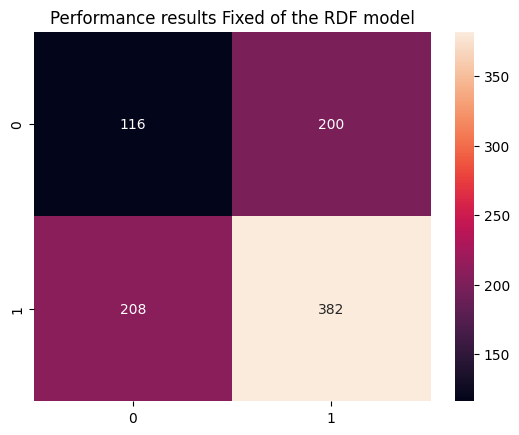


Feature Importance of the model



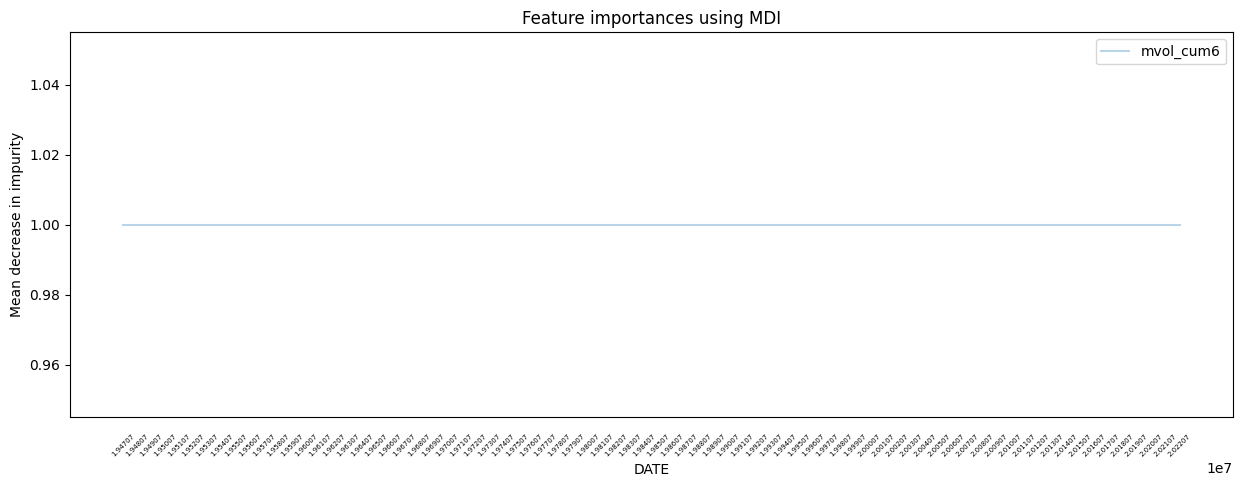

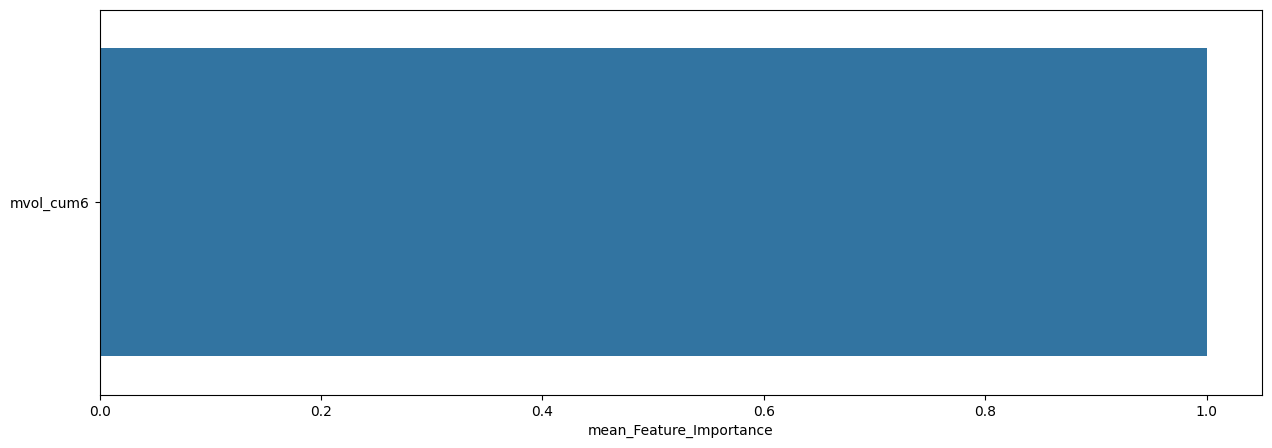

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0

In [90]:
Fixed_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=RDF, # 사용할 모델
                                  model_name='RDF', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.40      0.37        75
         1.0       0.67      0.62      0.64       151

    accuracy                           0.54       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.56      0.54      0.55       226


accuracy : 0.5442477876106194

precision : 0.6739130434782609

recall : 0.6158940397350994

F1-Score : 0.643598615916955



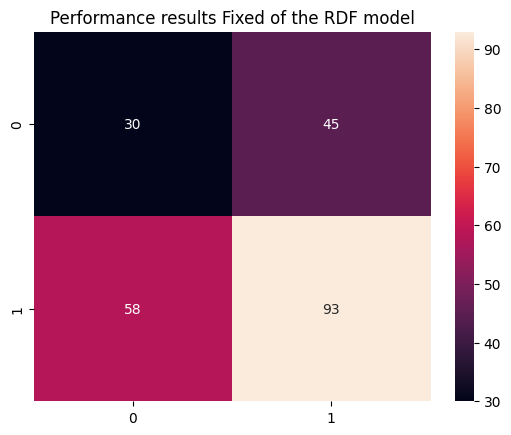


Feature Importance of the model



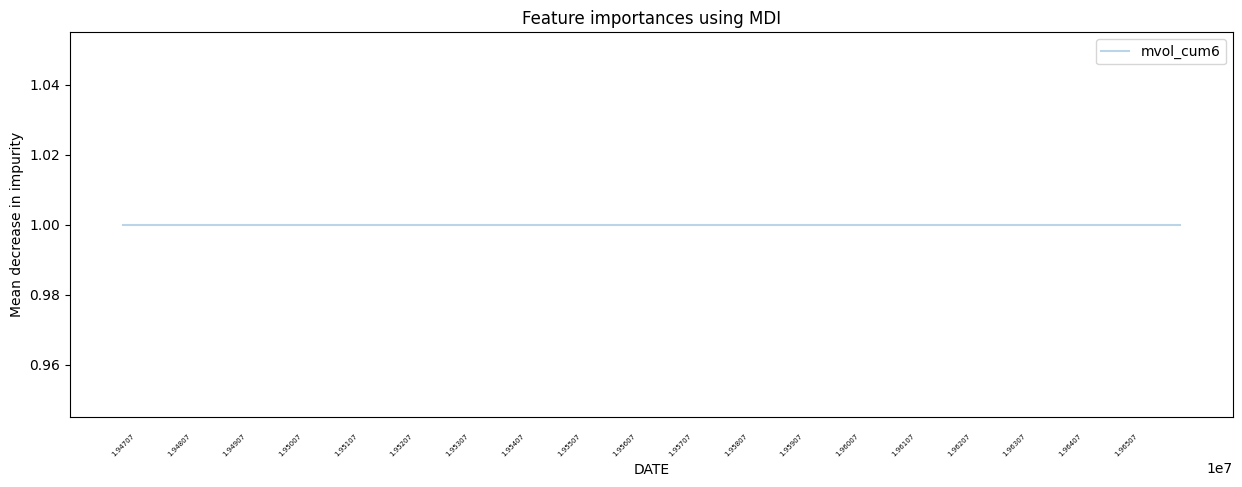

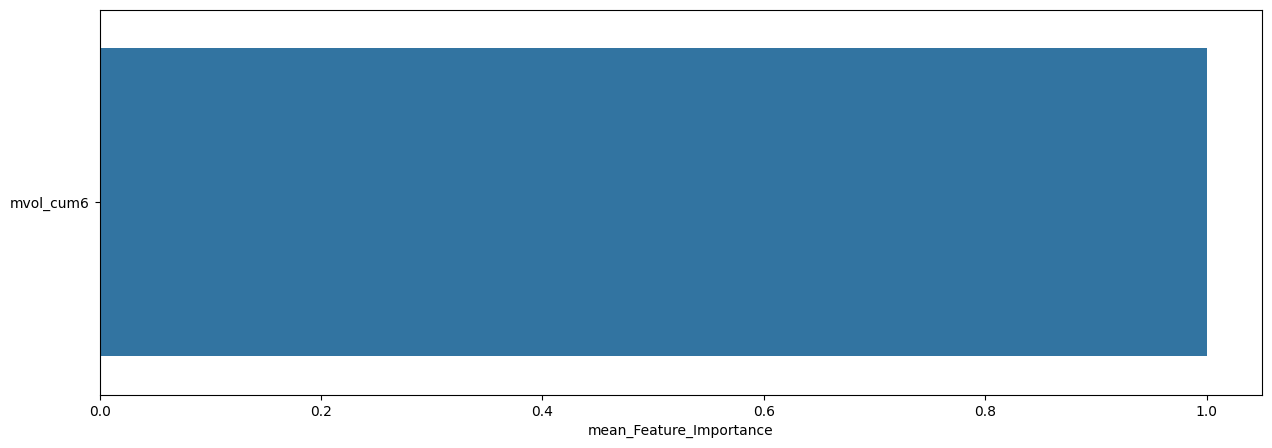

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.42      0.40      0.41        75
         1.0       0.71      0.72      0.71       151

    accuracy                           0.62       226
   macro avg       0.56      0.56      0.56       226
weighted avg       0.61      0.62      0.61       226


accuracy : 0.6150442477876106

precision : 0.7077922077922078

recall : 0.7218543046357616

F1-Score : 0.7147540983606556



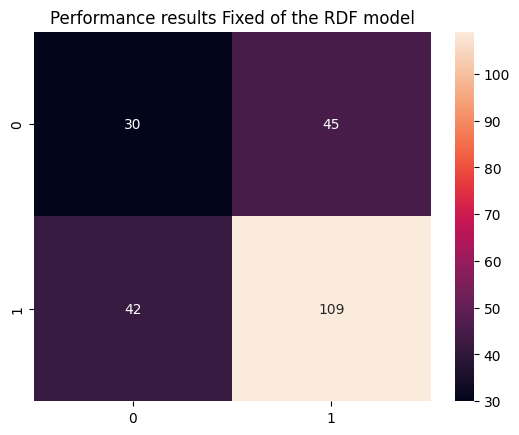


Feature Importance of the model



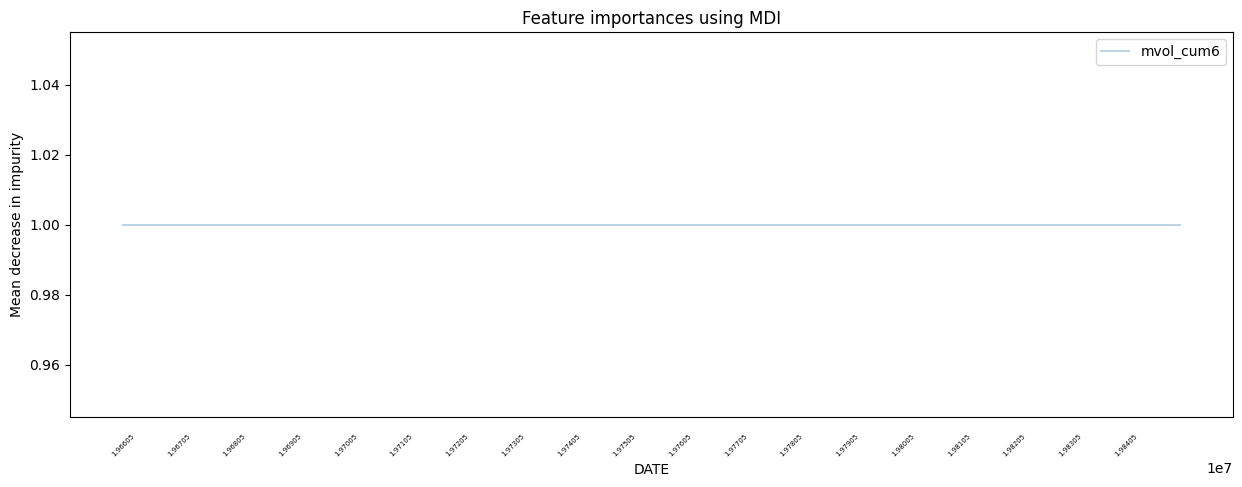

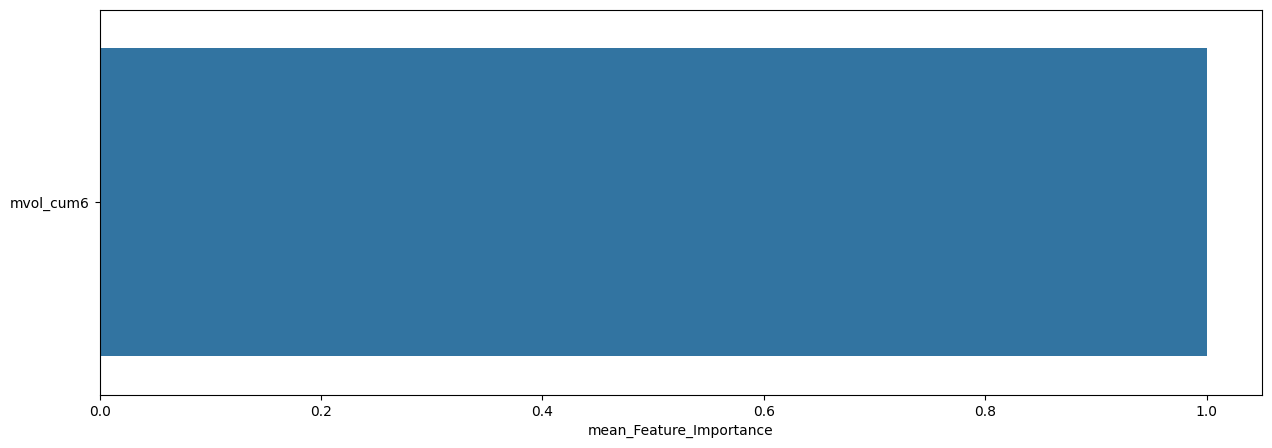

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.29      0.34      0.31        70
         1.0       0.68      0.62      0.64       156

    accuracy                           0.53       226
   macro avg       0.48      0.48      0.48       226
weighted avg       0.56      0.53      0.54       226


accuracy : 0.5309734513274337

precision : 0.676056338028169

recall : 0.6153846153846154

F1-Score : 0.6442953020134228



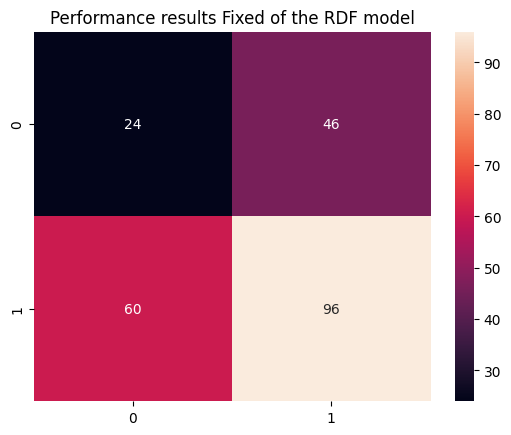


Feature Importance of the model



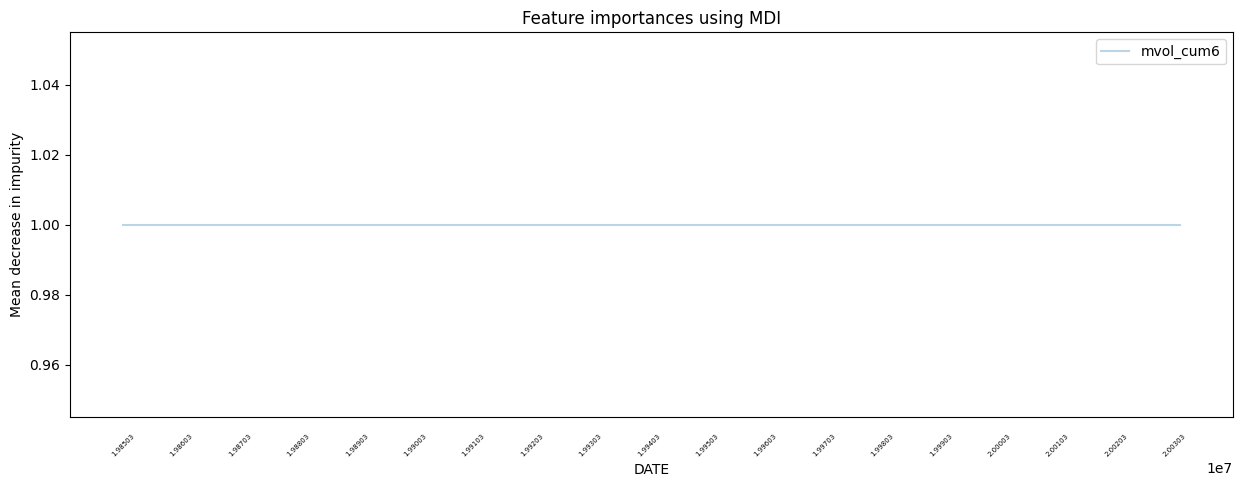

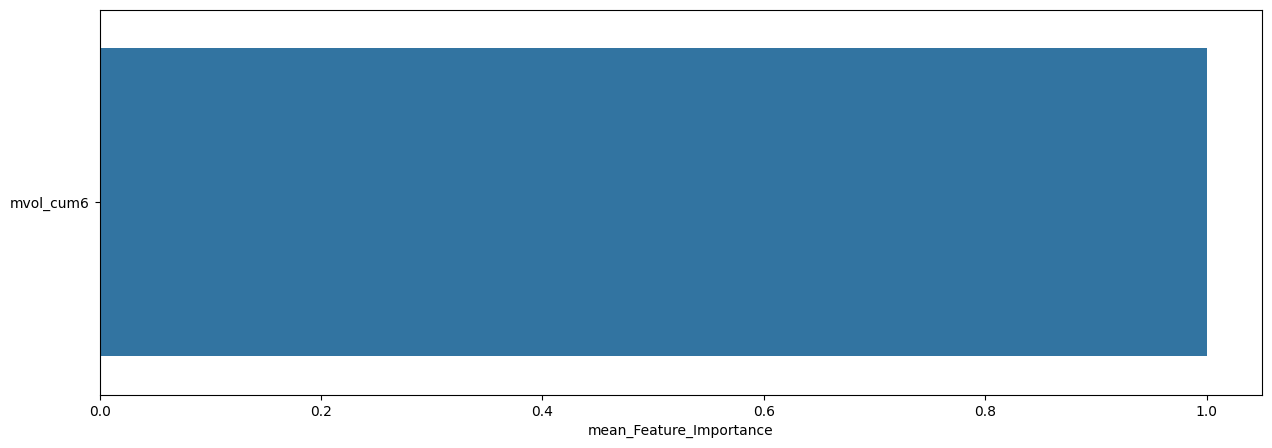

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.40      0.33      0.36        96
         1.0       0.57      0.64      0.60       132

    accuracy                           0.51       228
   macro avg       0.48      0.48      0.48       228
weighted avg       0.50      0.51      0.50       228


accuracy : 0.5087719298245614

precision : 0.5675675675675675

recall : 0.6363636363636364

F1-Score : 0.6000000000000001



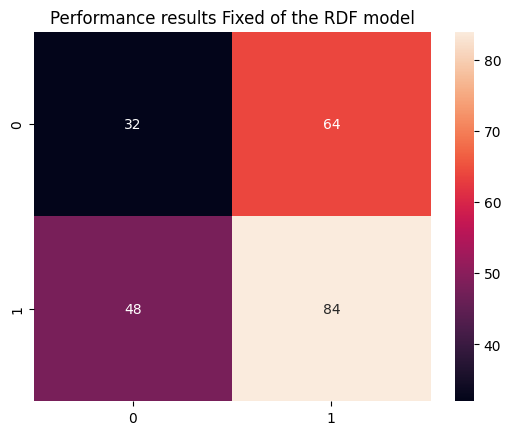


Feature Importance of the model



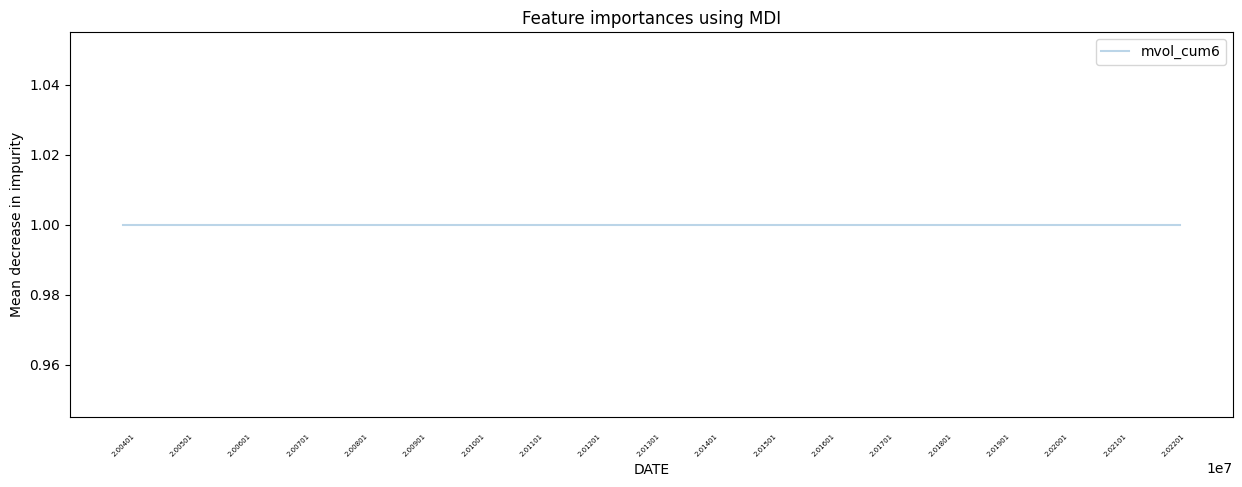

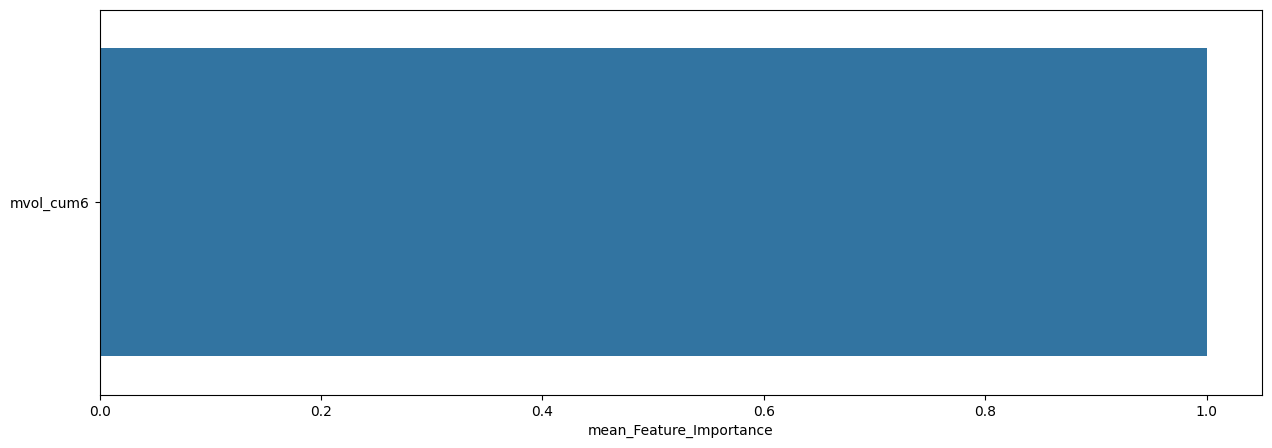

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0

In [91]:
slice_feature_importance(Fixed_RDF_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'RDF') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



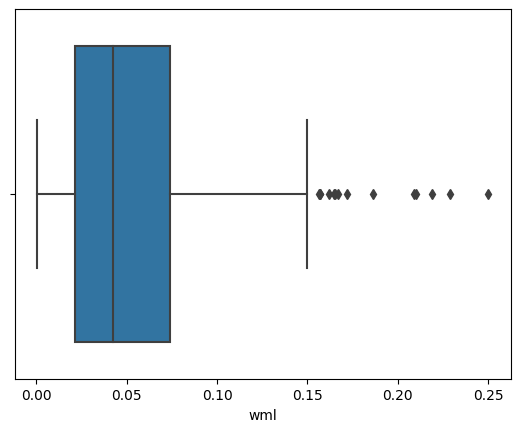

count      mean       std       min       25%       50%       75%  \
wml  382.0  0.053343  0.043756  0.000577  0.021288  0.042614  0.074103   

          max  
wml  0.250175


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



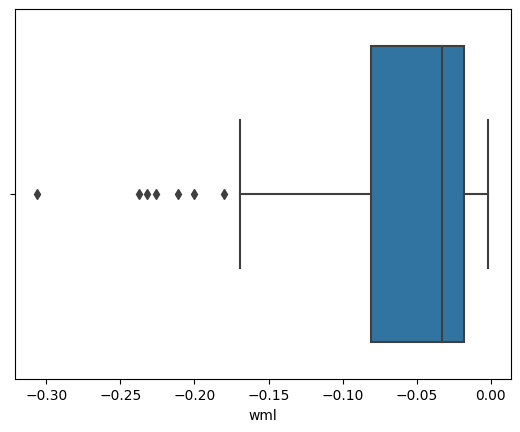

count      mean       std      min       25%       50%       75%  \
wml  116.0 -0.058667  0.061259 -0.30599 -0.081143 -0.032656 -0.017953   

          max  
wml -0.001641


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



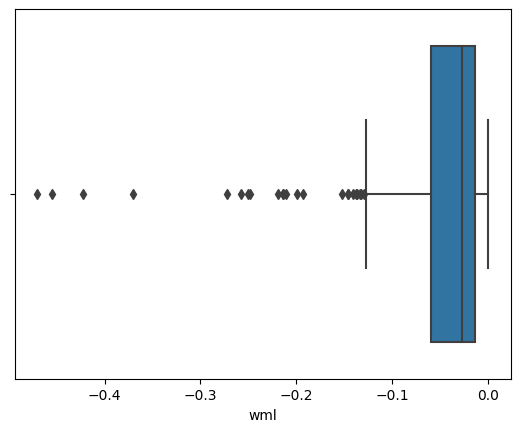

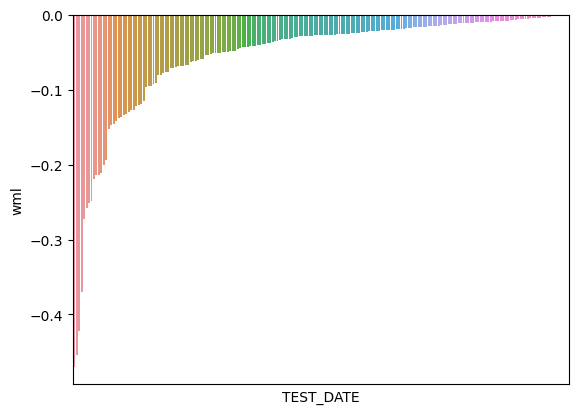

count      mean       std       min       25%       50%       75%  \
wml  200.0 -0.054945  0.076542 -0.469903 -0.060041 -0.027247 -0.013844   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



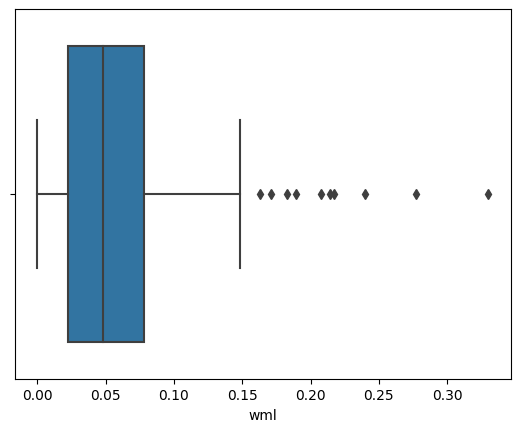

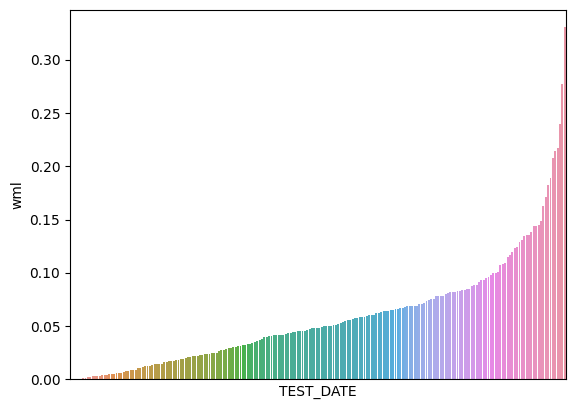

count      mean       std       min       25%       50%       75%  \
wml  208.0  0.058752  0.051886  0.000007  0.022153  0.048168  0.078287   

          max  
wml  0.330163

In [92]:
RDF_A0_P1, RDF_A1_P0 = What_Pred(Fixed_RDF_Result, WML, 'RDF')

Sharpe Ratio : 0.85083

최근 누적 수익률

  2022년-12월 -> 1683.83
  2022년-11월 -> 1517.01
  2022년-10월 -> 1442.94
  2022년-09월 -> 1442.94
  2022년-08월 -> 1442.94

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2000년-02월 -> 3708.24
  2등 : 2000년-01월 -> 3708.24
  3등 : 1999년-11월 -> 3624.45
  4등 : 1999년-12월 -> 3624.45
  5등 : 2008년-11월 -> 3331.88
  6등 : 2000년-12월 -> 3265.02
  7등 : 2000년-11월 -> 3265.02
  8등 : 2000년-10월 -> 3265.02
  9등 : 2009년-02월 -> 3253.00
  10등 : 2008년-12월 -> 3253.00



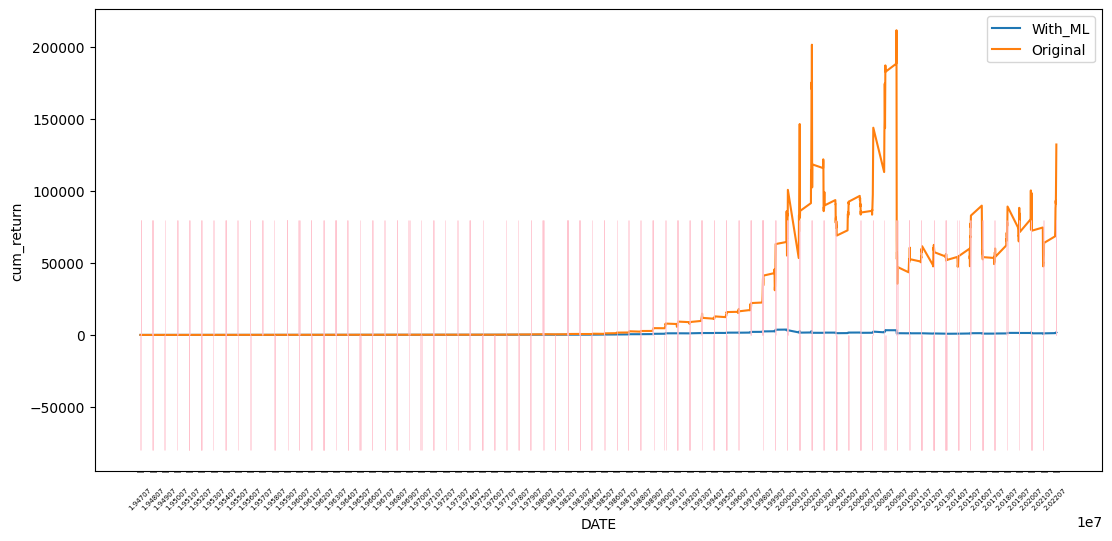

In [93]:
RDF_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_RDF_Result,
                                                 WML,
                                                 'RDF_PRED_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.85373

최근 누적 수익률

  2022년-12월 -> 3655.28
  2022년-11월 -> 3397.56
  2022년-10월 -> 3268.44
  2022년-09월 -> 3202.16
  2022년-08월 -> 3133.26

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 4747.06
  2등 : 2008년-11월 -> 4634.67
  3등 : 2009년-01월 -> 4572.60
  4등 : 2008년-12월 -> 4524.95
  5등 : 2008년-10월 -> 4230.07
  6등 : 2008년-06월 -> 4040.22
  7등 : 2008년-09월 -> 3995.64
  8등 : 2007년-12월 -> 3892.46
  9등 : 2002년-09월 -> 3854.20
  10등 : 2008년-07월 -> 3742.39



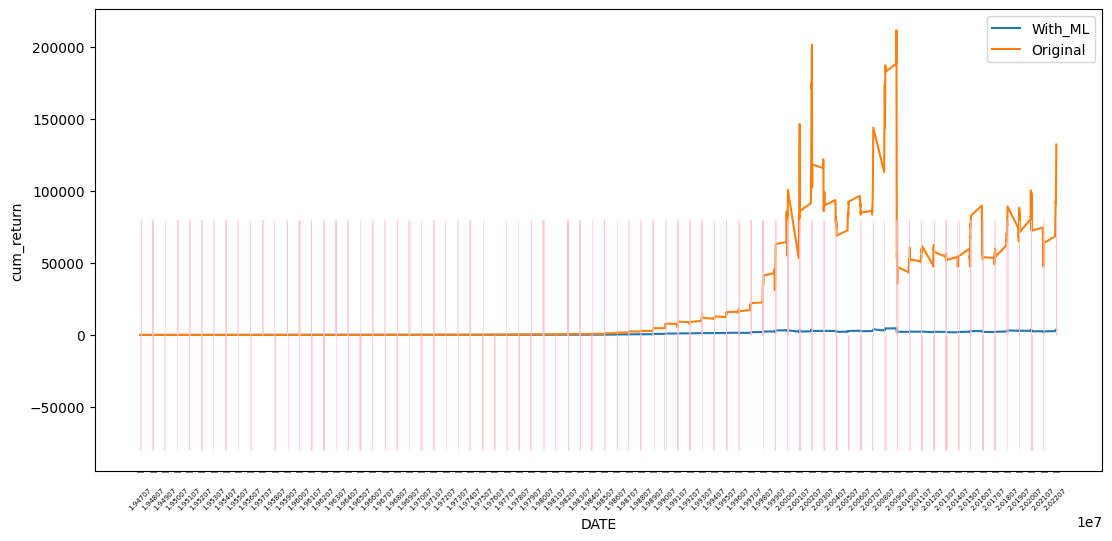

In [94]:
RDF_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_RDF_Result,
                                                 WML,
                                                 'RDF_PROB_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

### Grdient Boosting

In [95]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

**************************************************

GBC Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.29      0.32       316
         1.0       0.66      0.73      0.69       590

    accuracy                           0.58       906
   macro avg       0.51      0.51      0.51       906
weighted avg       0.56      0.58      0.56       906


accuracy : 0.5772626931567328

precision : 0.6575342465753424

recall : 0.7322033898305085

F1-Score : 0.6928628708901363



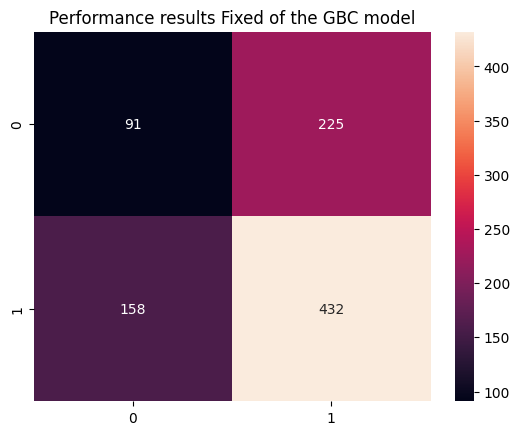


Feature Importance of the model



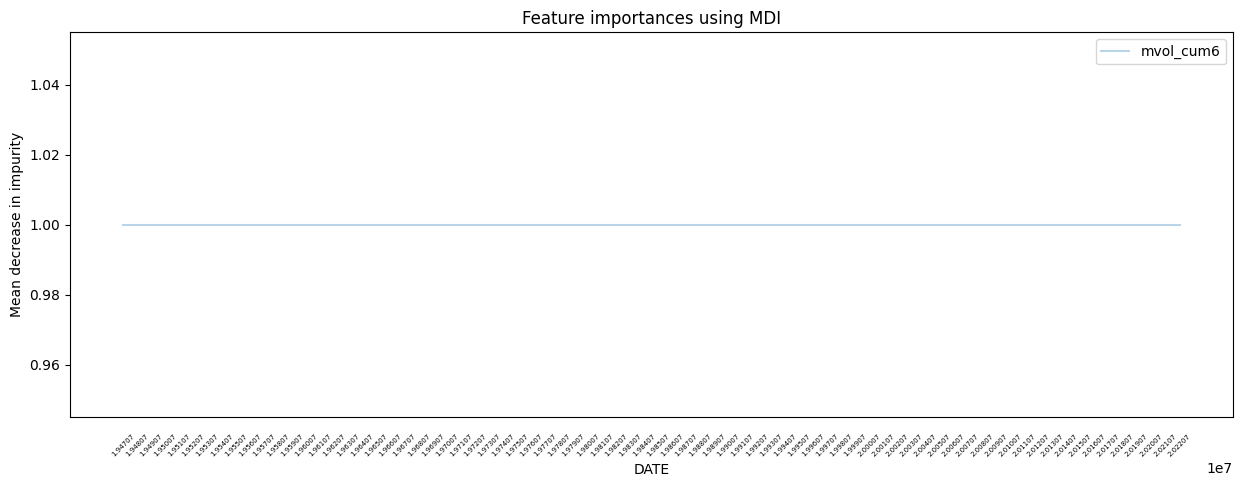

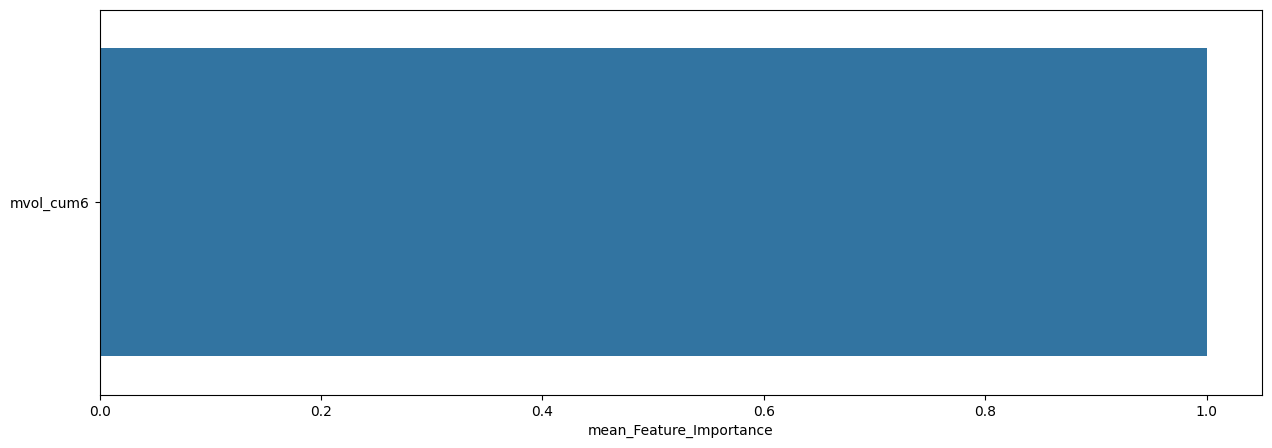

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0

In [96]:
Fixed_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=GBC, # 사용할 모델
                                  model_name='GBC', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.28      0.30        75
         1.0       0.67      0.72      0.69       151

    accuracy                           0.57       226
   macro avg       0.50      0.50      0.50       226
weighted avg       0.55      0.57      0.56       226


accuracy : 0.5707964601769911

precision : 0.6666666666666666

recall : 0.7152317880794702

F1-Score : 0.6900958466453674



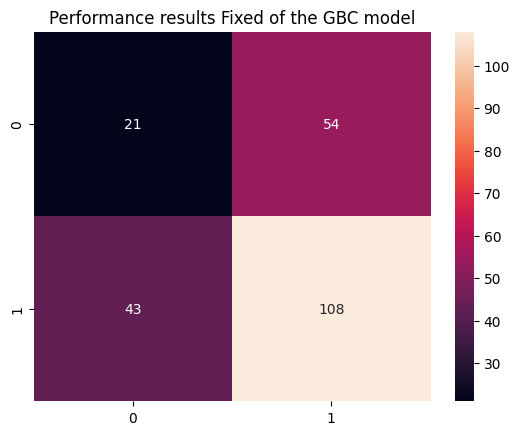


Feature Importance of the model



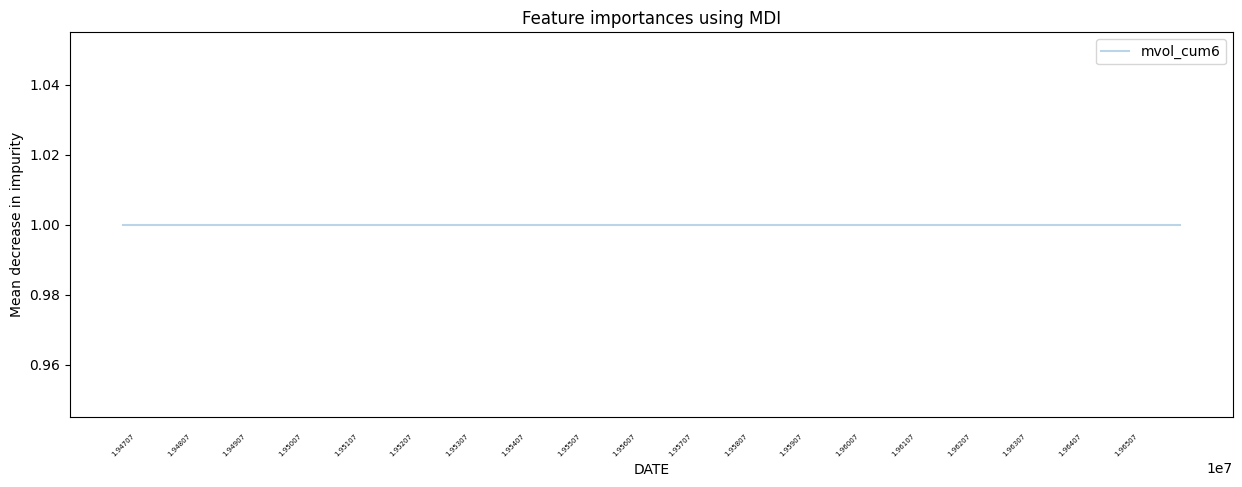

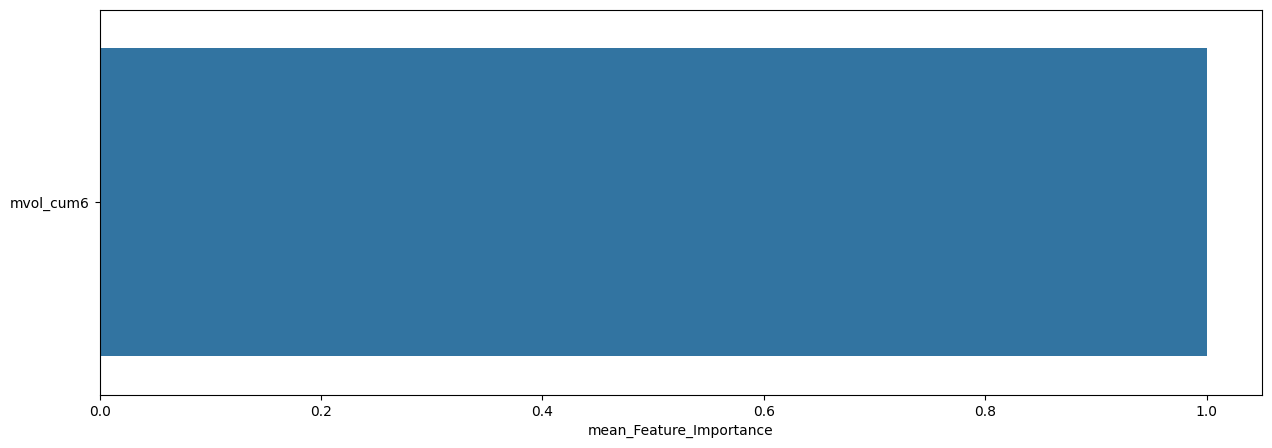

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.44      0.35      0.39        75
         1.0       0.71      0.78      0.74       151

    accuracy                           0.64       226
   macro avg       0.57      0.56      0.57       226
weighted avg       0.62      0.64      0.62       226


accuracy : 0.6371681415929203

precision : 0.7065868263473054

recall : 0.7814569536423841

F1-Score : 0.7421383647798742



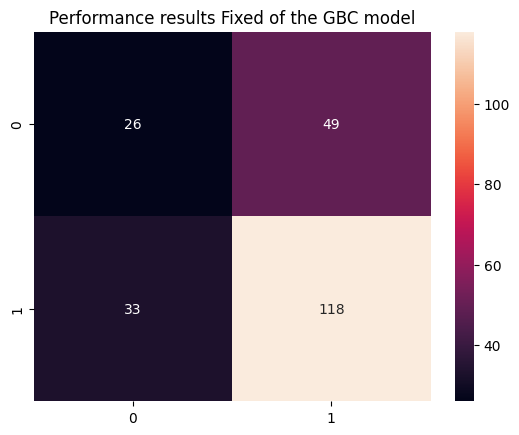


Feature Importance of the model



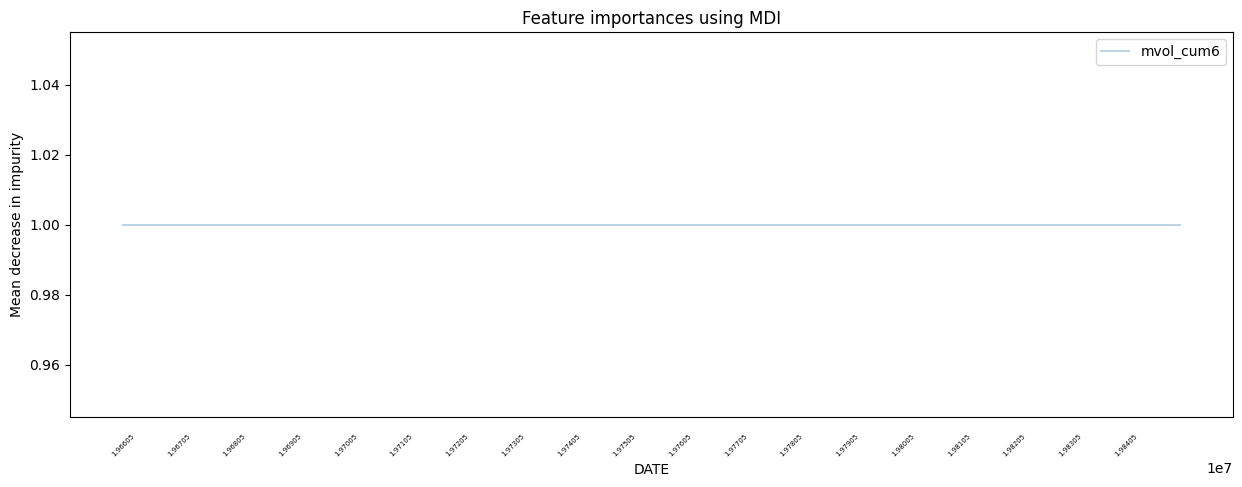

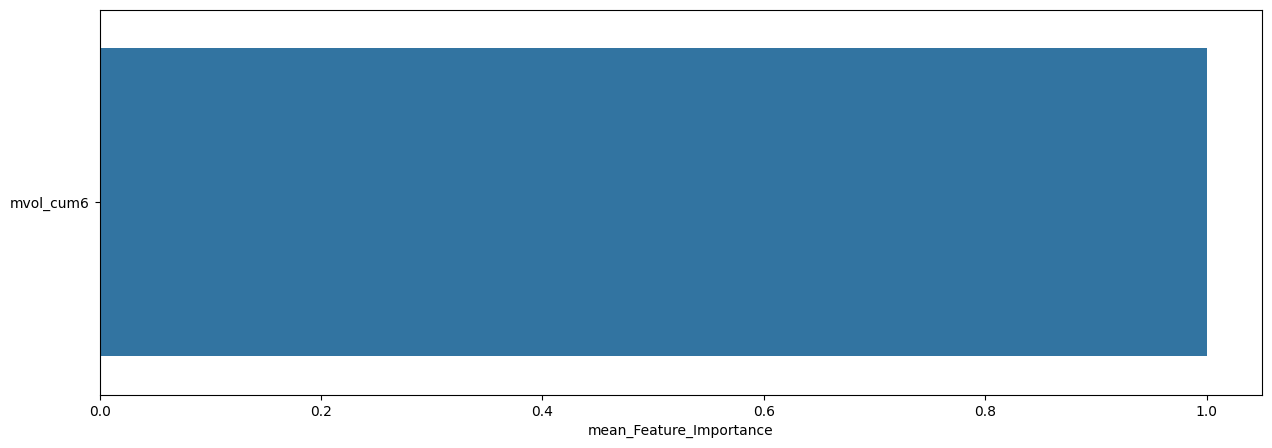

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.31      0.31      0.31        70
         1.0       0.69      0.69      0.69       156

    accuracy                           0.58       226
   macro avg       0.50      0.50      0.50       226
weighted avg       0.58      0.58      0.58       226


accuracy : 0.5752212389380531

precision : 0.6923076923076923

recall : 0.6923076923076923

F1-Score : 0.6923076923076923



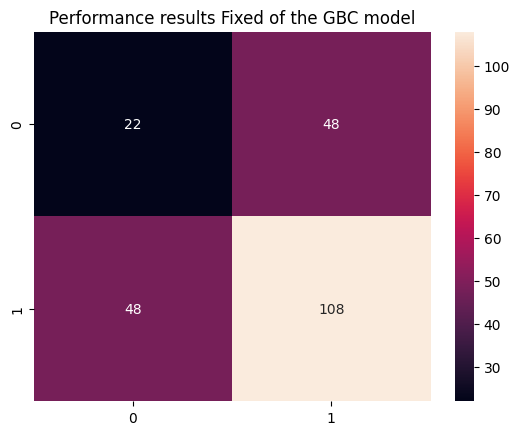


Feature Importance of the model



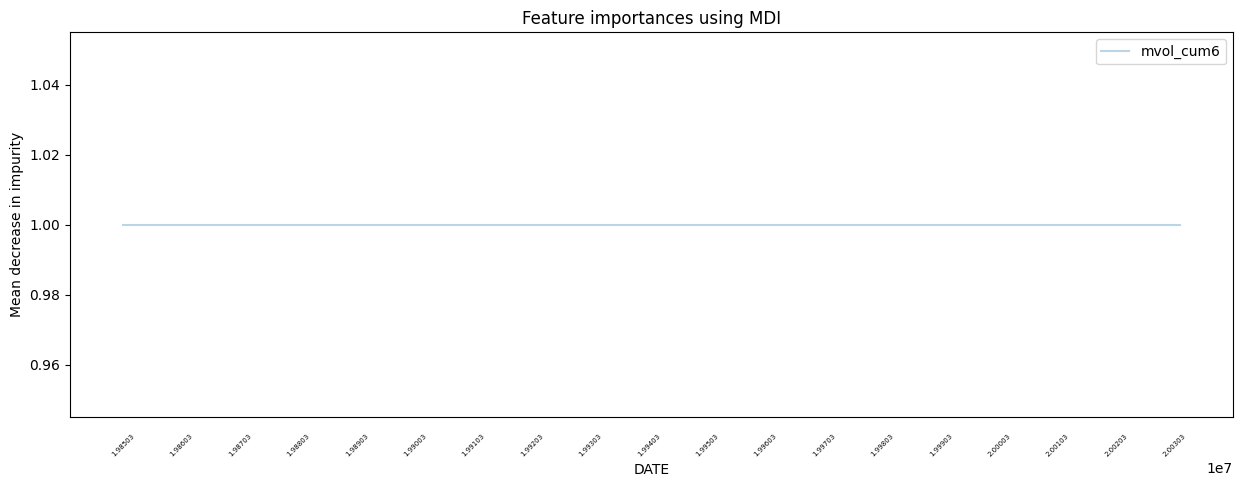

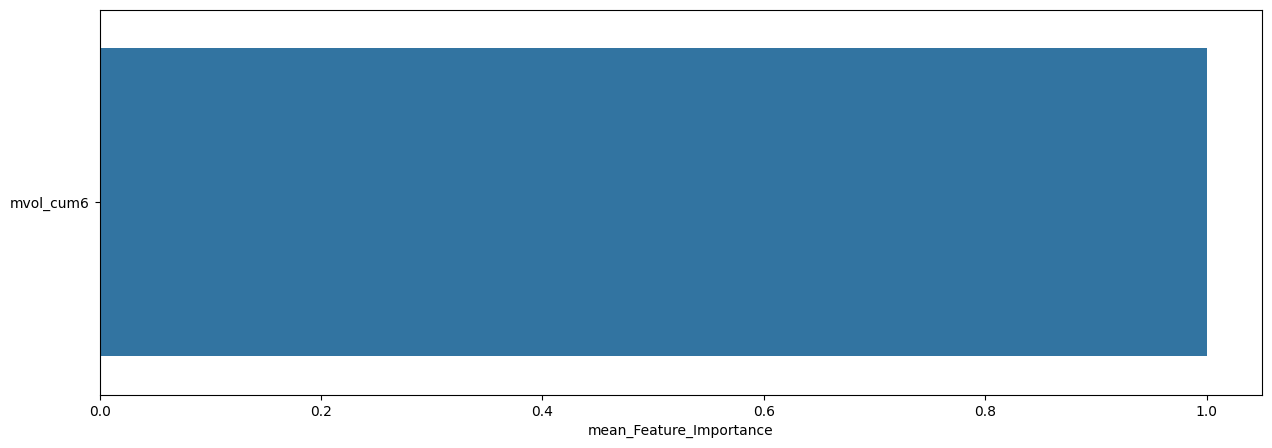

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.23      0.29        96
         1.0       0.57      0.74      0.64       132

    accuracy                           0.53       228
   macro avg       0.48      0.49      0.47       228
weighted avg       0.50      0.53      0.50       228


accuracy : 0.5263157894736842

precision : 0.5697674418604651

recall : 0.7424242424242424

F1-Score : 0.6447368421052633



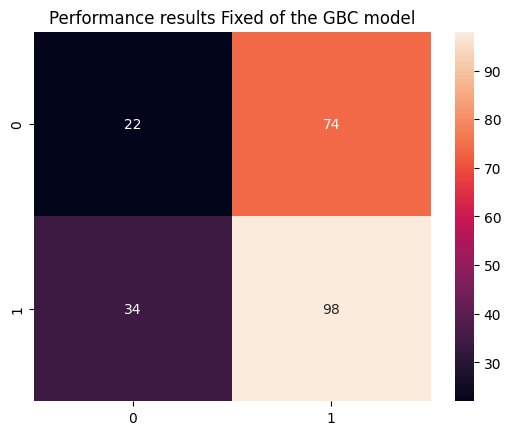


Feature Importance of the model



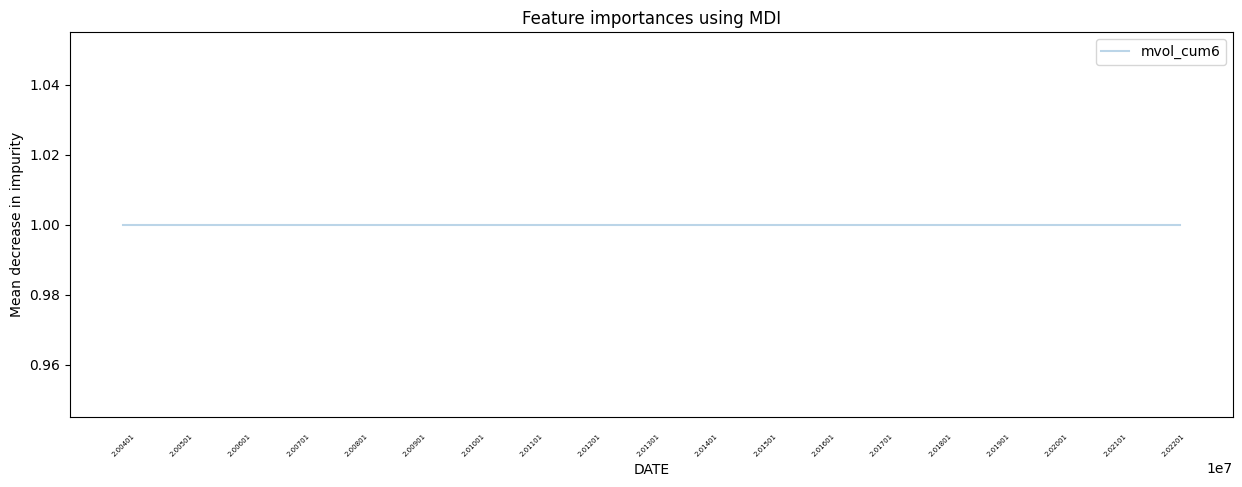

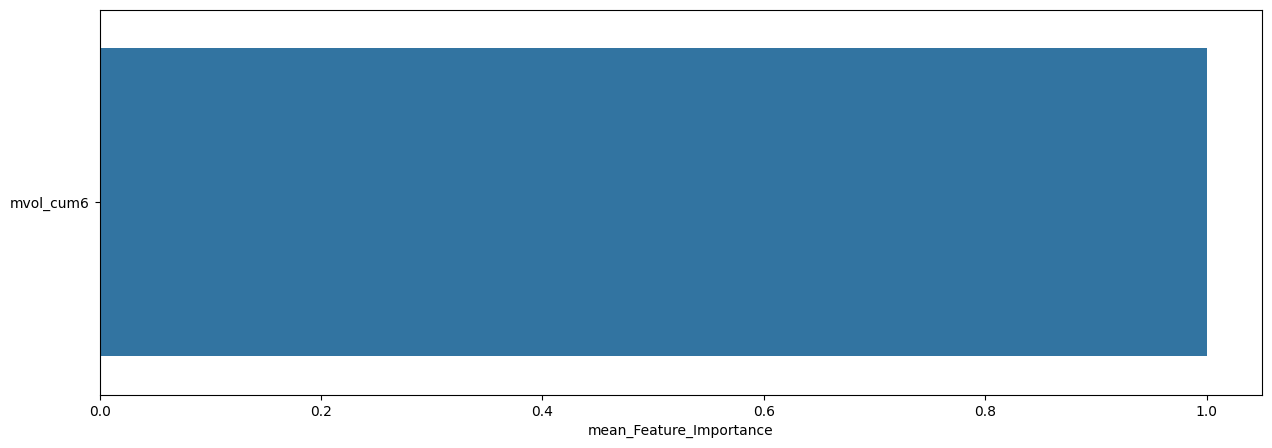

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0

In [97]:
slice_feature_importance(Fixed_GBC_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'GBC') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



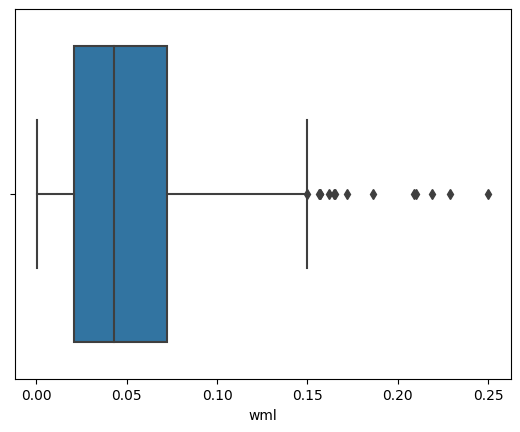

count      mean       std       min       25%       50%       75%  \
wml  432.0  0.052547  0.042404  0.000577  0.020903  0.042885  0.072495   

          max  
wml  0.250175


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



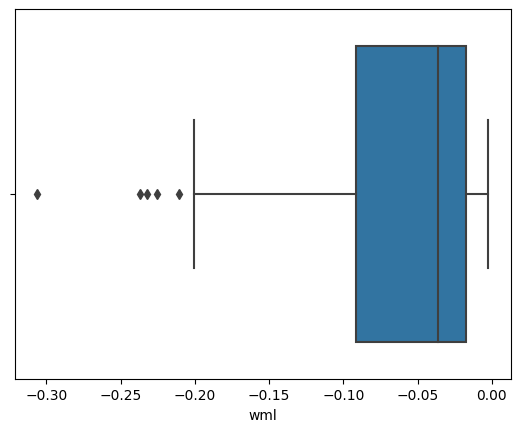

count      mean      std      min       25%       50%       75%       max
wml   91.0 -0.063095  0.06543 -0.30599 -0.091715 -0.036068 -0.017237 -0.002394


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



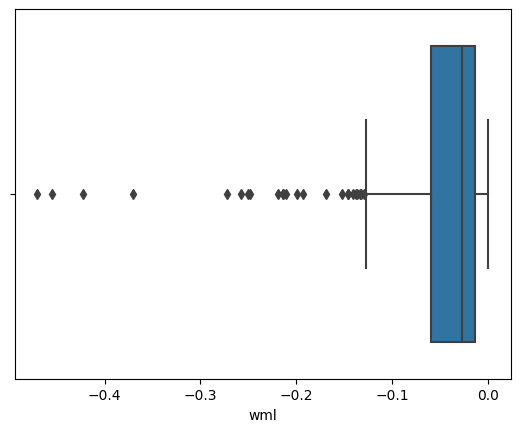

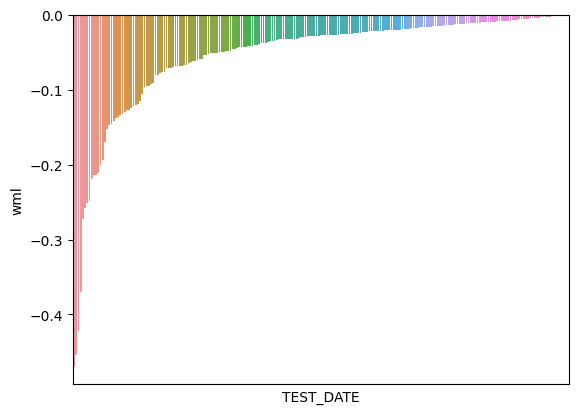

count      mean       std       min       25%       50%       75%  \
wml  225.0 -0.053567  0.073414 -0.469903 -0.059647 -0.027362 -0.014203   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



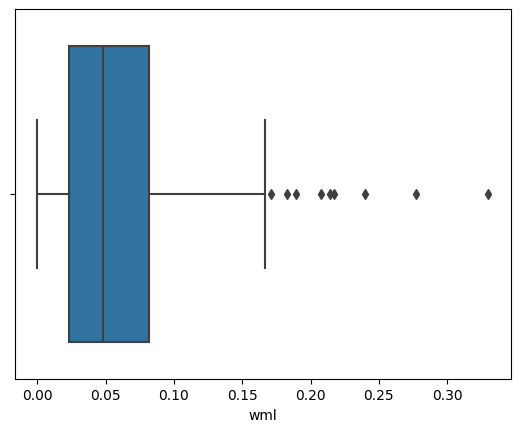

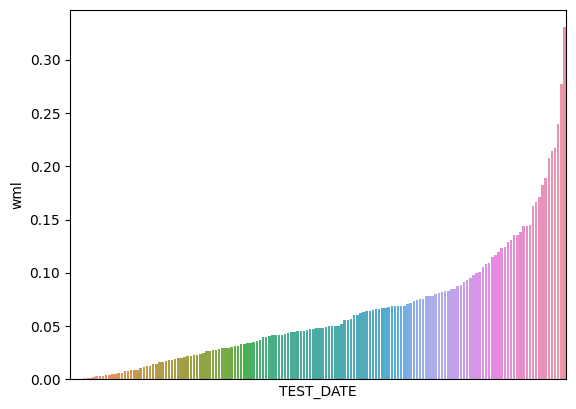

count     mean       std       min      25%       50%     75%       max
wml  158.0  0.06264  0.056652  0.000007  0.02301  0.047988  0.0819  0.330163

In [98]:
GBC_A0_P1, GBC_A1_P0 = What_Pred(Fixed_GBC_Result, WML, 'GBC')

Sharpe Ratio : 0.85356

최근 누적 수익률

  2022년-12월 -> 5278.90
  2022년-11월 -> 4756.10
  2022년-10월 -> 4524.00
  2022년-09월 -> 4524.00
  2022년-08월 -> 4524.00

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2008년-11월 -> 9651.67
  2등 : 2000년-02월 -> 9511.77
  3등 : 2000년-01월 -> 9511.77
  4등 : 2009년-02월 -> 9423.20
  5등 : 2009년-01월 -> 9423.20
  6등 : 2008년-12월 -> 9423.20
  7등 : 1999년-12월 -> 9296.87
  8등 : 1999년-11월 -> 9296.87
  9등 : 2008년-10월 -> 8801.43
  10등 : 2000년-12월 -> 8375.08



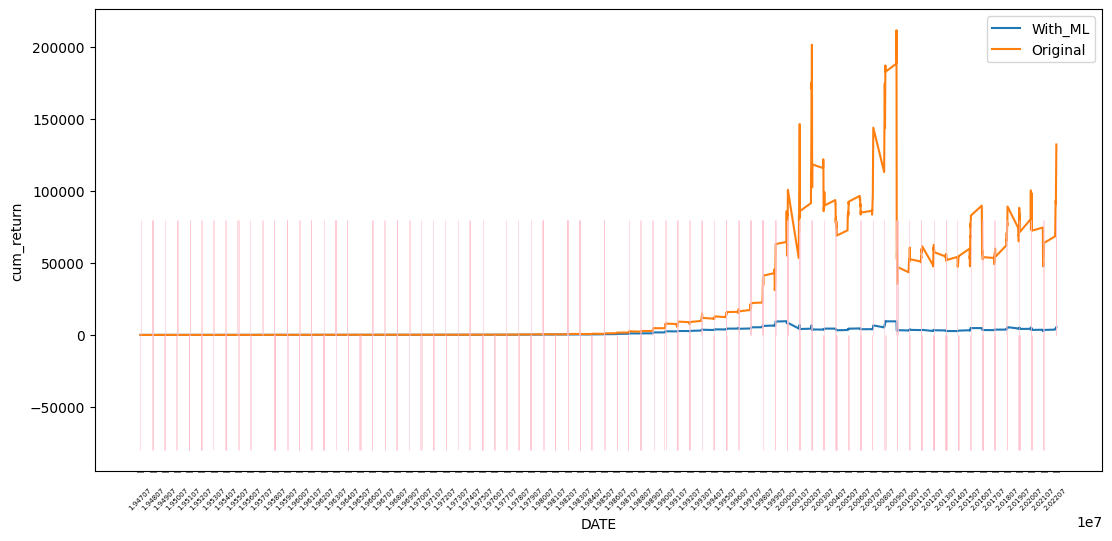

In [99]:
GBC_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_GBC_Result,
                                                 WML,
                                                 'GBC_PRED_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.84145

최근 누적 수익률

  2022년-12월 -> 2822.60
  2022년-11월 -> 2609.54
  2022년-10월 -> 2517.28
  2022년-09월 -> 2454.85
  2022년-08월 -> 2406.22

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 4387.34
  2등 : 2008년-11월 -> 4331.24
  3등 : 2009년-01월 -> 4249.82
  4등 : 2008년-12월 -> 4233.51
  5등 : 2008년-10월 -> 3968.17
  6등 : 2008년-09월 -> 3758.81
  7등 : 2008년-06월 -> 3663.77
  8등 : 2008년-07월 -> 3476.75
  9등 : 2008년-08월 -> 3434.85
  10등 : 2007년-12월 -> 3270.94



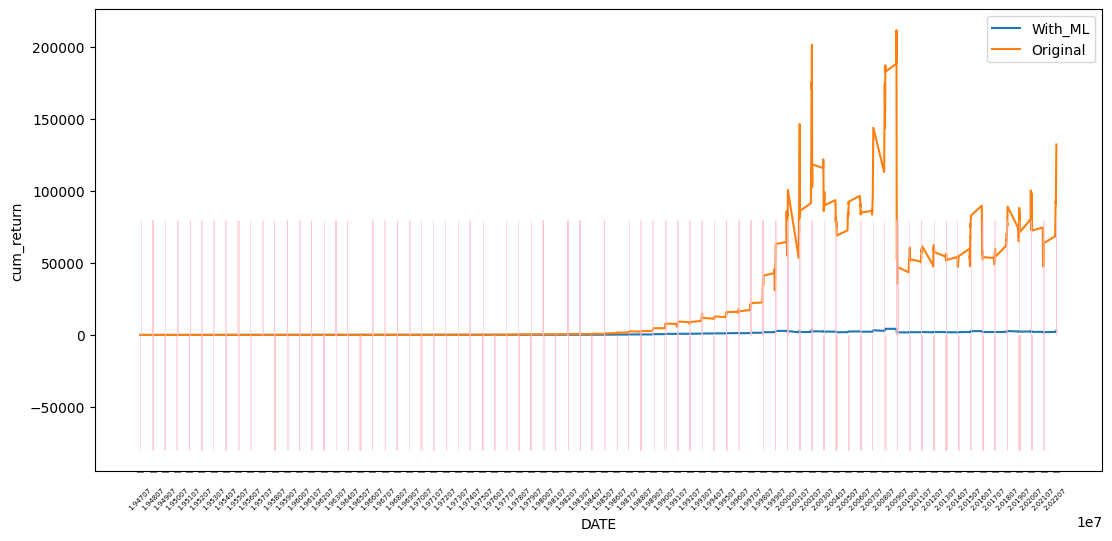

In [100]:
GBC_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_GBC_Result,
                                                 WML,
                                                 'GBC_PROB_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

### XGB

In [101]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

**************************************************

XGB Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : None
 

  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.30      0.33       316
         1.0       0.65      0.70      0.67       590

    accuracy                           0.56       906
   macro avg       0.50      0.50      0.50       906
weighted avg       0.55      0.56      0.55       906


accuracy : 0.5607064017660044

precision : 0.6518987341772152

recall : 0.6983050847457627

F1-Score : 0.67430441898527



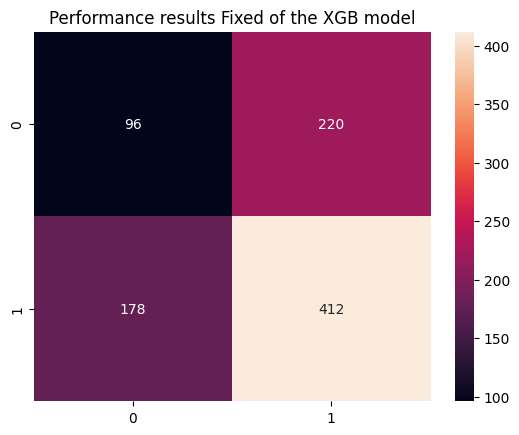


Feature Importance of the model



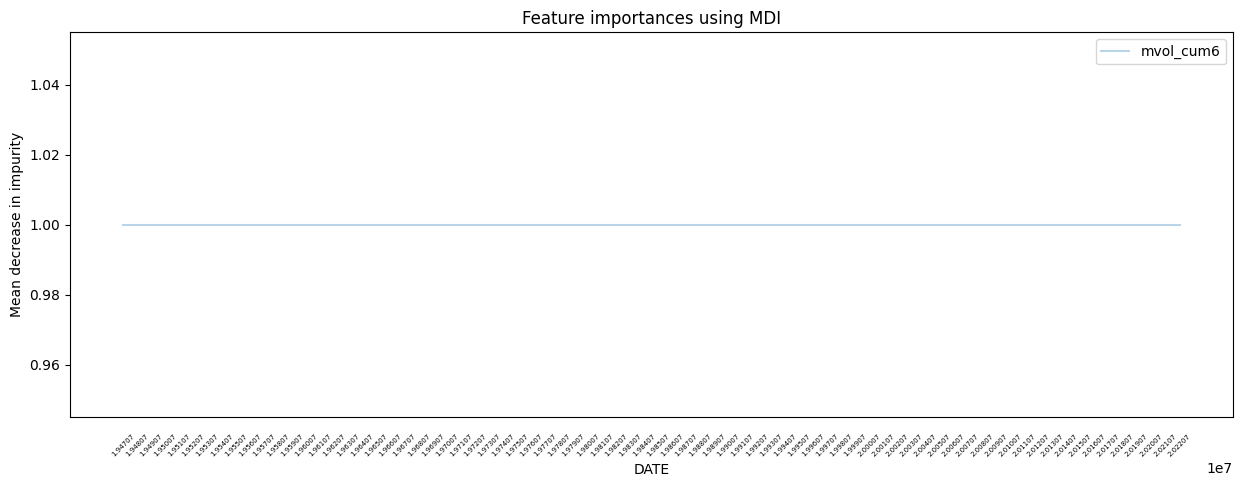

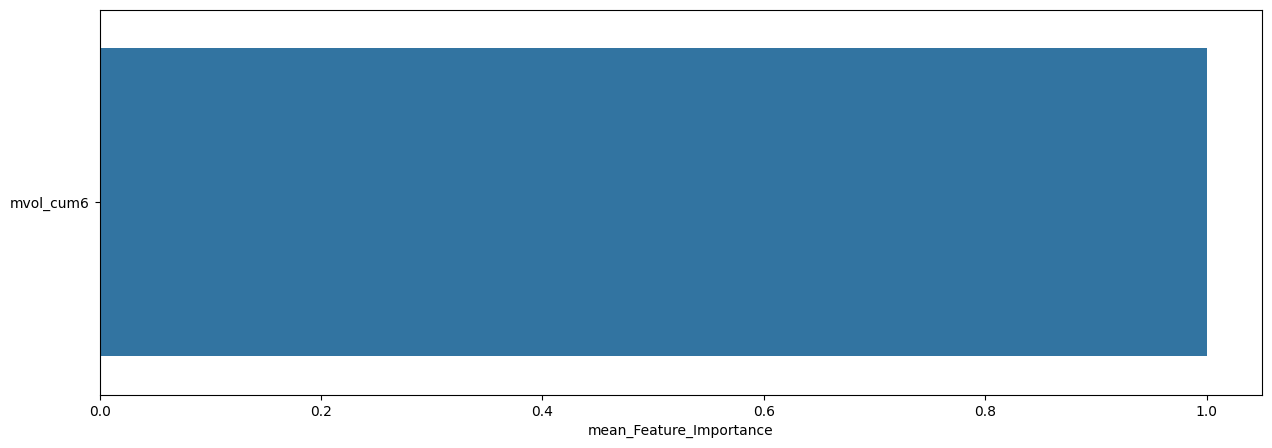

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0

In [102]:
Fixed_XGB_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=XGB, # 사용할 모델
                                  model_name='XGB', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.28      0.29        75
         1.0       0.65      0.68      0.66       151

    accuracy                           0.54       226
   macro avg       0.48      0.48      0.48       226
weighted avg       0.54      0.54      0.54       226


accuracy : 0.5442477876106194

precision : 0.6538461538461539

recall : 0.6754966887417219

F1-Score : 0.6644951140065147



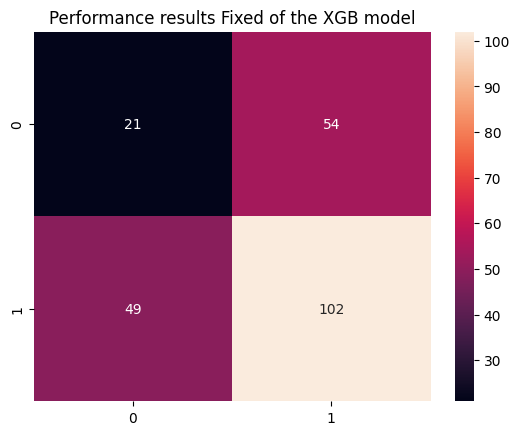


Feature Importance of the model



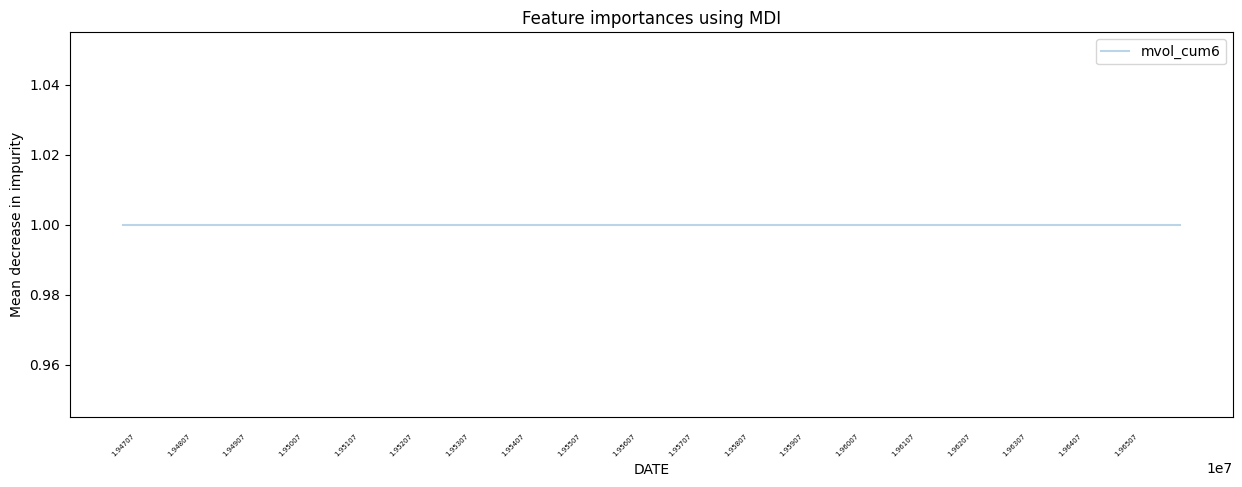

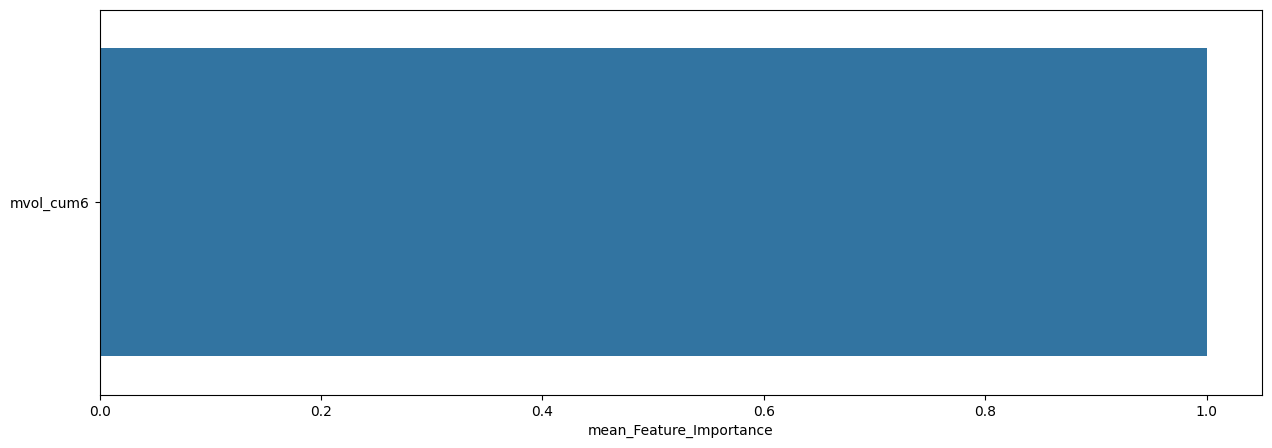

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.32      0.35        75
         1.0       0.69      0.75      0.72       151

    accuracy                           0.61       226
   macro avg       0.54      0.53      0.53       226
weighted avg       0.59      0.61      0.60       226


accuracy : 0.6061946902654868

precision : 0.6890243902439024

recall : 0.7483443708609272

F1-Score : 0.7174603174603174



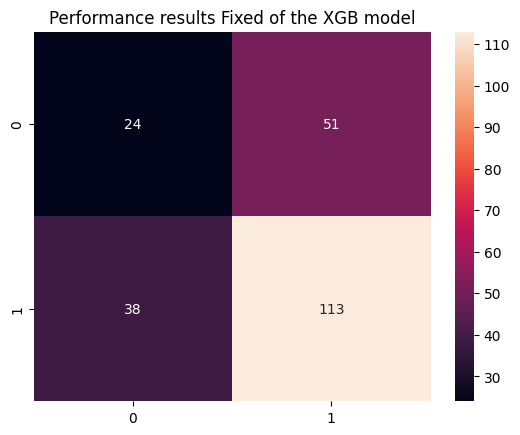


Feature Importance of the model



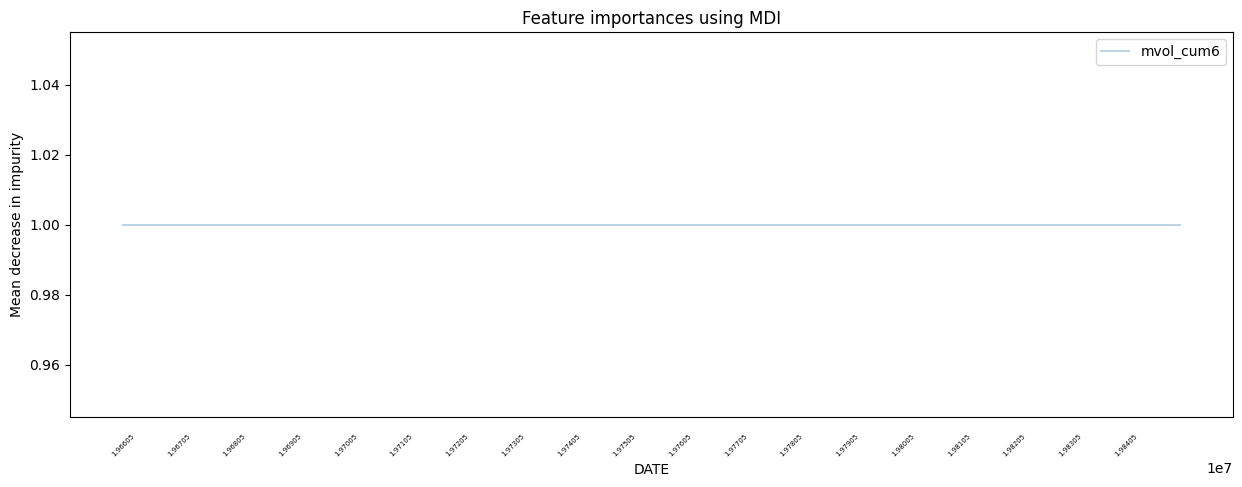

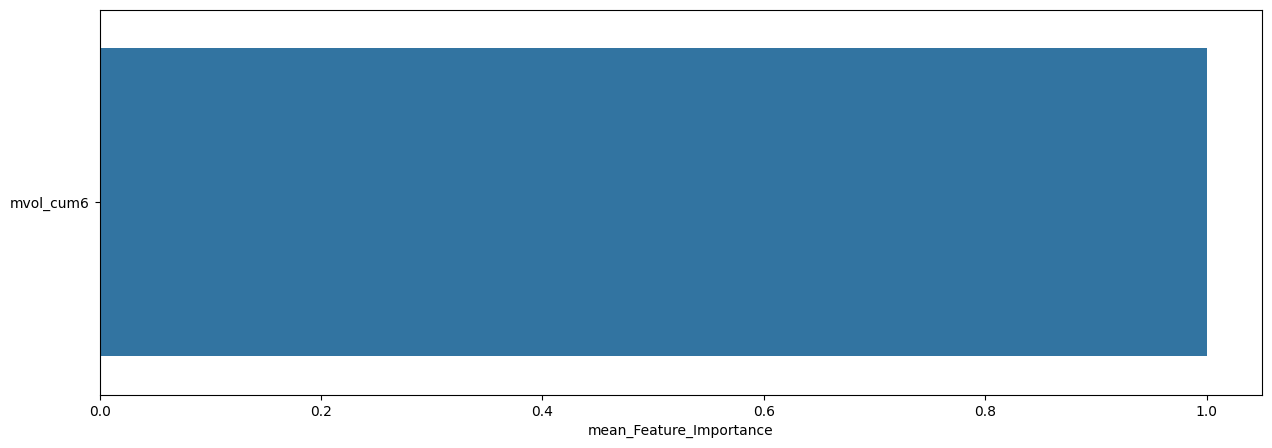

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.34      0.33        70
         1.0       0.70      0.67      0.68       156

    accuracy                           0.57       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.58      0.57      0.57       226


accuracy : 0.5707964601769911

precision : 0.695364238410596

recall : 0.6730769230769231

F1-Score : 0.6840390879478828



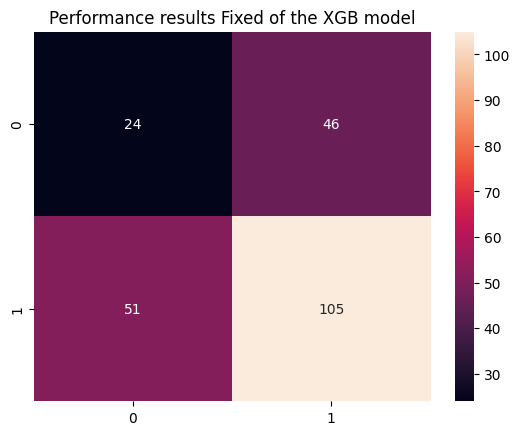


Feature Importance of the model



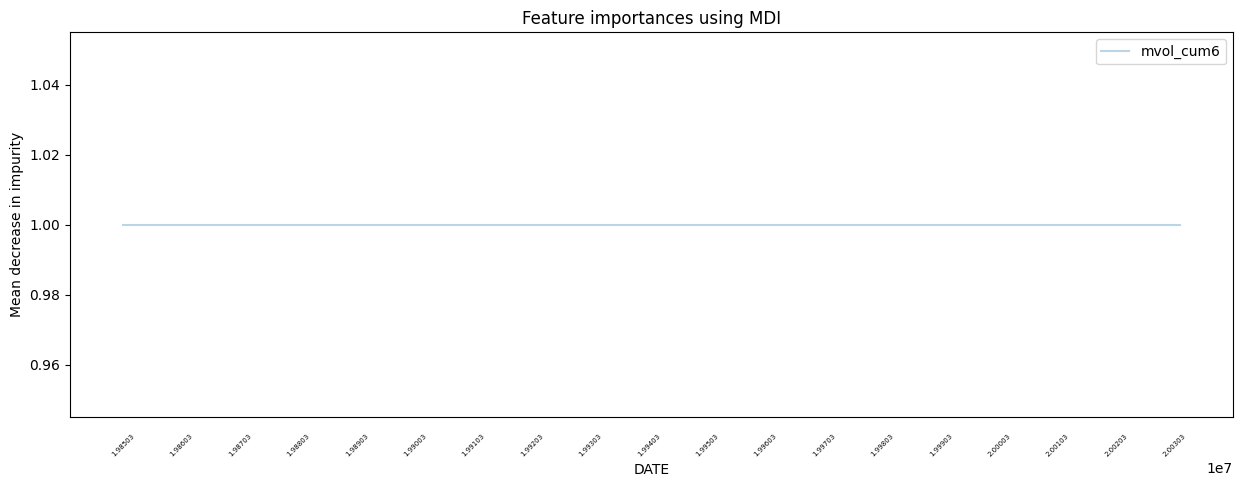

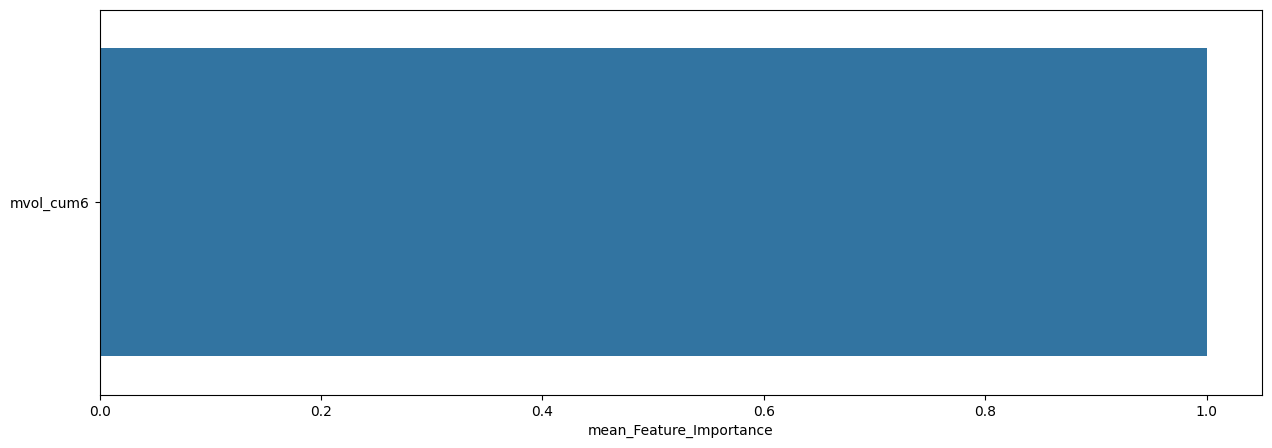

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.40      0.28      0.33        96
         1.0       0.57      0.70      0.63       132

    accuracy                           0.52       228
   macro avg       0.49      0.49      0.48       228
weighted avg       0.50      0.52      0.50       228


accuracy : 0.5219298245614035

precision : 0.5714285714285714

recall : 0.696969696969697

F1-Score : 0.6279863481228669



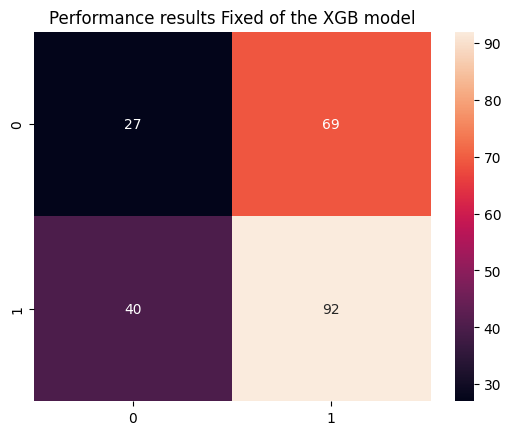


Feature Importance of the model



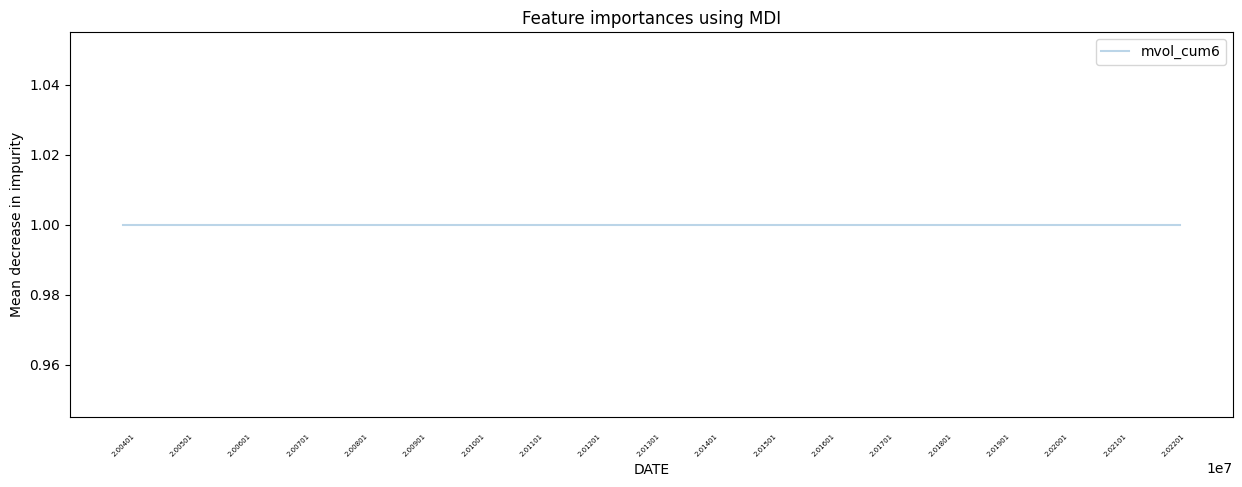

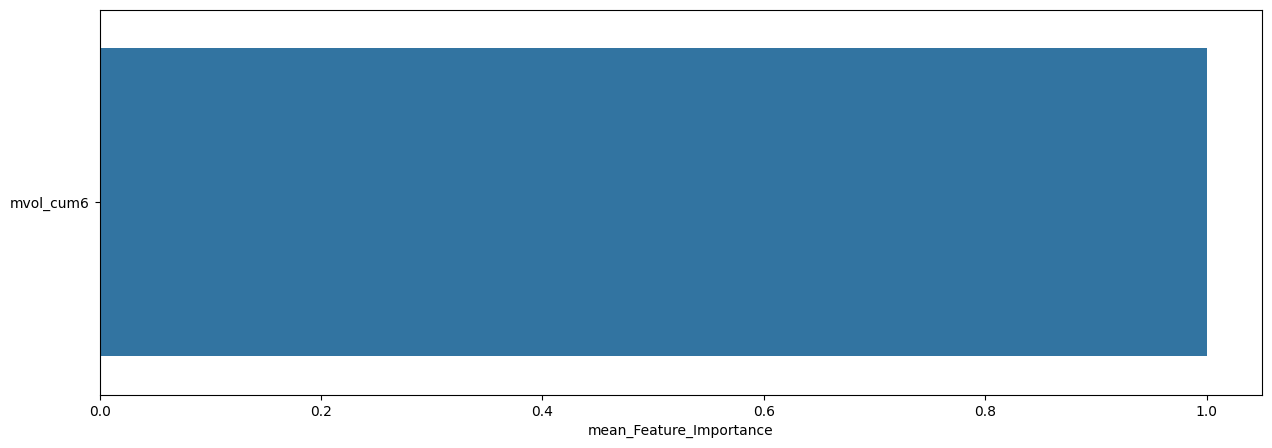

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0

In [103]:
slice_feature_importance(Fixed_XGB_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'XGB') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



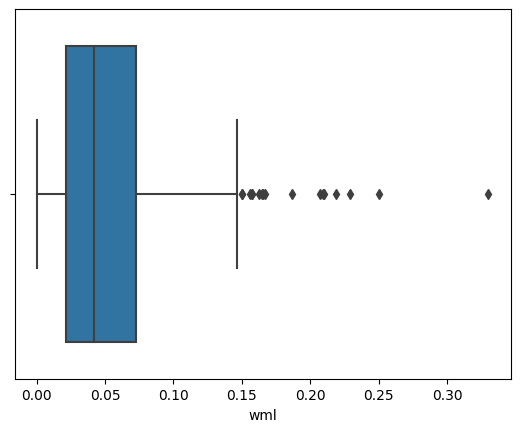

count      mean       std       min       25%       50%       75%  \
wml  412.0  0.053426  0.045516  0.000577  0.021416  0.041661  0.072495   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



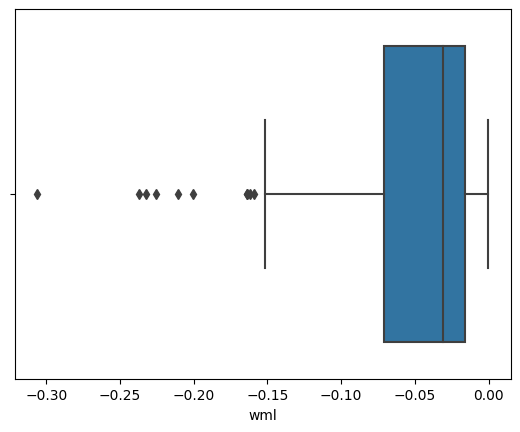

count      mean       std      min       25%       50%       75%  \
wml   96.0 -0.057327  0.063428 -0.30599 -0.070974 -0.031196 -0.015686   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



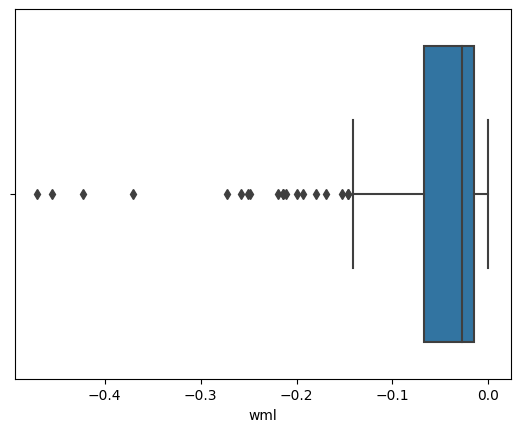

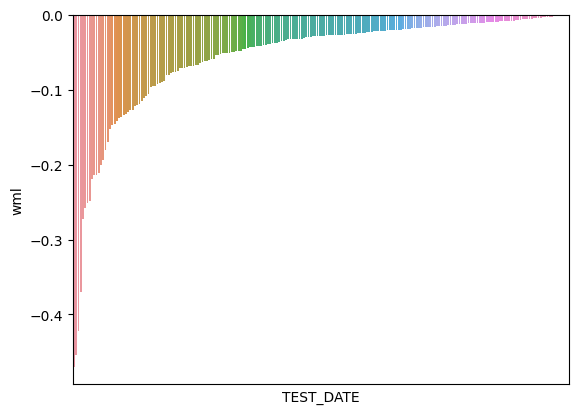

count      mean       std       min       25%       50%      75%  \
wml  220.0 -0.055868  0.074518 -0.469903 -0.066701 -0.028108 -0.01461   

          max  
wml -0.000183


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



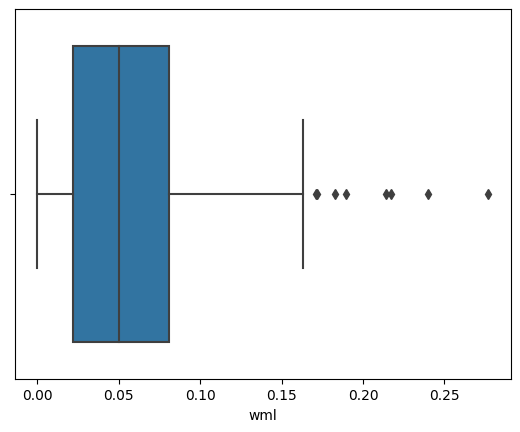

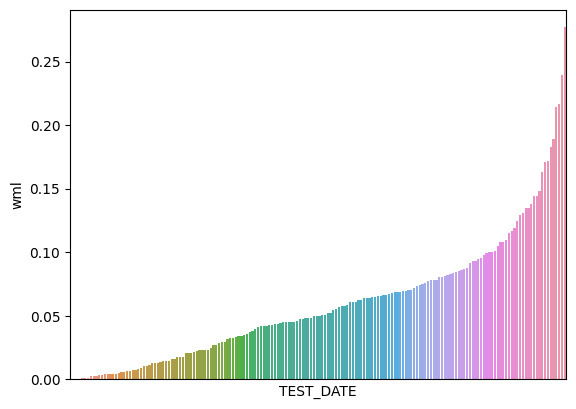

count      mean       std       min       25%       50%       75%  \
wml  178.0  0.059471  0.049555  0.000007  0.021976  0.050245  0.080737   

          max  
wml  0.276912

In [104]:
XGB_A0_P1, XGB_A1_P0 = What_Pred(Fixed_XGB_Result, WML, 'XGB')

Sharpe Ratio : 0.86430

최근 누적 수익률

  2022년-12월 -> 1990.87
  2022년-11월 -> 1793.64
  2022년-10월 -> 1706.08
  2022년-09월 -> 1706.08
  2022년-08월 -> 1706.08

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 4225.43
  2등 : 2009년-01월 -> 3762.35
  3등 : 2008년-11월 -> 3737.81
  4등 : 2008년-12월 -> 3649.31
  5등 : 2001년-09월 -> 3614.67
  6등 : 2000년-02월 -> 3592.73
  7등 : 2002년-07월 -> 3454.41
  8등 : 2008년-10월 -> 3408.48
  9등 : 2002년-09월 -> 3354.30
  10등 : 2002년-08월 -> 3354.30



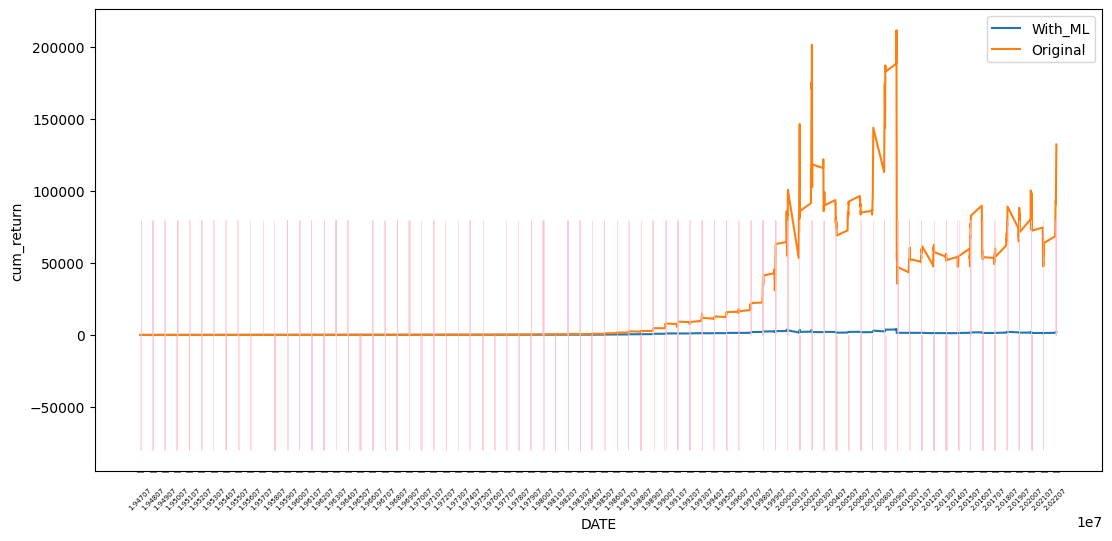

In [105]:
XGB_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_XGB_Result,
                                                 WML,
                                                 'XGB_PRED_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.82382

최근 누적 수익률

  2022년-12월 -> 2918.82
  2022년-11월 -> 2671.89
  2022년-10월 -> 2564.43
  2022년-09월 -> 2541.34
  2022년-08월 -> 2518.25

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 4498.78
  2등 : 2009년-01월 -> 4072.29
  3등 : 2008년-11월 -> 4052.20
  4등 : 2008년-12월 -> 3970.64
  5등 : 2008년-10월 -> 3757.78
  6등 : 2008년-09월 -> 3601.93
  7등 : 2008년-06월 -> 3490.88
  8등 : 2008년-07월 -> 3352.33
  9등 : 2008년-08월 -> 3308.09
  10등 : 2007년-12월 -> 3285.53



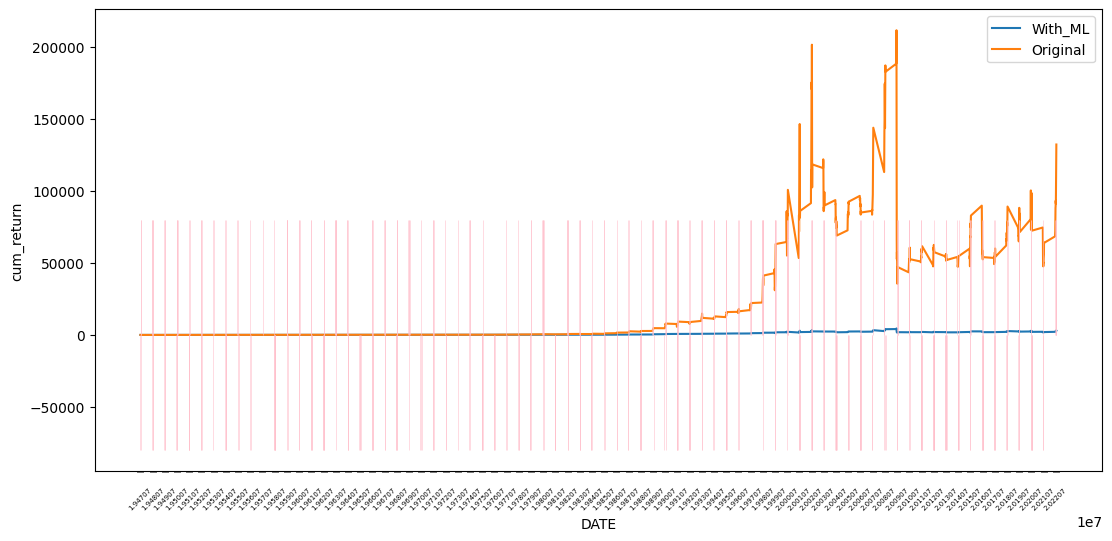

In [106]:
XGB_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_XGB_Result,
                                                 WML,
                                                 'XGB_PROB_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

### LGBM

In [107]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

**************************************************

LGBM Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.19      0.24       316
         1.0       0.65      0.79      0.71       590

    accuracy                           0.58       906
   macro avg       0.49      0.49      0.48       906
weighted avg       0.54      0.58      0.55       906


accuracy : 0.5827814569536424

precision : 0.646814404432133

recall : 0.7915254237288135

F1-Score : 0.7118902439024392



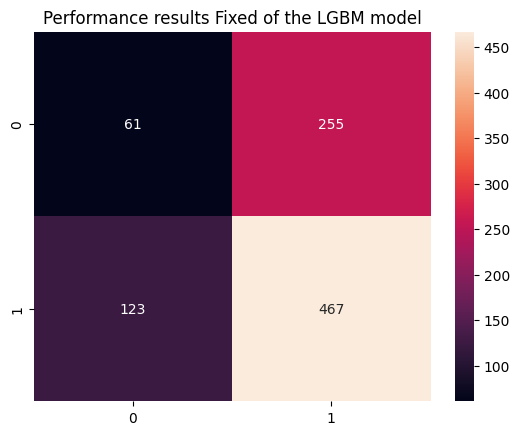


Feature Importance of the model



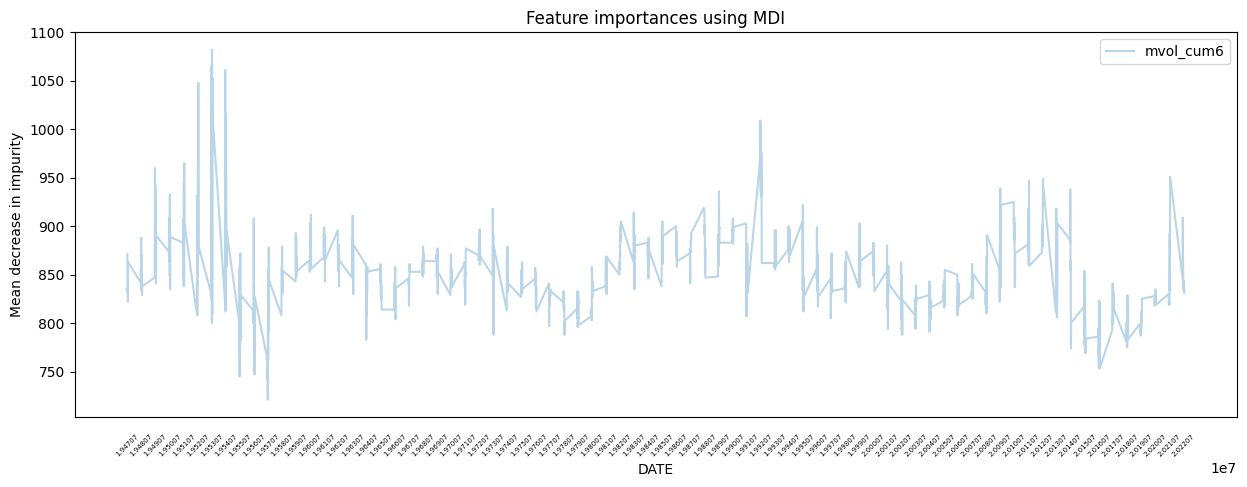

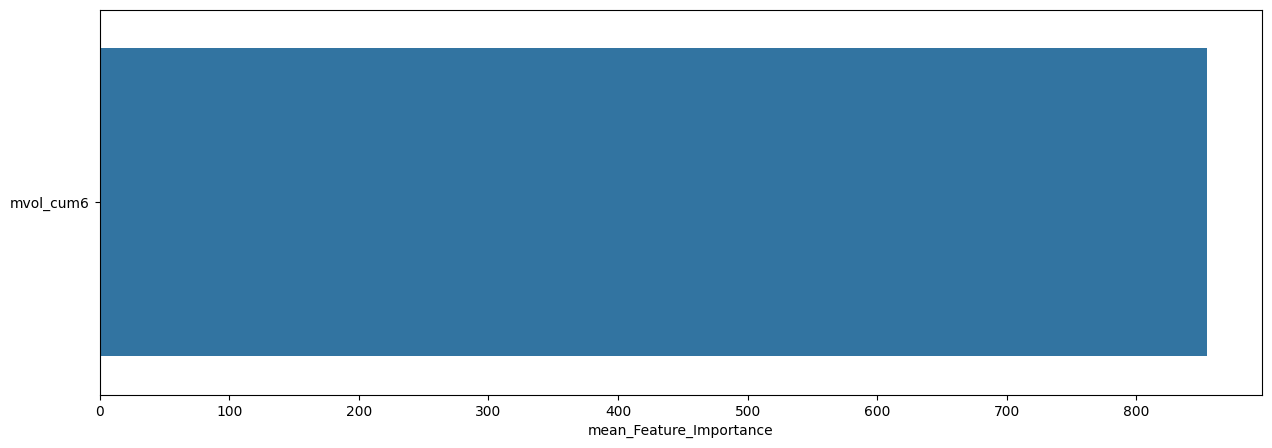

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6               854.210817                    1082   

           min_Feature_Importance  
mvol_cum6                     721

In [108]:
Fixed_LGBM_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                    window_size=240, # window size (훈련 데이터 셋 크기)
                                    method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                    model=LGBM, # 사용할 모델
                                    model_name='LGBM', # 사용한 모델 명
                                    plot=True, # 모델 성능 지표 시각화 여부
                                    plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.28      0.20      0.23        75
         1.0       0.65      0.75      0.70       151

    accuracy                           0.57       226
   macro avg       0.47      0.47      0.47       226
weighted avg       0.53      0.57      0.54       226


accuracy : 0.5663716814159292

precision : 0.653179190751445

recall : 0.7483443708609272

F1-Score : 0.6975308641975309



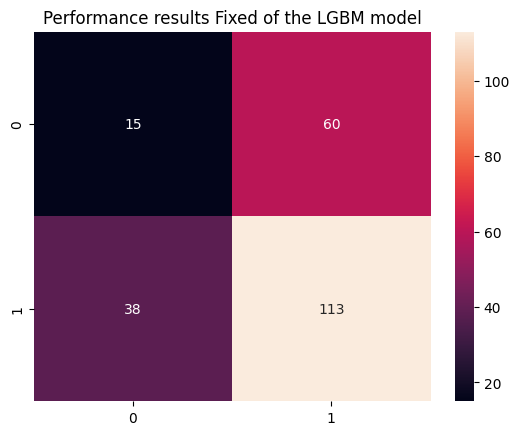


Feature Importance of the model



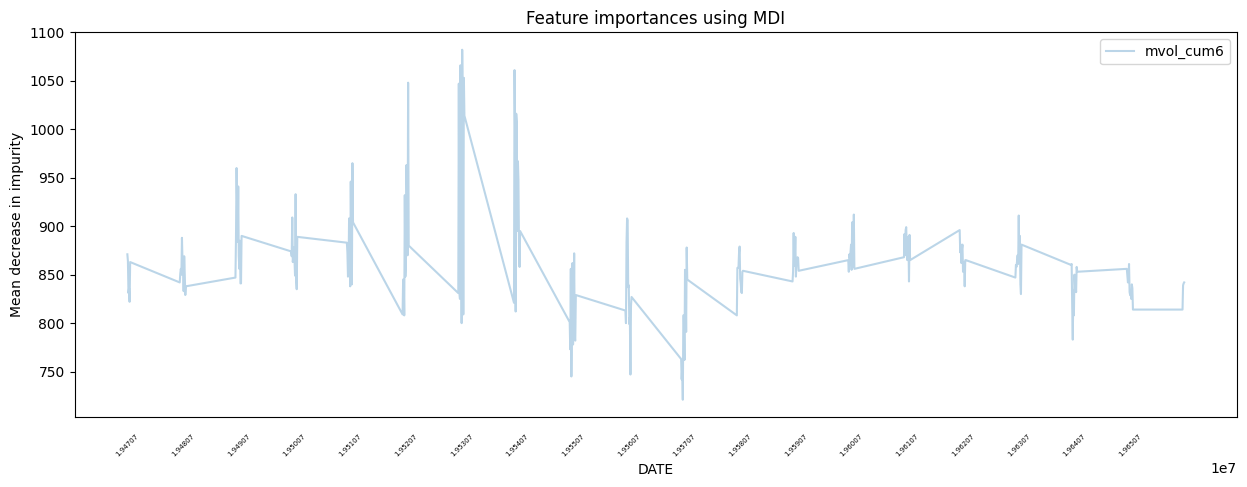

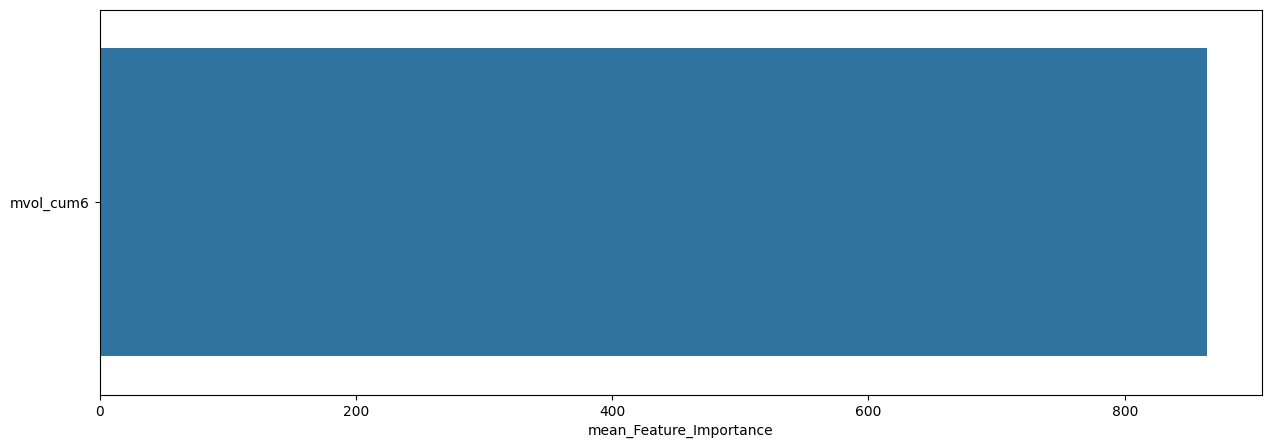

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6               863.946903                    1082   

           min_Feature_Importance  
mvol_cum6                     721


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.21      0.26        75
         1.0       0.67      0.78      0.72       151

    accuracy                           0.59       226
   macro avg       0.50      0.50      0.49       226
weighted avg       0.55      0.59      0.57       226


accuracy : 0.5929203539823009

precision : 0.6666666666666666

recall : 0.7814569536423841

F1-Score : 0.7195121951219513



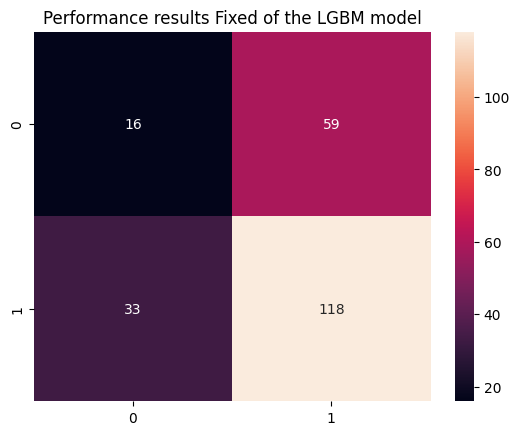


Feature Importance of the model



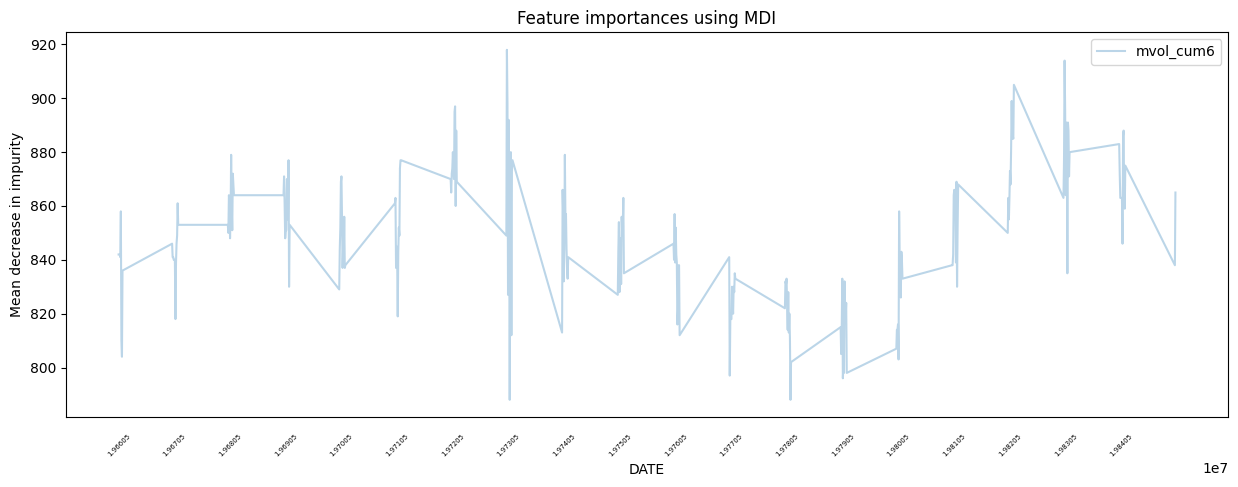

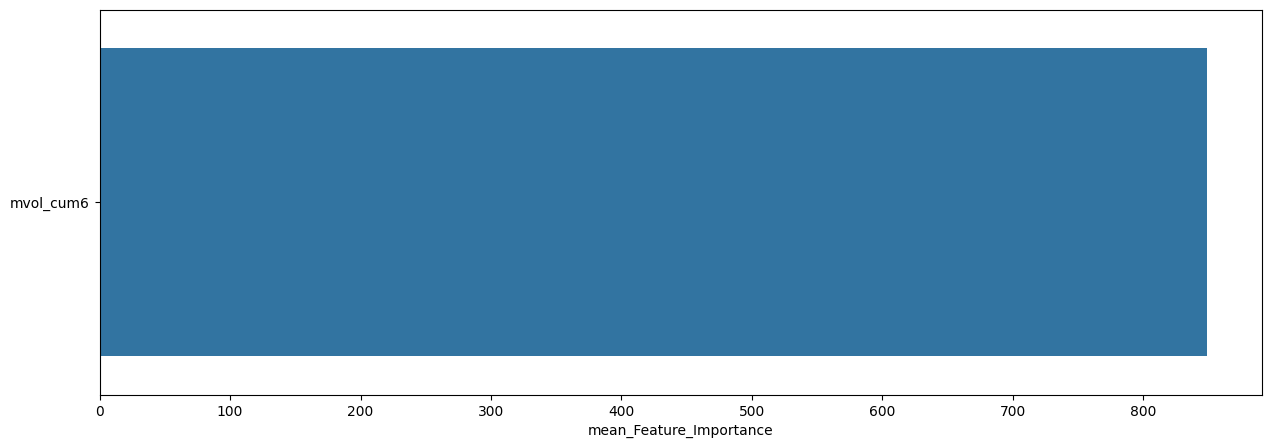

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6               848.668142                     918   

           min_Feature_Importance  
mvol_cum6                     788


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.23      0.28        70
         1.0       0.70      0.83      0.76       156

    accuracy                           0.64       226
   macro avg       0.54      0.53      0.52       226
weighted avg       0.60      0.64      0.61       226


accuracy : 0.6415929203539823

precision : 0.7049180327868853

recall : 0.8269230769230769

F1-Score : 0.7610619469026548



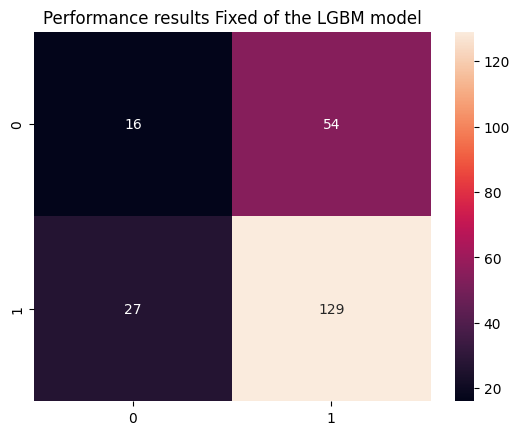


Feature Importance of the model



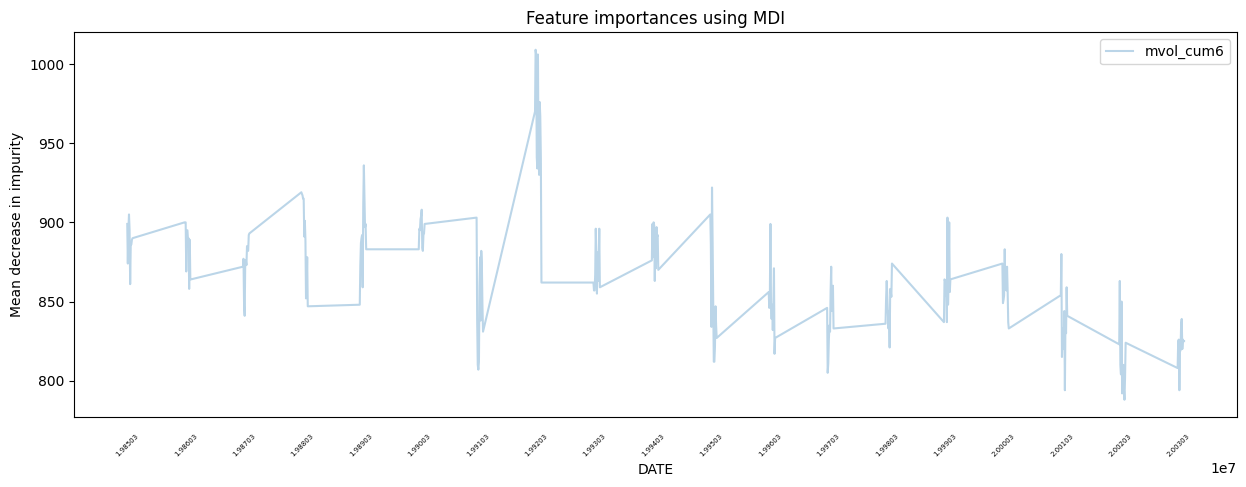

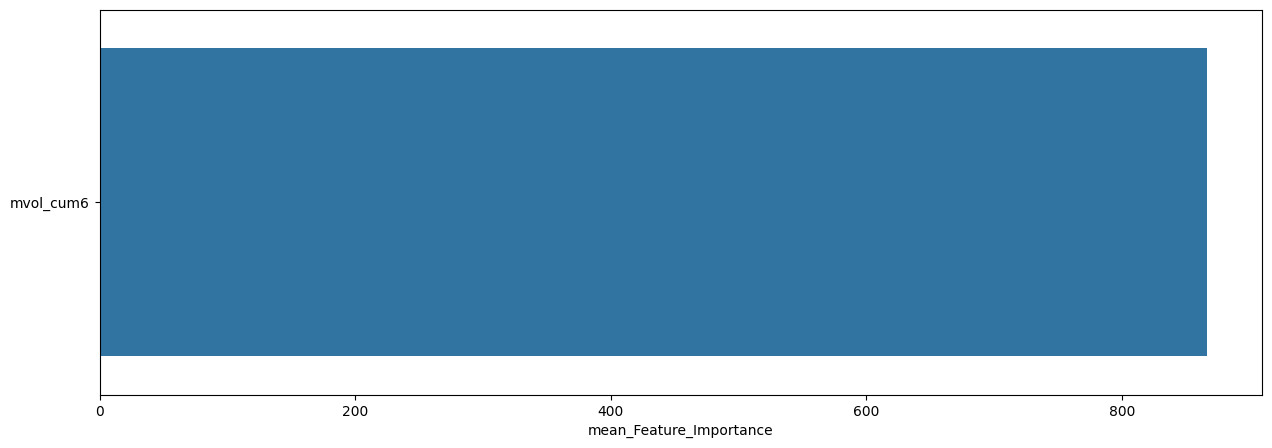

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6               866.504425                    1009   

           min_Feature_Importance  
mvol_cum6                     788


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.15      0.21        96
         1.0       0.57      0.81      0.67       132

    accuracy                           0.53       228
   macro avg       0.46      0.48      0.44       228
weighted avg       0.48      0.53      0.47       228


accuracy : 0.5307017543859649

precision : 0.5661375661375662

recall : 0.8106060606060606

F1-Score : 0.6666666666666667



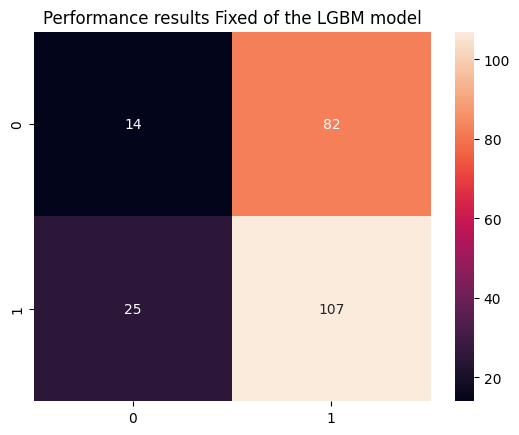


Feature Importance of the model



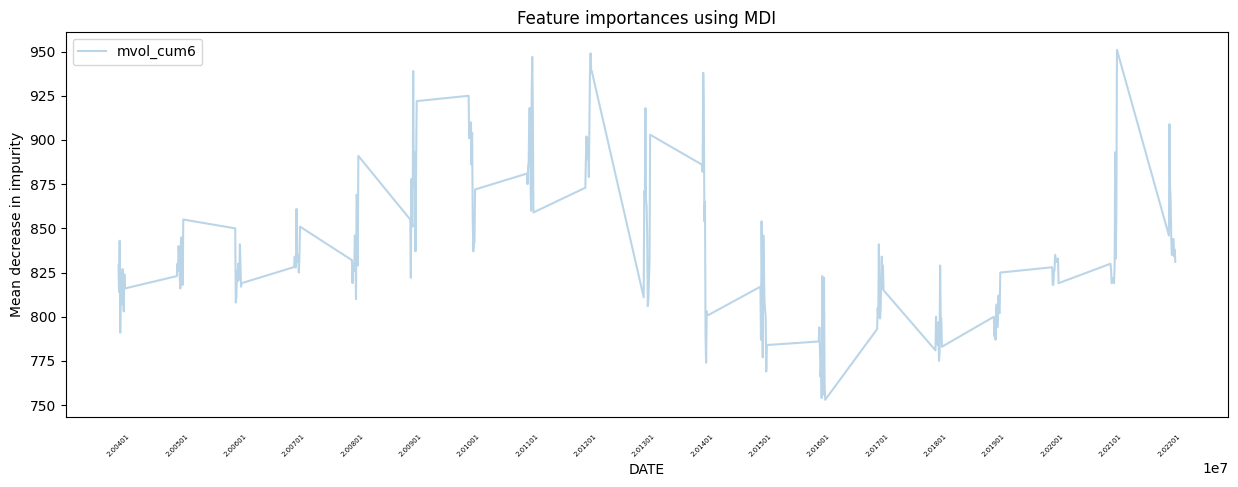

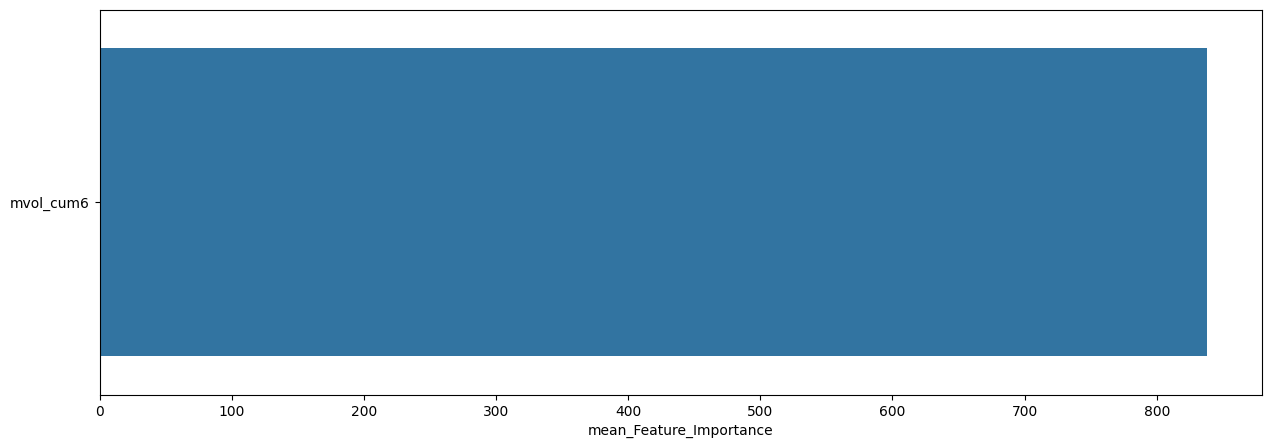

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6               837.868421                     951   

           min_Feature_Importance  
mvol_cum6                     753

In [109]:
slice_feature_importance(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                        4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                        'Fixed', # Rolling Windows Method
                        'LGBM') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



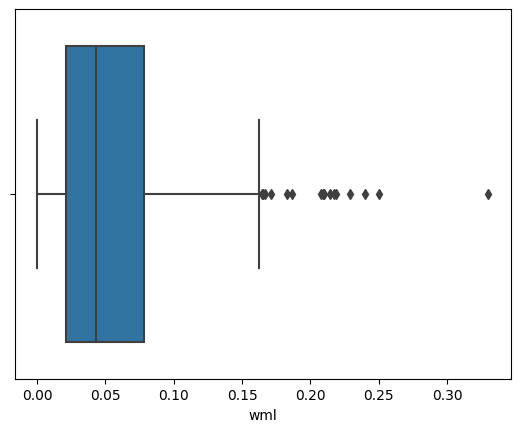

count      mean       std       min      25%       50%       75%  \
wml  467.0  0.055699  0.047757  0.000221  0.02098  0.042855  0.078057   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



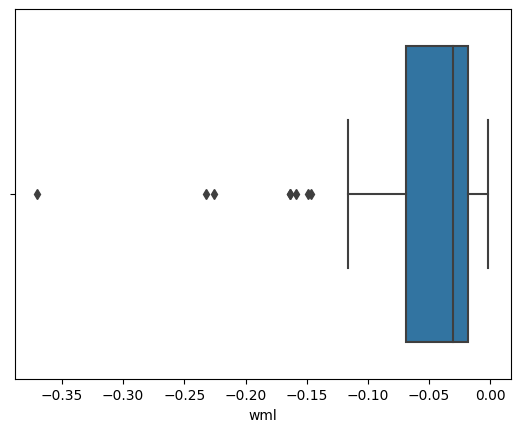

count      mean       std       min       25%       50%       75%  \
wml   61.0 -0.056576  0.067095 -0.370041 -0.068943 -0.030127 -0.017886   

          max  
wml -0.001641


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



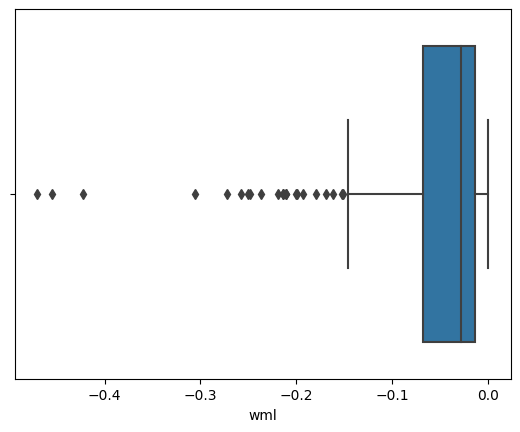

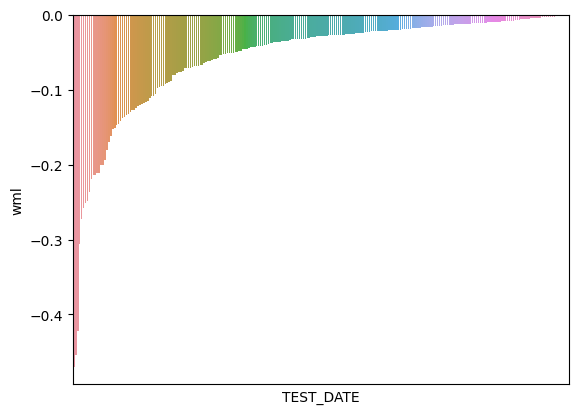

count      mean       std       min       25%       50%       75%  \
wml  255.0 -0.056248  0.072317 -0.469903 -0.067748 -0.028532 -0.014033   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



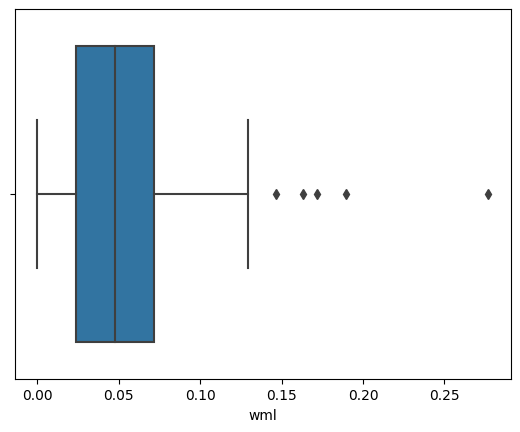

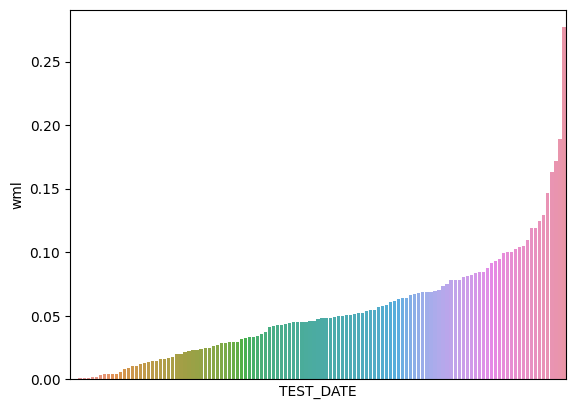

count      mean       std       min       25%       50%       75%  \
wml  123.0  0.053545  0.043175  0.000007  0.023418  0.047411  0.071887   

          max  
wml  0.276912

In [110]:
LGBM_A0_P1, LGBM_A1_P0 = What_Pred(Fixed_LGBM_Result,
                                   WML,
                                   'LGBM')

Sharpe Ratio : 0.69086

최근 누적 수익률

  2022년-12월 -> 9903.28
  2022년-11월 -> 8922.59
  2022년-10월 -> 8922.59
  2022년-09월 -> 8922.59
  2022년-08월 -> 8922.59

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 27869.18
  2등 : 2009년-01월 -> 24815.54
  3등 : 2008년-11월 -> 24653.68
  4등 : 2008년-12월 -> 24070.13
  5등 : 2008년-10월 -> 22482.01
  6등 : 2008년-09월 -> 21224.41
  7등 : 2007년-12월 -> 20200.03
  8등 : 2008년-07월 -> 19222.34
  9등 : 2008년-06월 -> 19222.34
  10등 : 2008년-08월 -> 18919.00



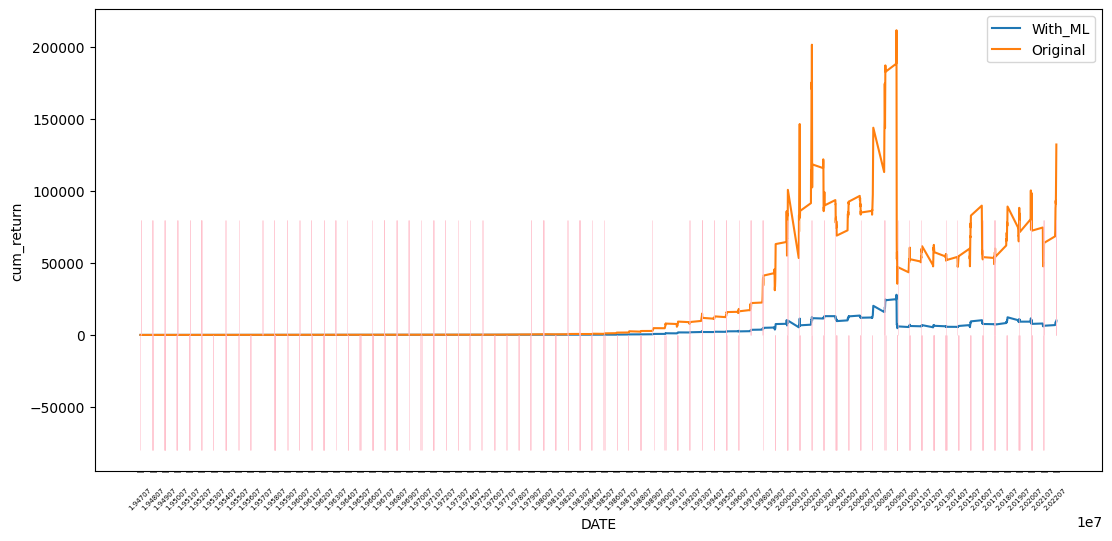

In [111]:
LGBM_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PRED_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

Sharpe Ratio : 0.77913

최근 누적 수익률

  2022년-12월 -> 3676.16
  2022년-11월 -> 3469.89
  2022년-10월 -> 3388.64
  2022년-09월 -> 3316.23
  2022년-08월 -> 3208.31

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 5710.06
  2등 : 2009년-01월 -> 5273.51
  3등 : 2008년-11월 -> 5252.25
  4등 : 2008년-12월 -> 5164.92
  5등 : 2008년-10월 -> 4932.37
  6등 : 2008년-06월 -> 4772.02
  7등 : 2008년-09월 -> 4740.99
  8등 : 2002년-09월 -> 4610.12
  9등 : 2007년-12월 -> 4468.57
  10등 : 2008년-07월 -> 4443.04



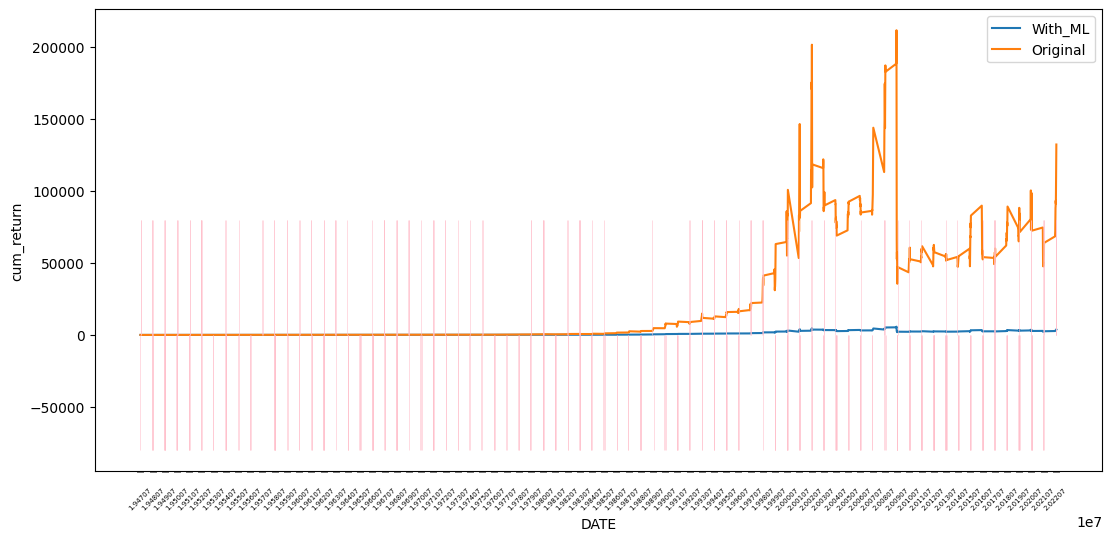

In [112]:
LGBM_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PROB_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

## Rolling Expanding Windows

### Random Forest

In [113]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

**************************************************

RDF Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.41      0.39       316
         1.0       0.67      0.65      0.66       590

    accuracy                           0.56       906
   macro avg       0.53      0.53      0.53       906
weighted avg       0.57      0.56      0.57       906


accuracy : 0.5640176600441501

precision : 0.670753064798599

recall : 0.6491525423728813

F1-Score : 0.6597760551248923



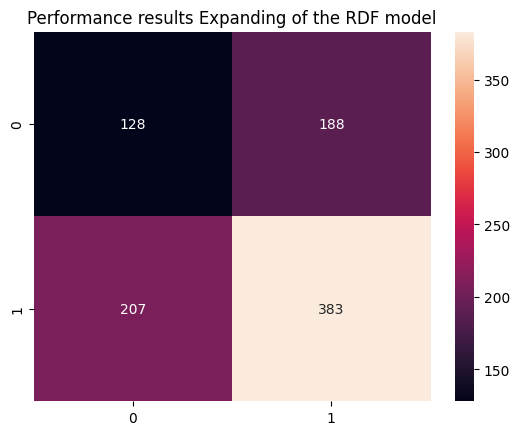


Feature Importance of the model



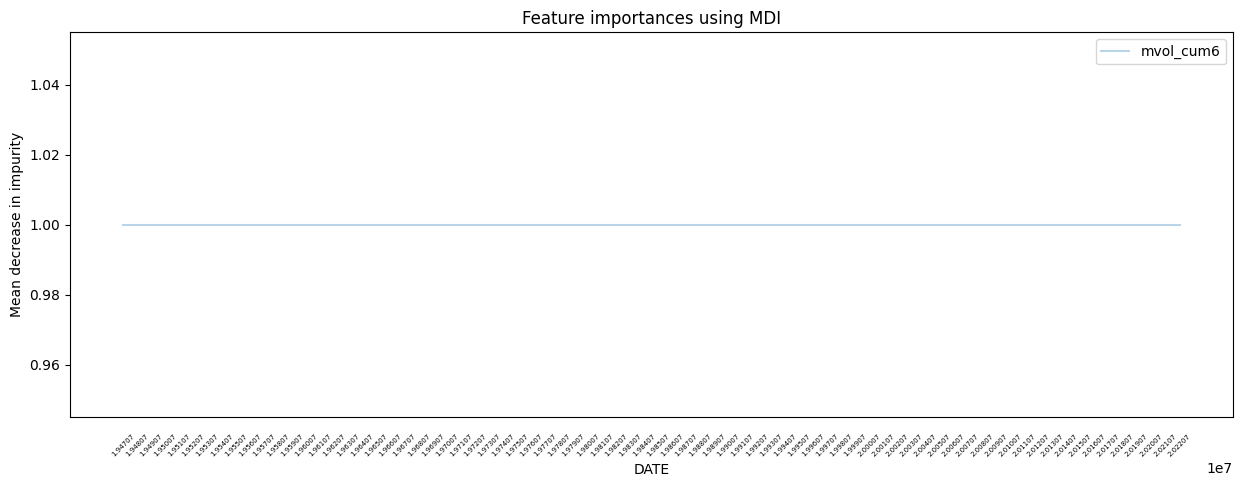

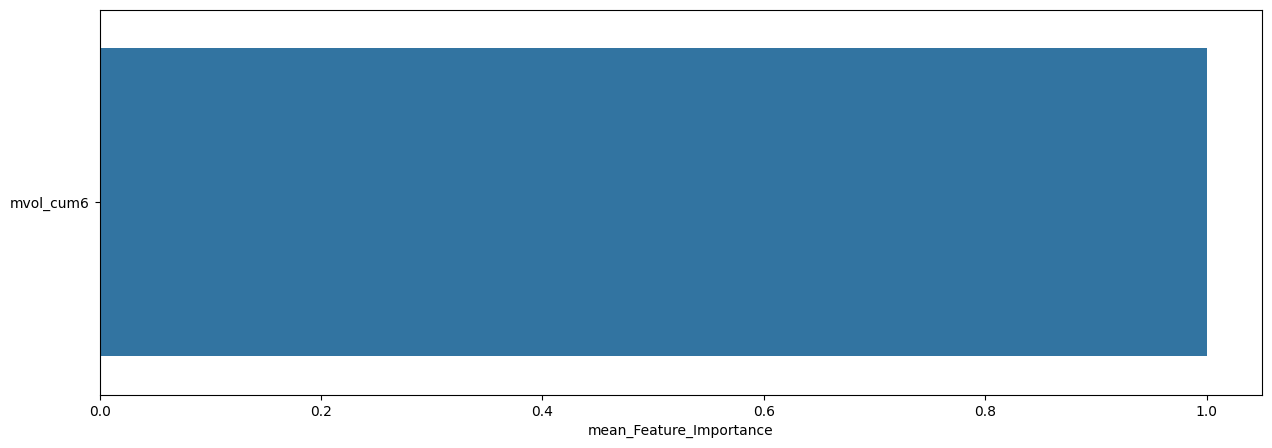

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0

In [114]:
Expanding_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                      window_size=240, # window size (훈련 데이터 셋 크기)
                                      method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                      model=RDF, # 사용할 모델
                                      model_name='RDF', # 사용한 모델 명
                                      plot=True, # 모델 성능 지표 시각화 여부
                                      plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.39      0.36        75
         1.0       0.68      0.64      0.66       151

    accuracy                           0.55       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.57      0.55      0.56       226


accuracy : 0.5530973451327433

precision : 0.676056338028169

recall : 0.6357615894039735

F1-Score : 0.6552901023890785



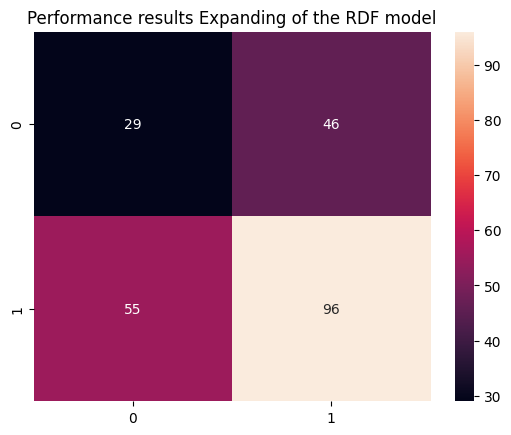


Feature Importance of the model



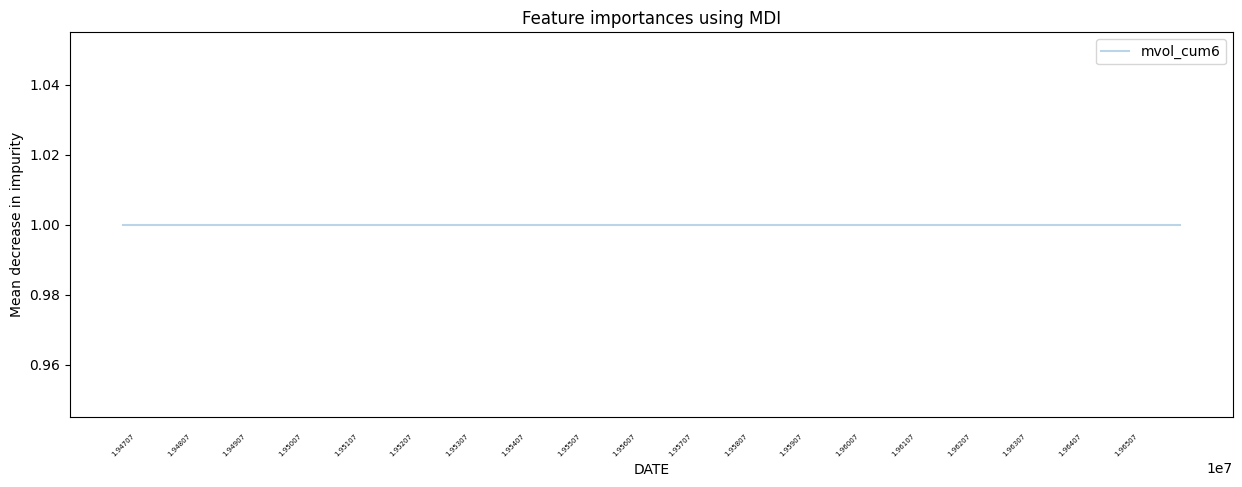

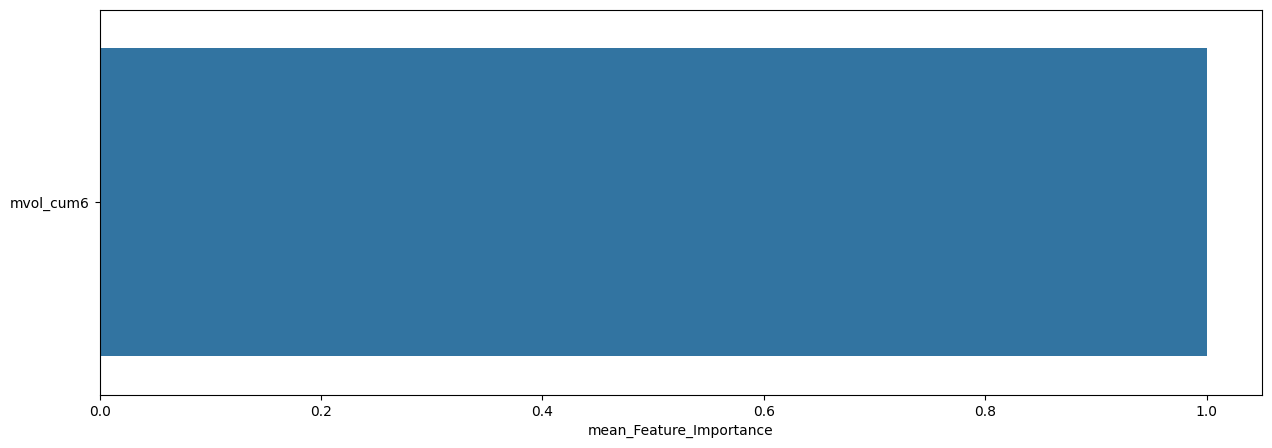

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.39      0.38        75
         1.0       0.69      0.68      0.68       151

    accuracy                           0.58       226
   macro avg       0.53      0.53      0.53       226
weighted avg       0.58      0.58      0.58       226


accuracy : 0.5796460176991151

precision : 0.6891891891891891

recall : 0.6754966887417219

F1-Score : 0.6822742474916388



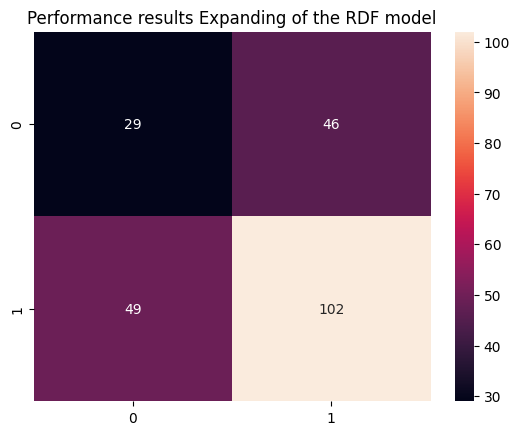


Feature Importance of the model



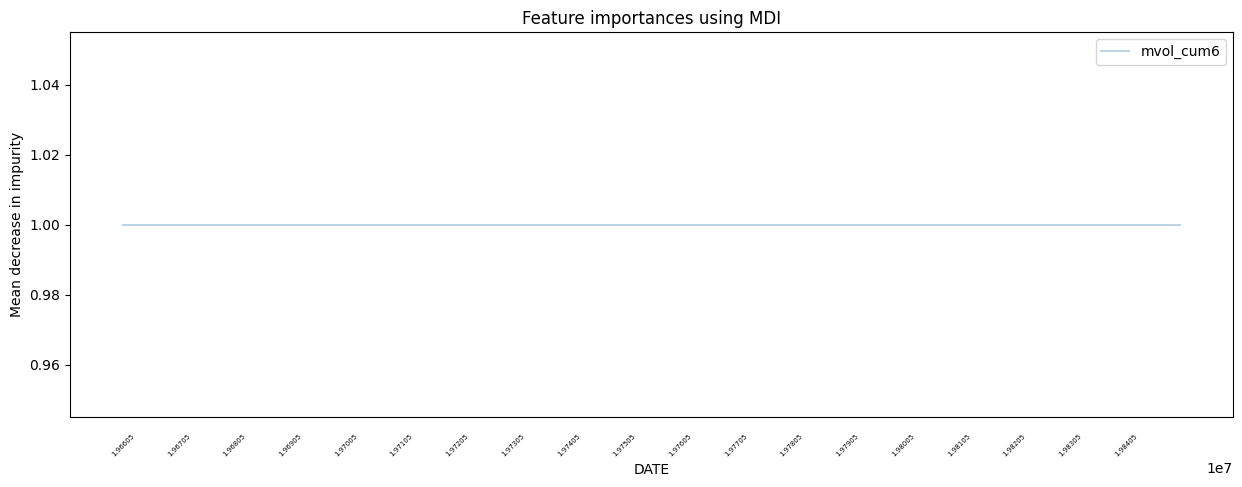

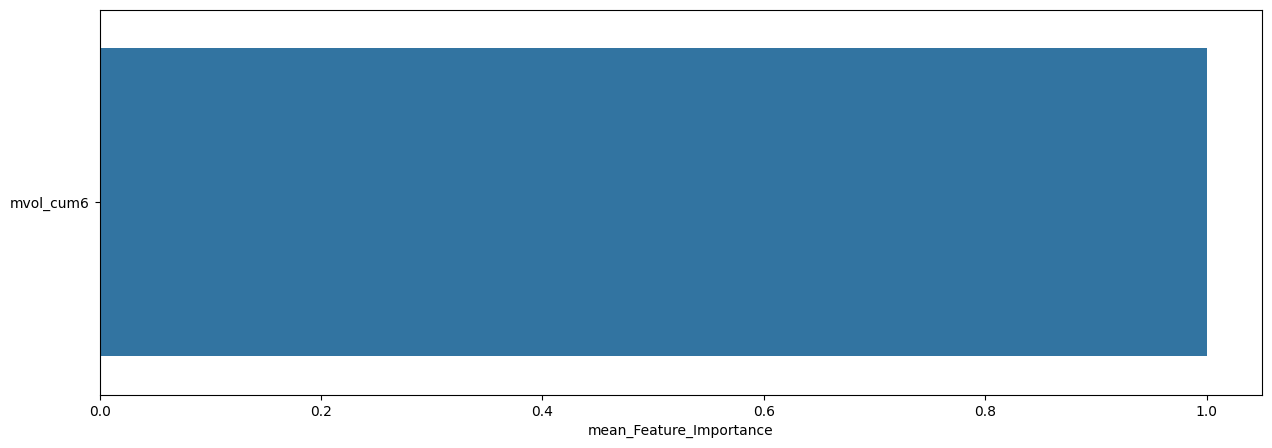

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.39      0.35        70
         1.0       0.70      0.64      0.67       156

    accuracy                           0.56       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.58      0.56      0.57       226


accuracy : 0.5619469026548672

precision : 0.6993006993006993

recall : 0.6410256410256411

F1-Score : 0.6688963210702341



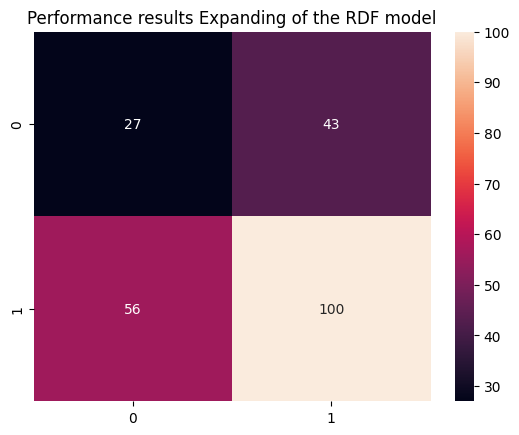


Feature Importance of the model



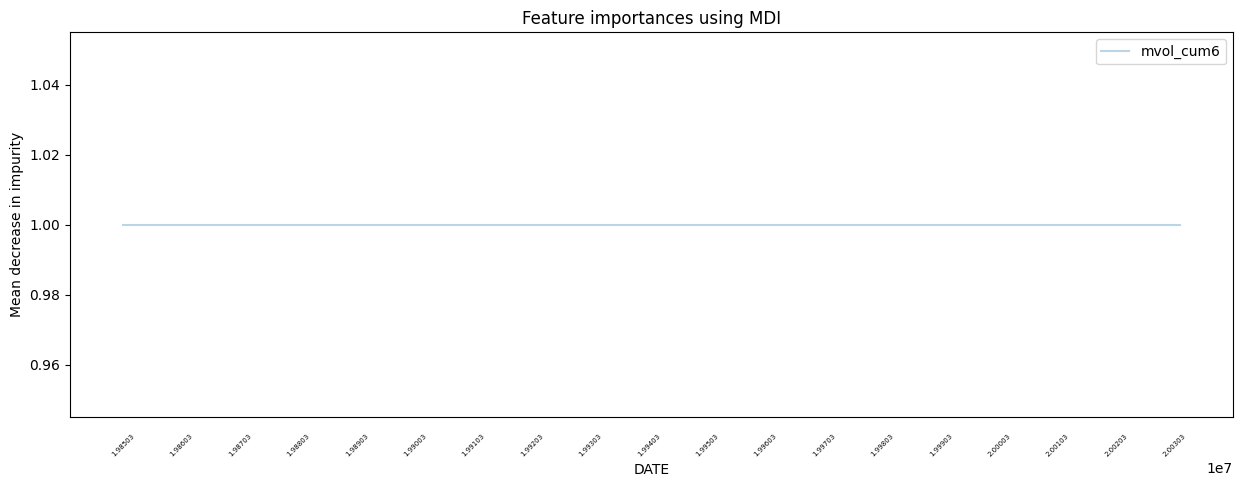

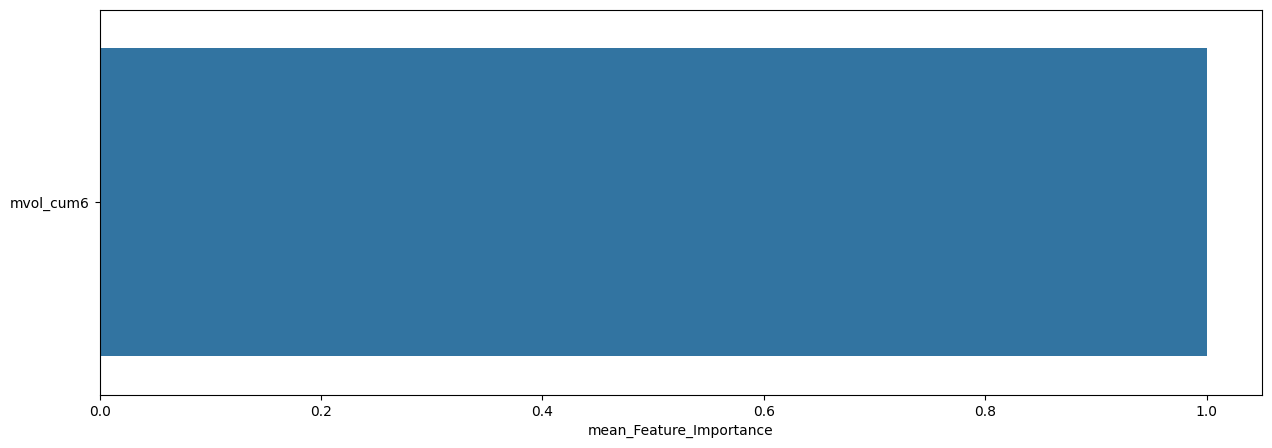

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.48      0.45      0.46        96
         1.0       0.62      0.64      0.63       132

    accuracy                           0.56       228
   macro avg       0.55      0.55      0.55       228
weighted avg       0.56      0.56      0.56       228


accuracy : 0.5614035087719298

precision : 0.6159420289855072

recall : 0.6439393939393939

F1-Score : 0.6296296296296297



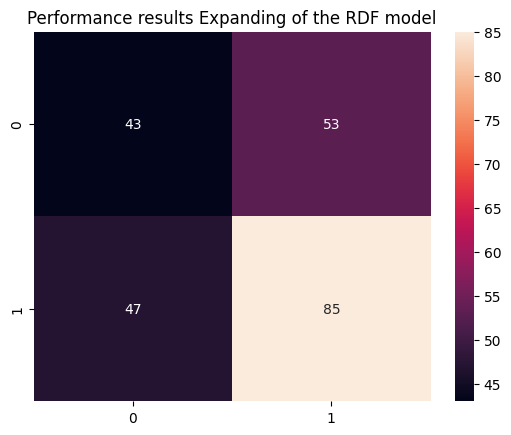


Feature Importance of the model



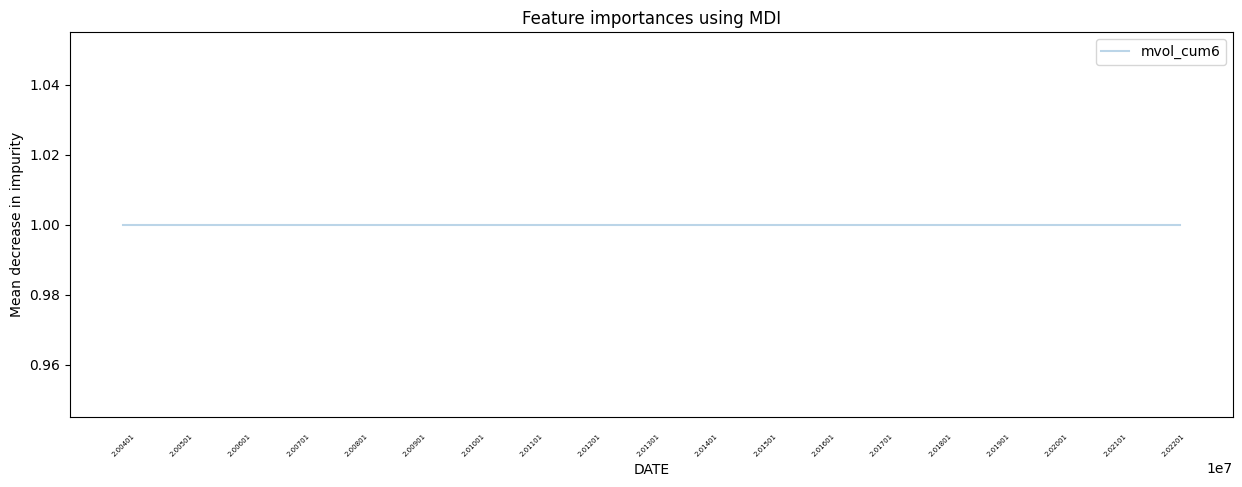

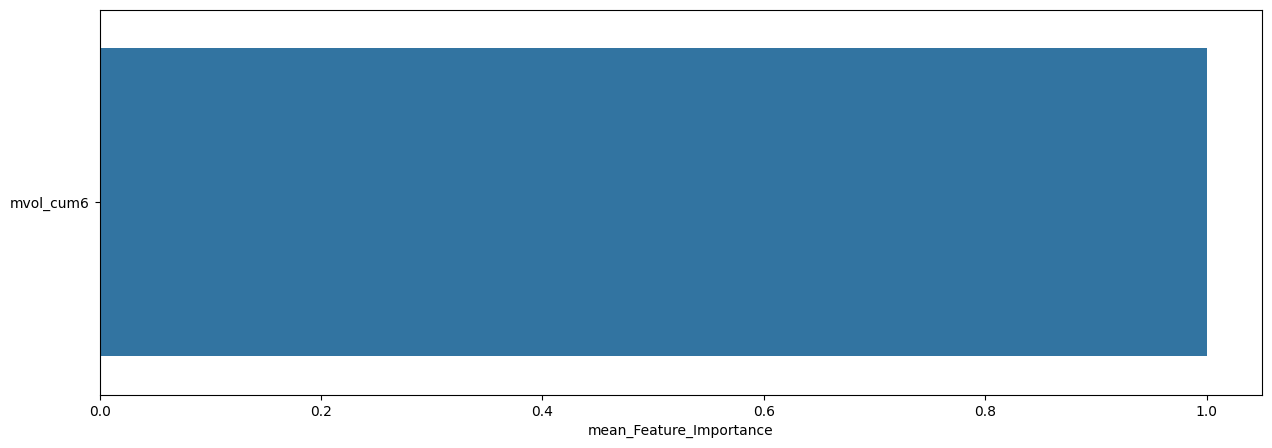

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0

In [115]:
slice_feature_importance(Expanding_RDF_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'RDF') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



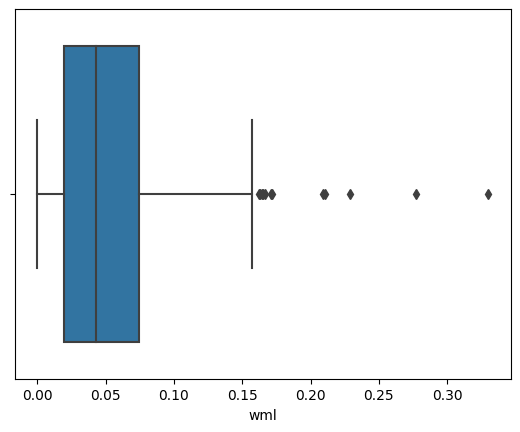

count      mean       std       min       25%       50%       75%  \
wml  383.0  0.053847  0.046309  0.000007  0.019574  0.042733  0.074723   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



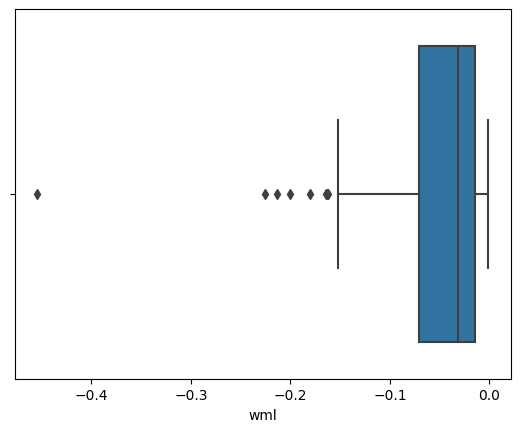

count      mean       std       min       25%       50%      75%  \
wml  128.0 -0.054843  0.062466 -0.454349 -0.071066 -0.031713 -0.01413   

          max  
wml -0.001073


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



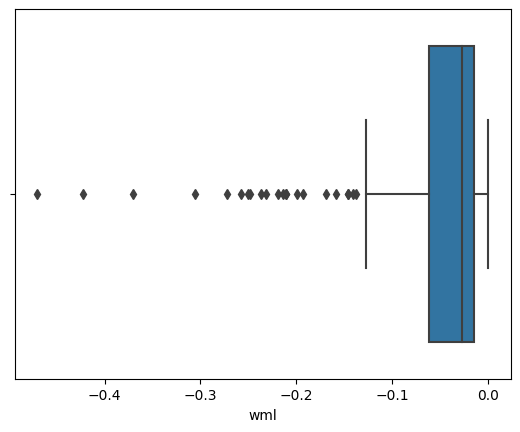

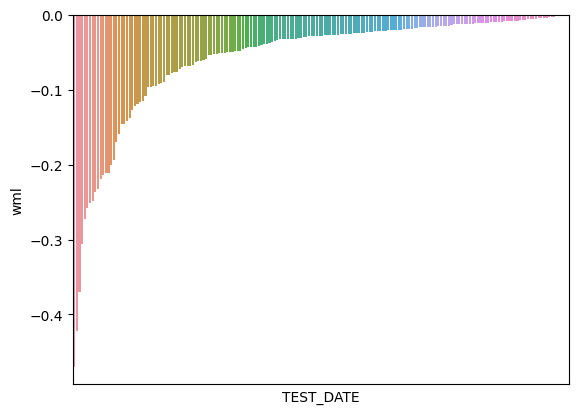

count      mean       std       min       25%      50%       75%  \
wml  188.0 -0.057311  0.076781 -0.469903 -0.061534 -0.02771 -0.014988   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



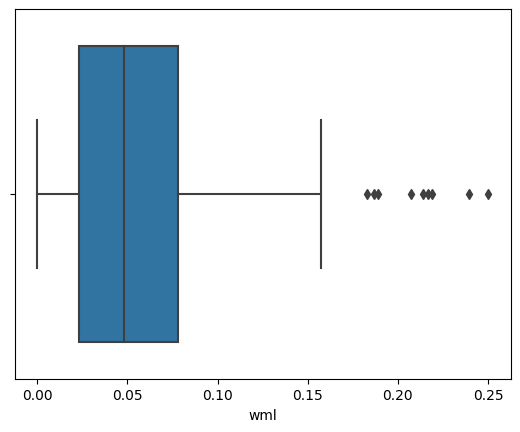

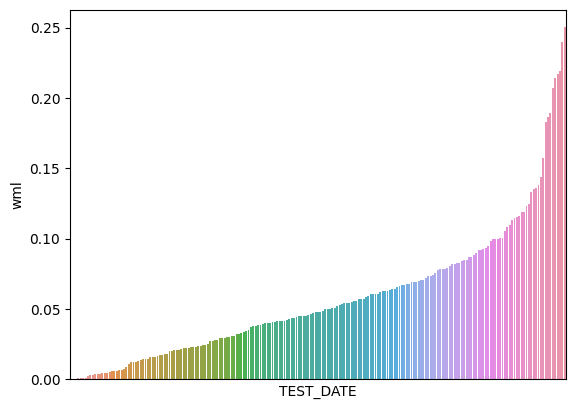

count      mean       std       min       25%       50%       75%  \
wml  207.0  0.057845  0.047731  0.000128  0.023203  0.048058  0.078207   

          max  
wml  0.250175

In [116]:
RDF_A0_P1, RDF_A1_P0 = What_Pred(Expanding_RDF_Result, WML, 'RDF')

Sharpe Ratio : 0.80244

최근 누적 수익률

  2022년-12월 -> 2684.92
  2022년-11월 -> 2418.97
  2022년-10월 -> 2300.90
  2022년-09월 -> 2037.30
  2022년-08월 -> 2037.30

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2001년-09월 -> 3552.52
  2등 : 2001년-08월 -> 3552.52
  3등 : 2000년-05월 -> 3539.50
  4등 : 2000년-03월 -> 3539.50
  5등 : 2000년-06월 -> 3539.50
  6등 : 2000년-02월 -> 3539.50
  7등 : 2000년-04월 -> 3539.50
  8등 : 2000년-07월 -> 3526.36
  9등 : 2000년-08월 -> 3526.36
  10등 : 2000년-09월 -> 3526.36



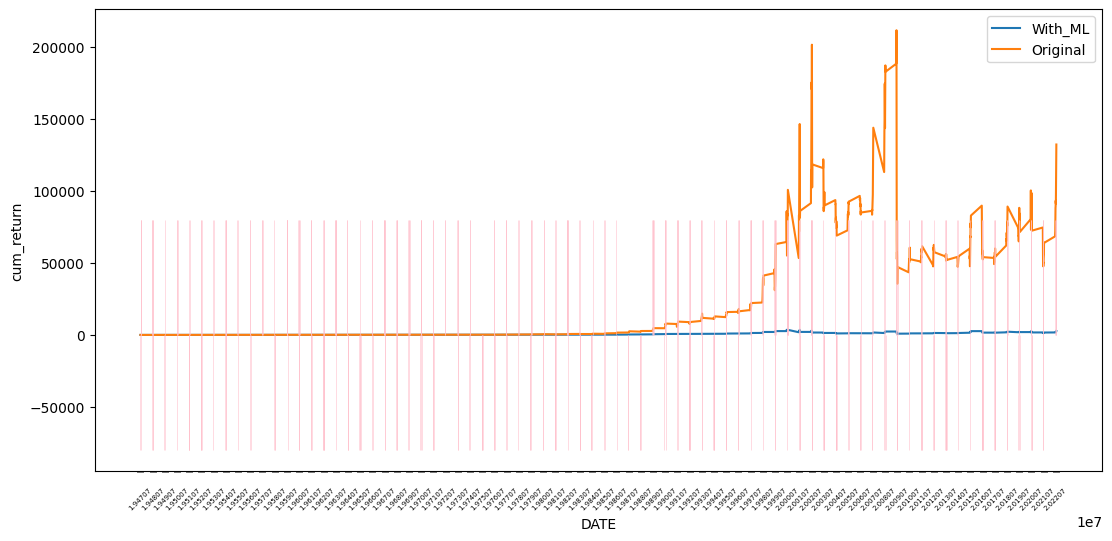

In [117]:
RDF_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_RDF_Result,
                                                 WML,
                                                 'RDF_PRED_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.81286

최근 누적 수익률

  2022년-12월 -> 2874.25
  2022년-11월 -> 2605.04
  2022년-10월 -> 2512.22
  2022년-09월 -> 2322.89
  2022년-08월 -> 2244.36

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 2874.25
  2등 : 2009년-02월 -> 2659.71
  3등 : 2020년-03월 -> 2624.08
  4등 : 2022년-11월 -> 2605.04
  5등 : 2008년-11월 -> 2556.57
  6등 : 2009년-01월 -> 2528.96
  7등 : 2022년-10월 -> 2512.22
  8등 : 2008년-12월 -> 2497.25
  9등 : 2020년-09월 -> 2482.45
  10등 : 2020년-10월 -> 2479.28



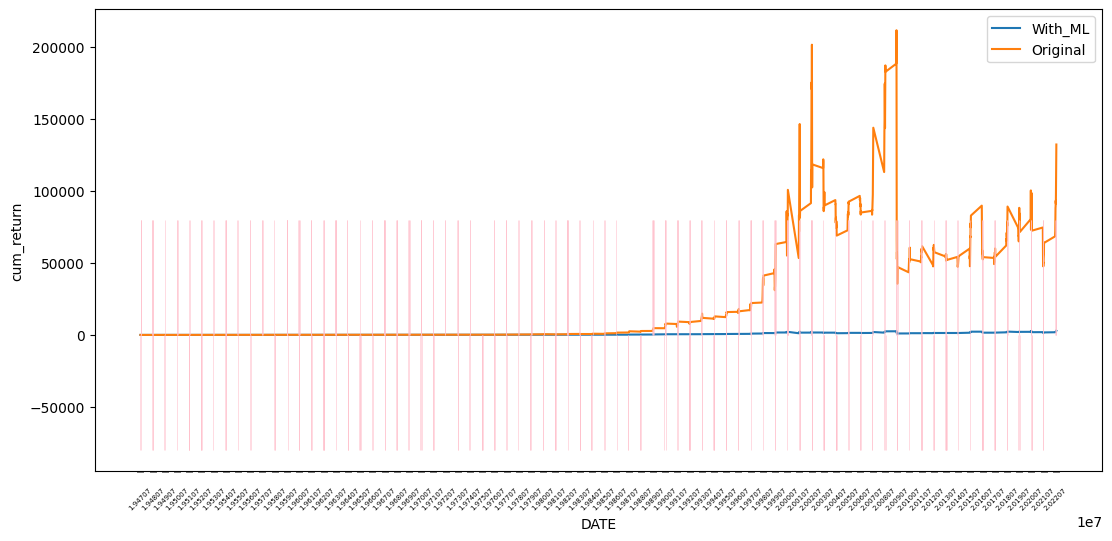

In [118]:
RDF_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_RDF_Result,
                                                 WML,
                                                 'RDF_PROB_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

### Grdient Boosting

In [119]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

**************************************************

GBC Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.40      0.22      0.28       316
         1.0       0.66      0.83      0.74       590

    accuracy                           0.61       906
   macro avg       0.53      0.52      0.51       906
weighted avg       0.57      0.61      0.58       906


accuracy : 0.6136865342163356

precision : 0.6634877384196185

recall : 0.8254237288135593

F1-Score : 0.7356495468277945



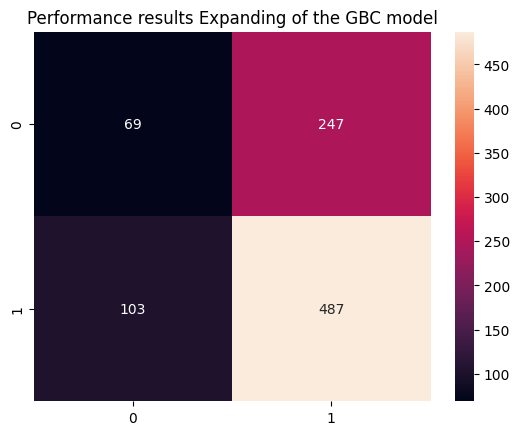


Feature Importance of the model



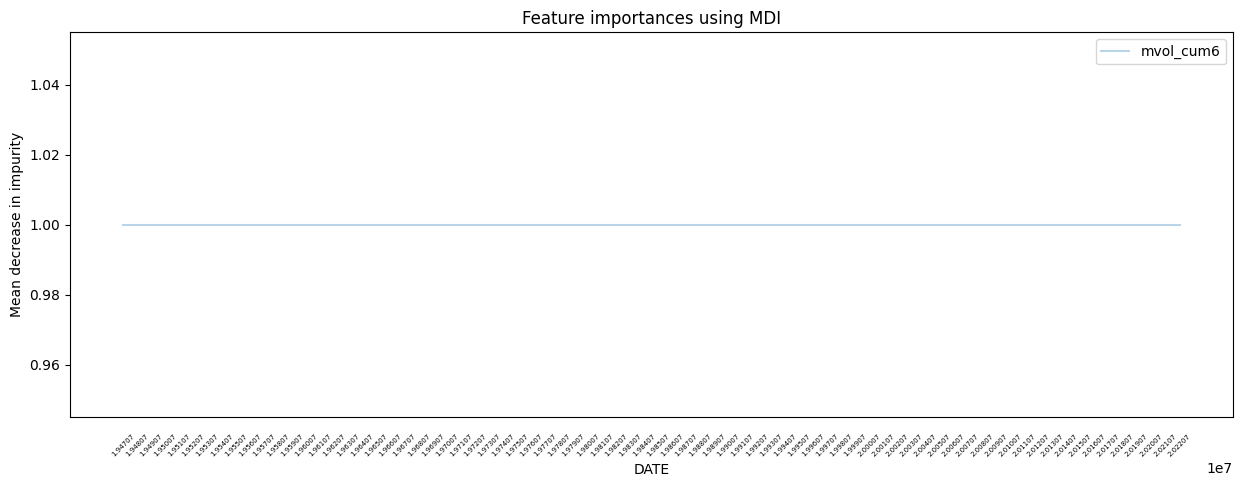

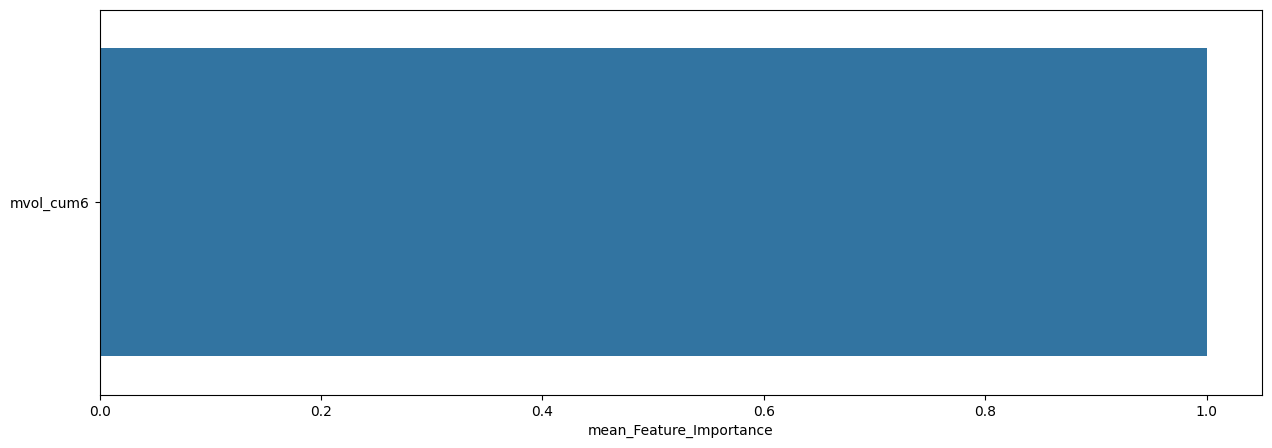

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0

In [120]:
Expanding_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                      window_size=240, # window size (훈련 데이터 셋 크기)
                                      method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                      model=GBC, # 사용할 모델
                                      model_name='GBC', # 사용한 모델 명
                                      plot=True, # 모델 성능 지표 시각화 여부
                                      plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.24      0.28        75
         1.0       0.67      0.77      0.72       151

    accuracy                           0.59       226
   macro avg       0.51      0.50      0.50       226
weighted avg       0.56      0.59      0.57       226


accuracy : 0.5929203539823009

precision : 0.6705202312138728

recall : 0.7682119205298014

F1-Score : 0.7160493827160493



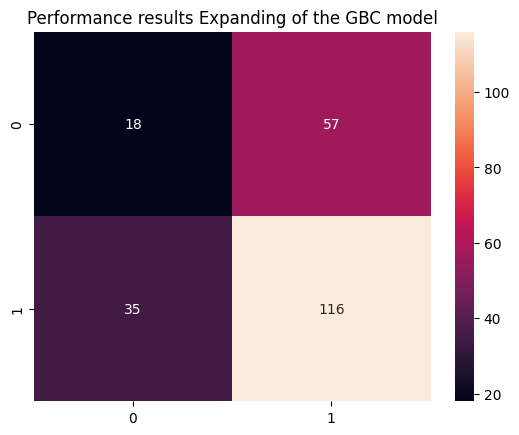


Feature Importance of the model



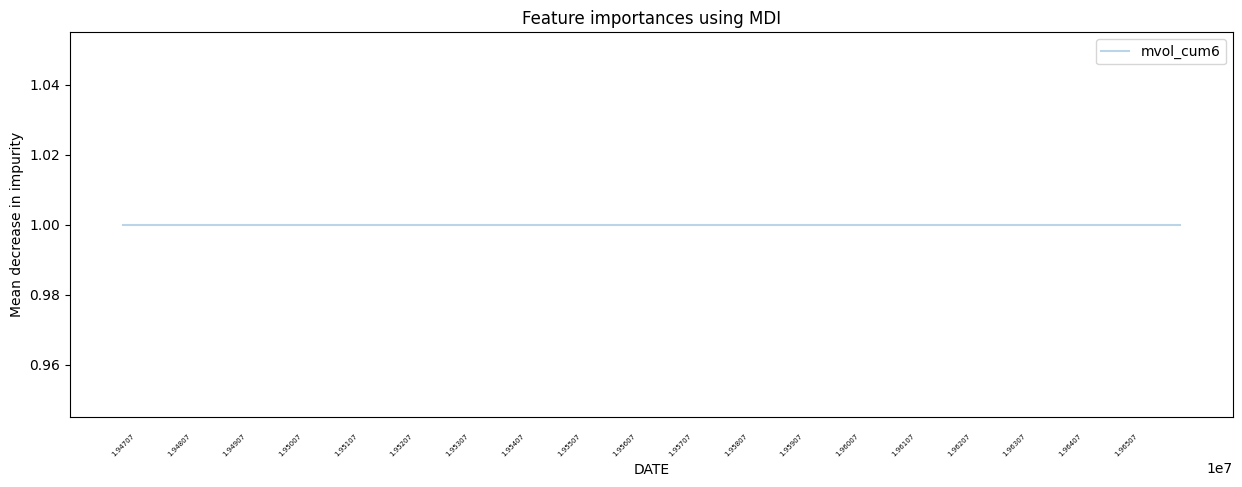

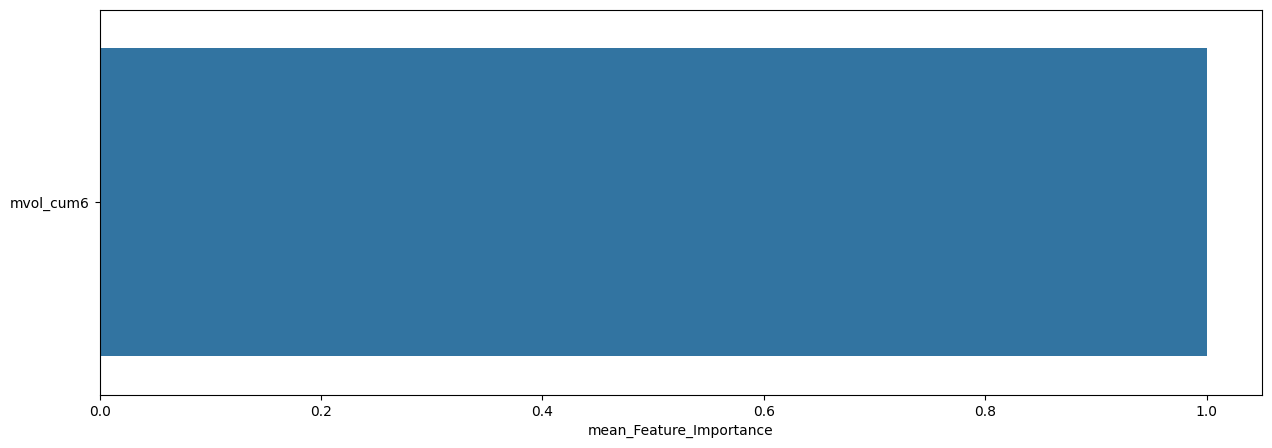

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.17      0.24        75
         1.0       0.68      0.86      0.76       151

    accuracy                           0.63       226
   macro avg       0.53      0.52      0.50       226
weighted avg       0.58      0.63      0.59       226


accuracy : 0.6327433628318584

precision : 0.6770833333333334

recall : 0.8609271523178808

F1-Score : 0.7580174927113703



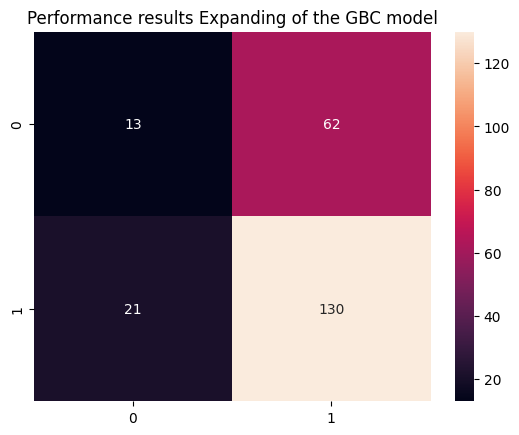


Feature Importance of the model



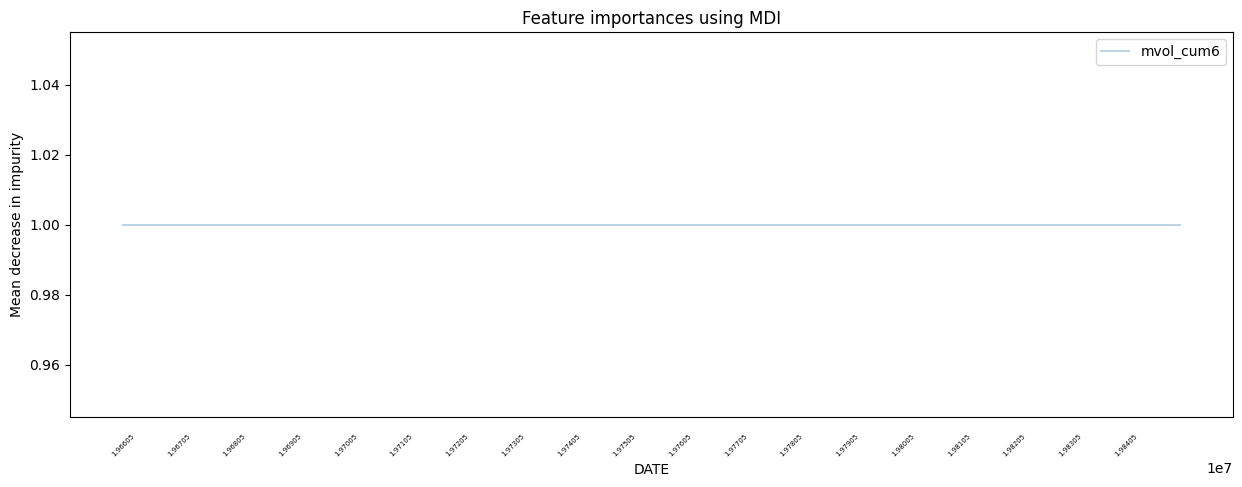

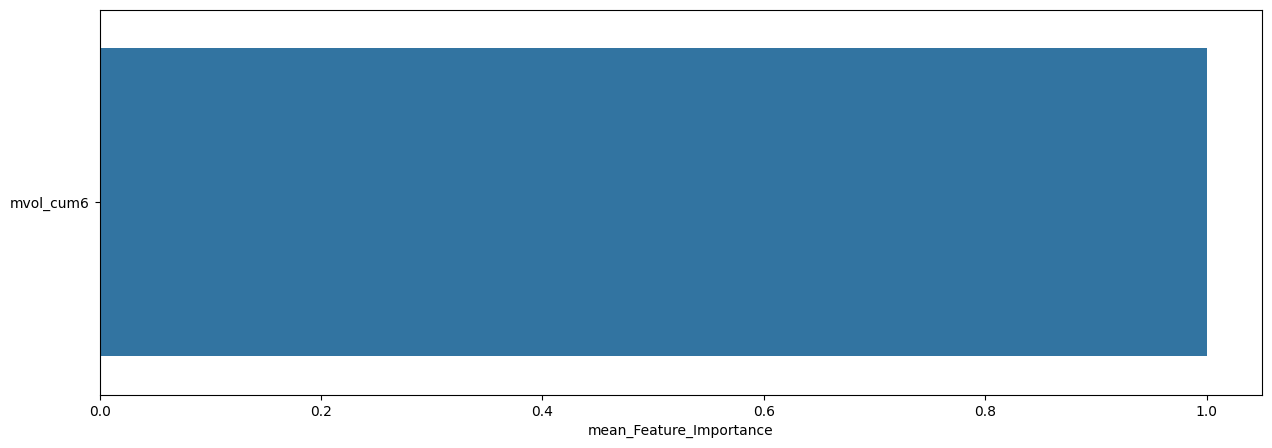

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.42      0.24      0.31        70
         1.0       0.72      0.85      0.78       156

    accuracy                           0.66       226
   macro avg       0.57      0.55      0.54       226
weighted avg       0.63      0.66      0.63       226


accuracy : 0.6637168141592921

precision : 0.7150537634408602

recall : 0.8525641025641025

F1-Score : 0.7777777777777778



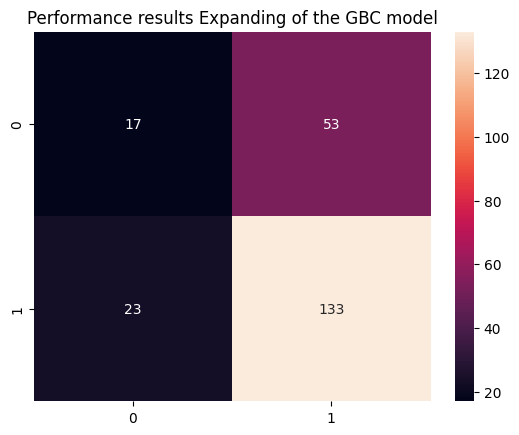


Feature Importance of the model



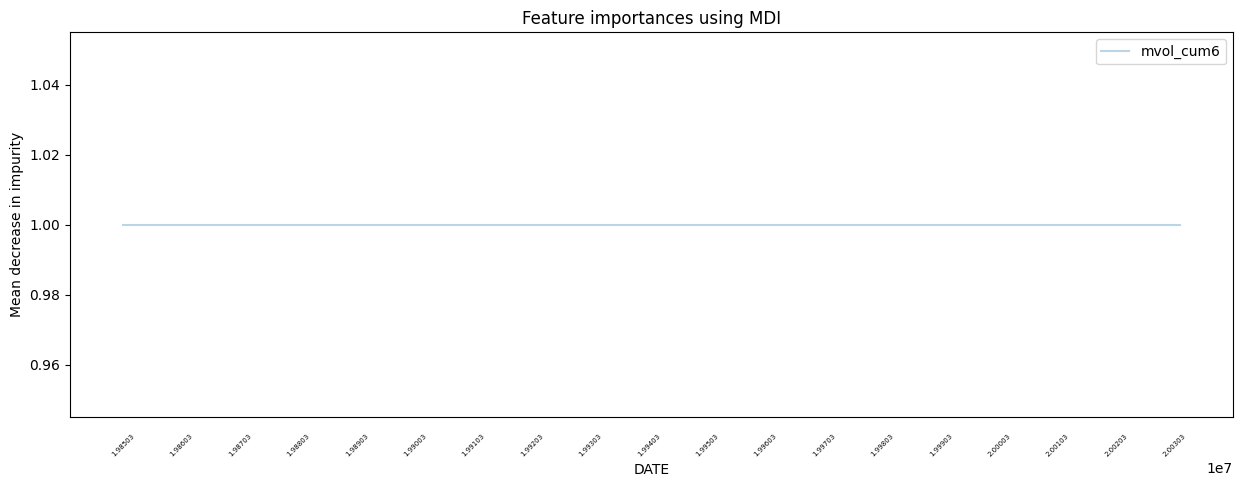

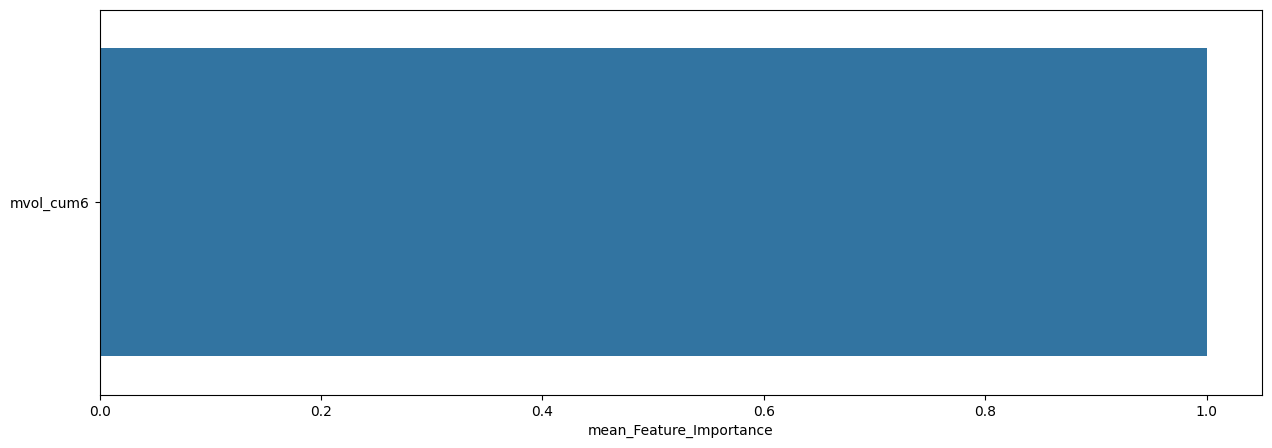

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.47      0.22      0.30        96
         1.0       0.59      0.82      0.69       132

    accuracy                           0.57       228
   macro avg       0.53      0.52      0.49       228
weighted avg       0.54      0.57      0.52       228


accuracy : 0.5657894736842105

precision : 0.5901639344262295

recall : 0.8181818181818182

F1-Score : 0.6857142857142857



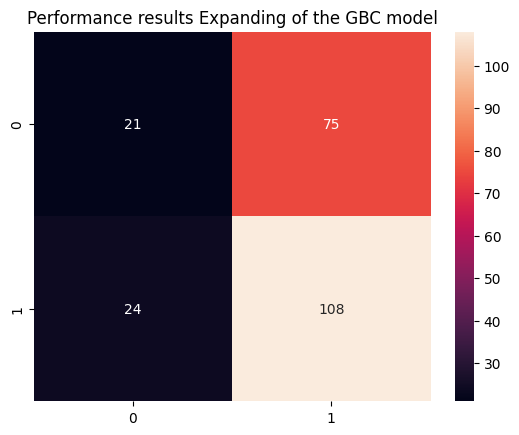


Feature Importance of the model



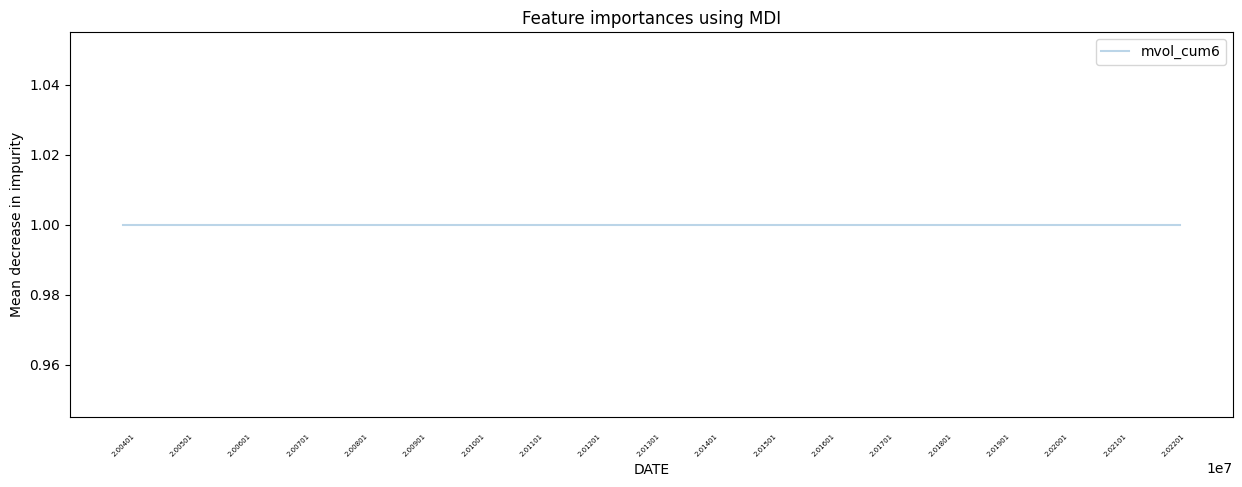

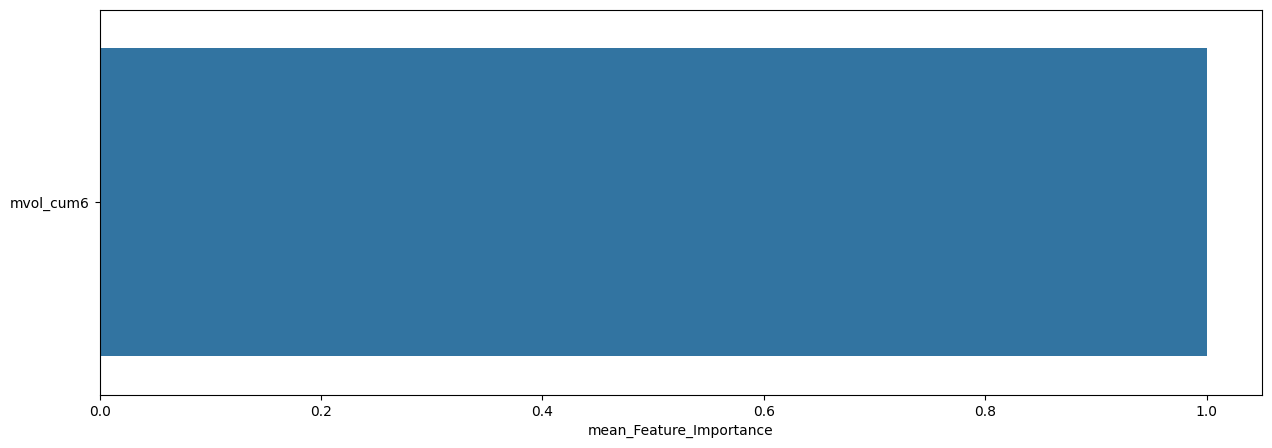

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0

In [121]:
slice_feature_importance(Expanding_GBC_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'GBC') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



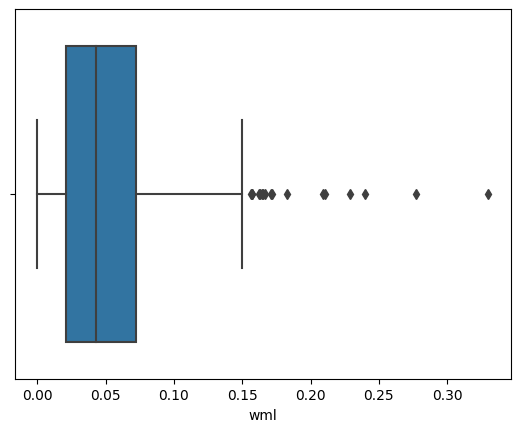

count      mean       std       min       25%       50%       75%  \
wml  487.0  0.053232  0.045251  0.000007  0.020726  0.042733  0.072551   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



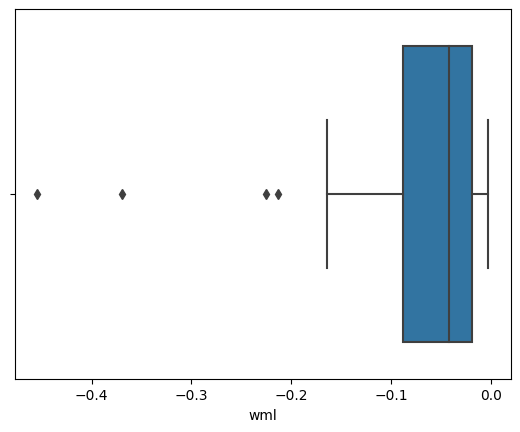

count      mean       std       min       25%       50%       75%  \
wml   69.0 -0.069027  0.080073 -0.454349 -0.088373 -0.041522 -0.018584   

          max  
wml -0.002394


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



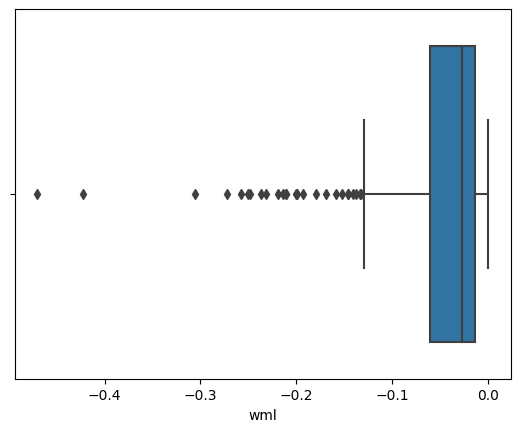

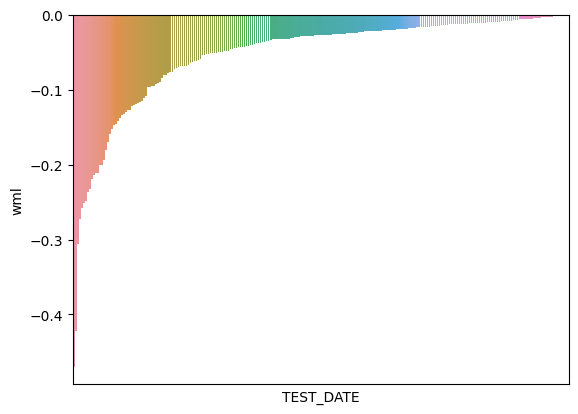

count      mean       std       min       25%       50%       75%  \
wml  247.0 -0.052759  0.068318 -0.469903 -0.060434 -0.027234 -0.013826   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



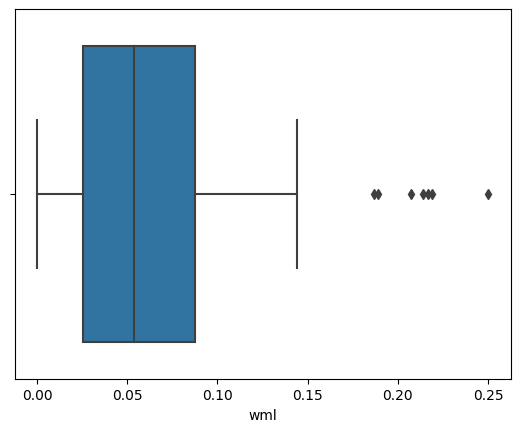

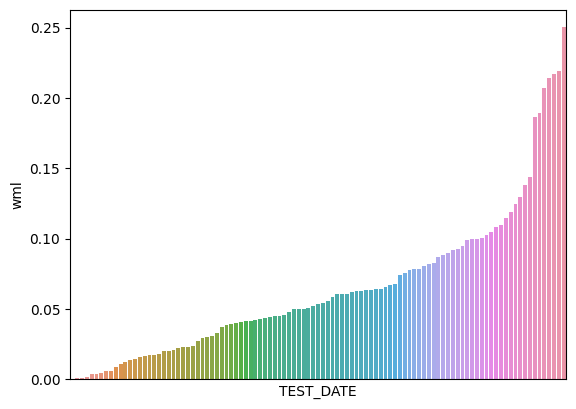

count     mean      std       min       25%      50%       75%       max
wml  103.0  0.06479  0.05278  0.000221  0.025285  0.05392  0.087814  0.250175

In [122]:
GBC_A0_P1, GBC_A1_P0 = What_Pred(Expanding_GBC_Result, WML, 'GBC')

Sharpe Ratio : 0.70256

최근 누적 수익률

  2022년-12월 -> 43705.40
  2022년-11월 -> 39377.70
  2022년-10월 -> 37456.46
  2022년-09월 -> 37456.46
  2022년-08월 -> 37456.46

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 43705.40
  2등 : 2009년-02월 -> 42738.48
  3등 : 2020년-03월 -> 40649.39
  4등 : 2022년-11월 -> 39377.70
  5등 : 2020년-09월 -> 39243.78
  6등 : 2020년-10월 -> 39243.78
  7등 : 2008년-11월 -> 38978.27
  8등 : 2020년-08월 -> 38893.74
  9등 : 2008년-12월 -> 38055.67
  10등 : 2009년-01월 -> 38055.67



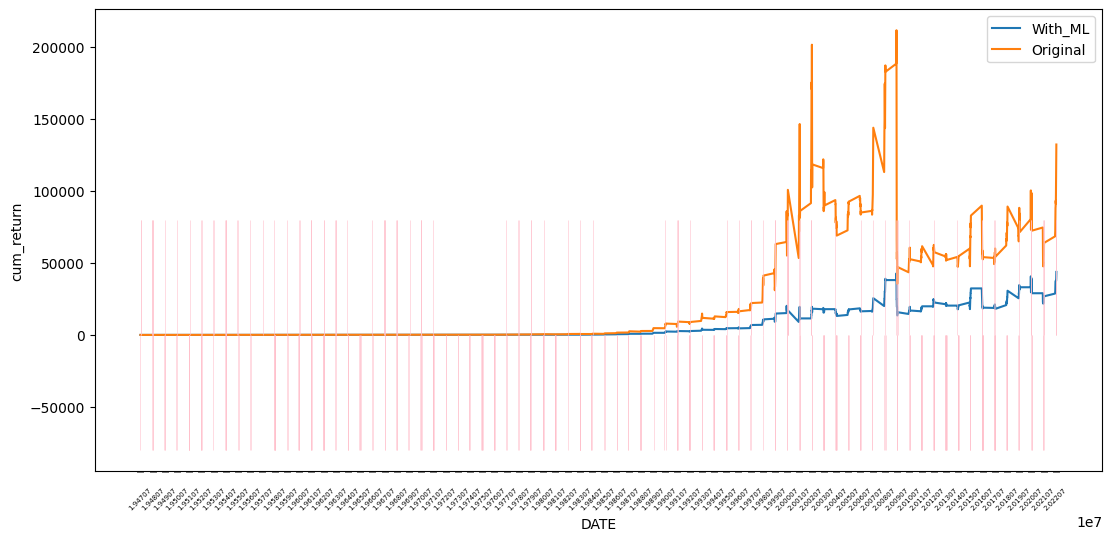

In [123]:
GBC_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_GBC_Result,
                                                 WML,
                                                 'GBC_PRED_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.78888

최근 누적 수익률

  2022년-12월 -> 3075.08
  2022년-11월 -> 2859.99
  2022년-10월 -> 2763.12
  2022년-09월 -> 2598.92
  2022년-08월 -> 2475.82

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 3758.65
  2등 : 2008년-11월 -> 3568.46
  3등 : 2009년-01월 -> 3530.16
  4등 : 2008년-12월 -> 3494.74
  5등 : 2008년-10월 -> 3294.00
  6등 : 2008년-09월 -> 3140.94
  7등 : 2008년-06월 -> 3108.96
  8등 : 2022년-12월 -> 3075.08
  9등 : 2008년-07월 -> 2941.48
  10등 : 2008년-08월 -> 2902.90



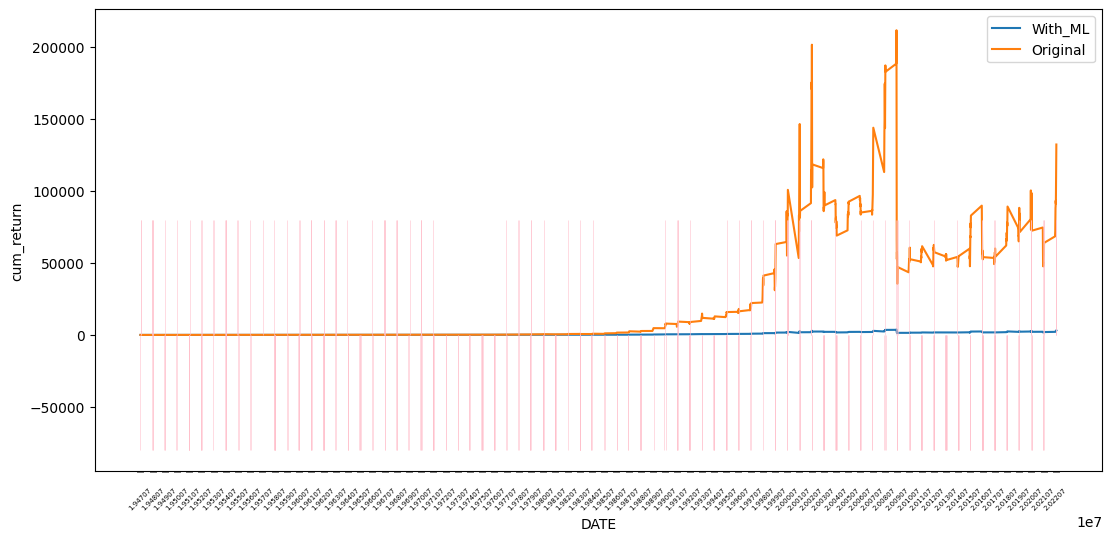

In [124]:
GBC_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_GBC_Result,
                                                  WML,
                                                  'GBC_PROB_POS_WML',
                                                  GBC_A0_P1,
                                                  GBC_A1_P0,
                                                  plot=True)

### XGB

In [125]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

**************************************************

XGB Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : No

  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.33      0.34       316
         1.0       0.66      0.69      0.67       590

    accuracy                           0.56       906
   macro avg       0.51      0.51      0.51       906
weighted avg       0.55      0.56      0.56       906


accuracy : 0.5640176600441501

precision : 0.6570048309178744

recall : 0.6915254237288135

F1-Score : 0.6738232865400495



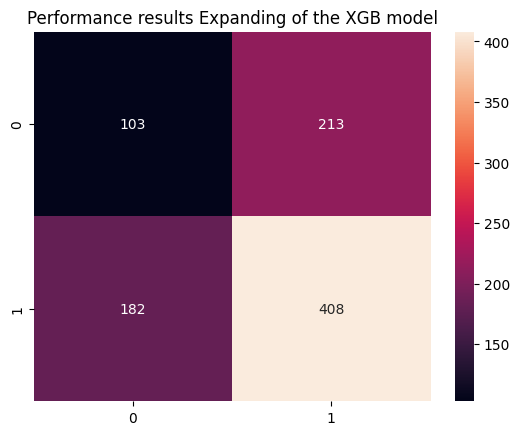


Feature Importance of the model



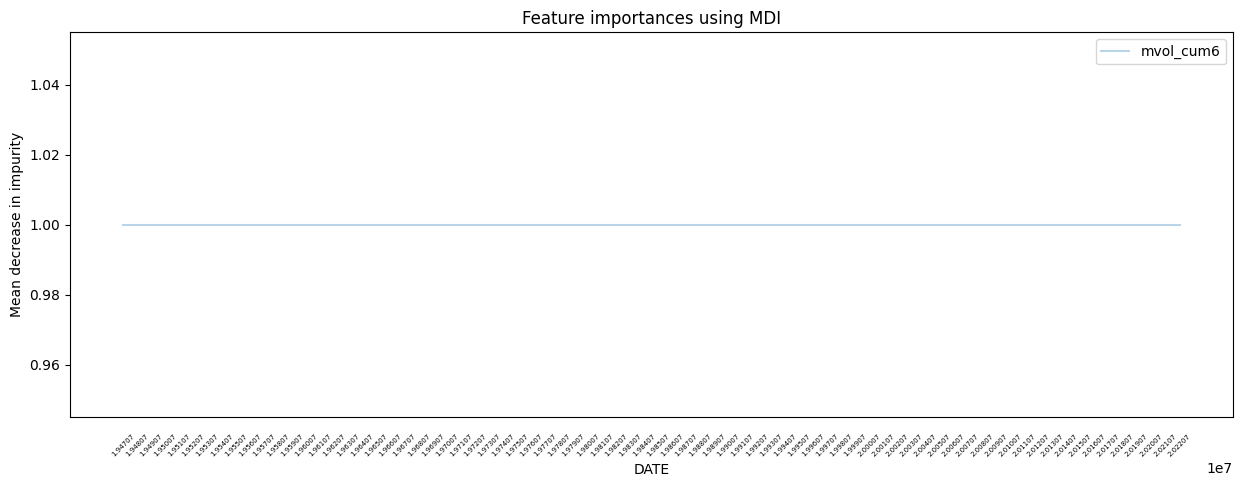

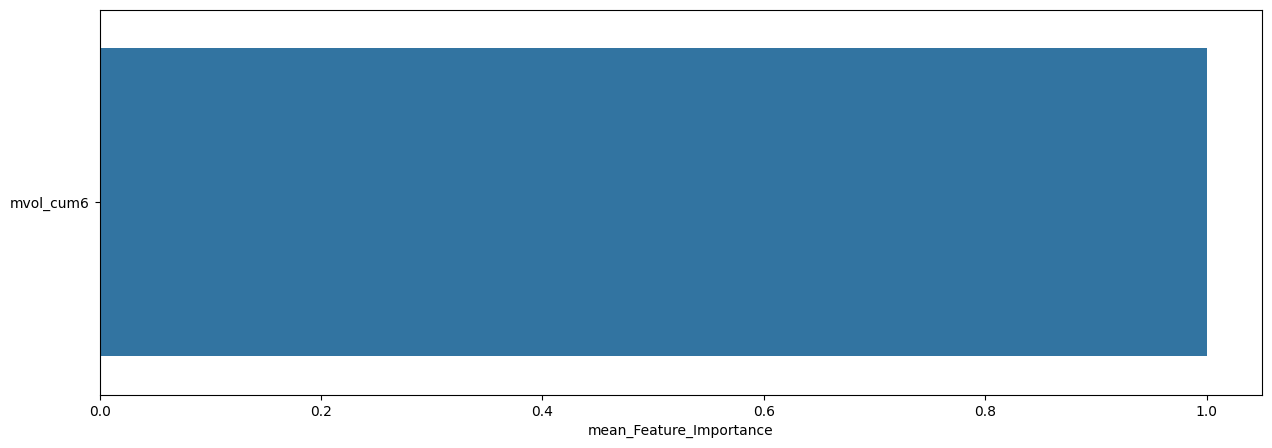

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0

In [126]:
Expanding_XGB_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                  model=XGB, # 사용할 모델
                                  model_name='XGB', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.28      0.29        75
         1.0       0.65      0.68      0.66       151

    accuracy                           0.54       226
   macro avg       0.48      0.48      0.48       226
weighted avg       0.54      0.54      0.54       226


accuracy : 0.5442477876106194

precision : 0.6538461538461539

recall : 0.6754966887417219

F1-Score : 0.6644951140065147



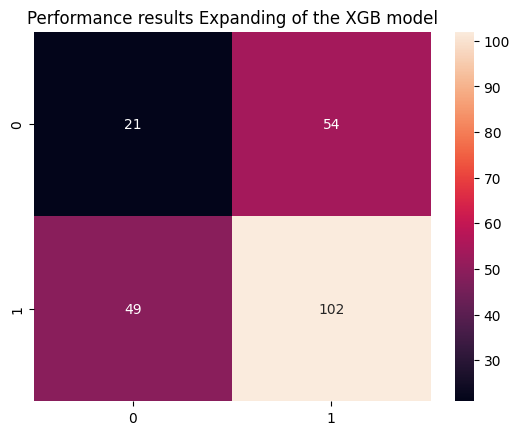


Feature Importance of the model



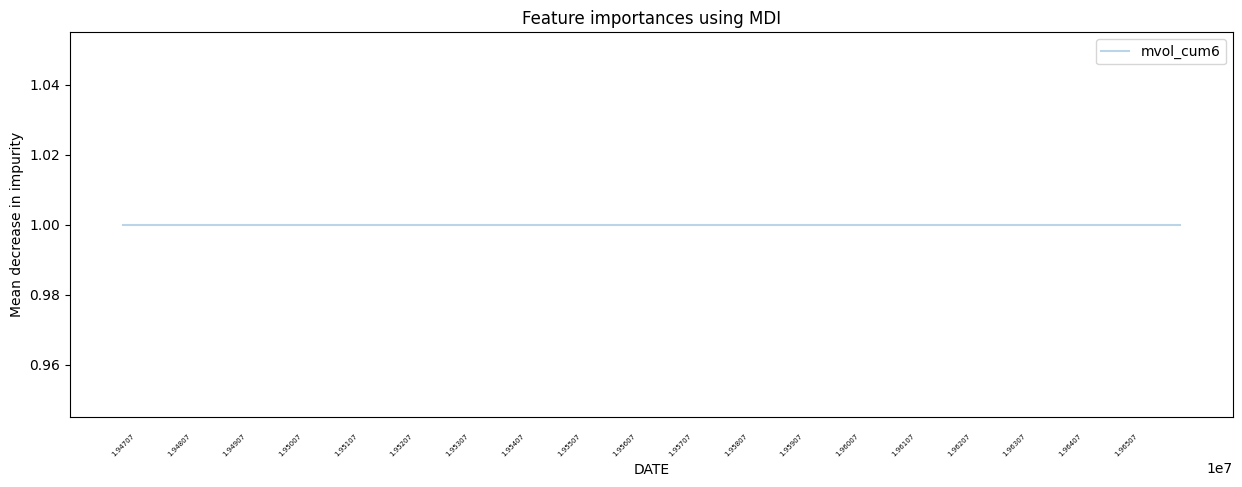

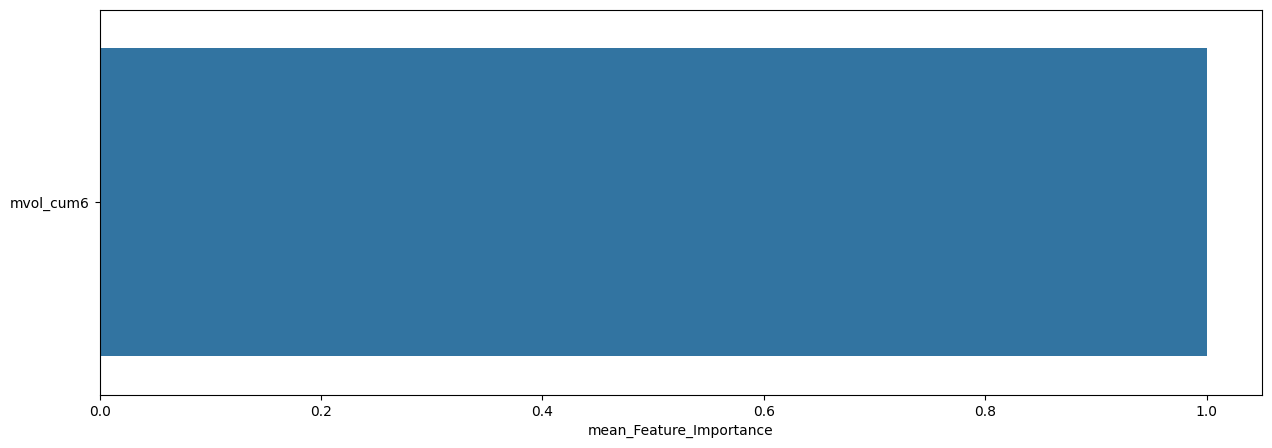

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.31      0.33        75
         1.0       0.68      0.72      0.69       151

    accuracy                           0.58       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.57      0.58      0.57       226


accuracy : 0.5796460176991151

precision : 0.675

recall : 0.7152317880794702

F1-Score : 0.6945337620578779



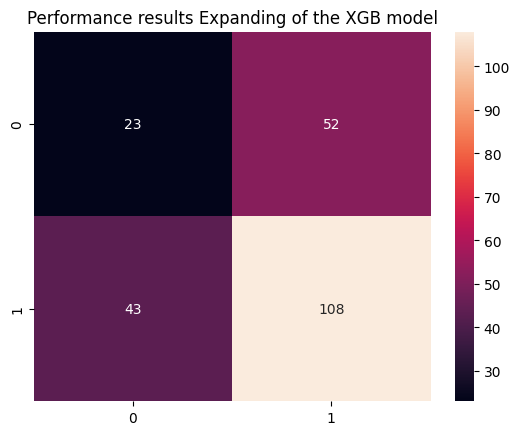


Feature Importance of the model



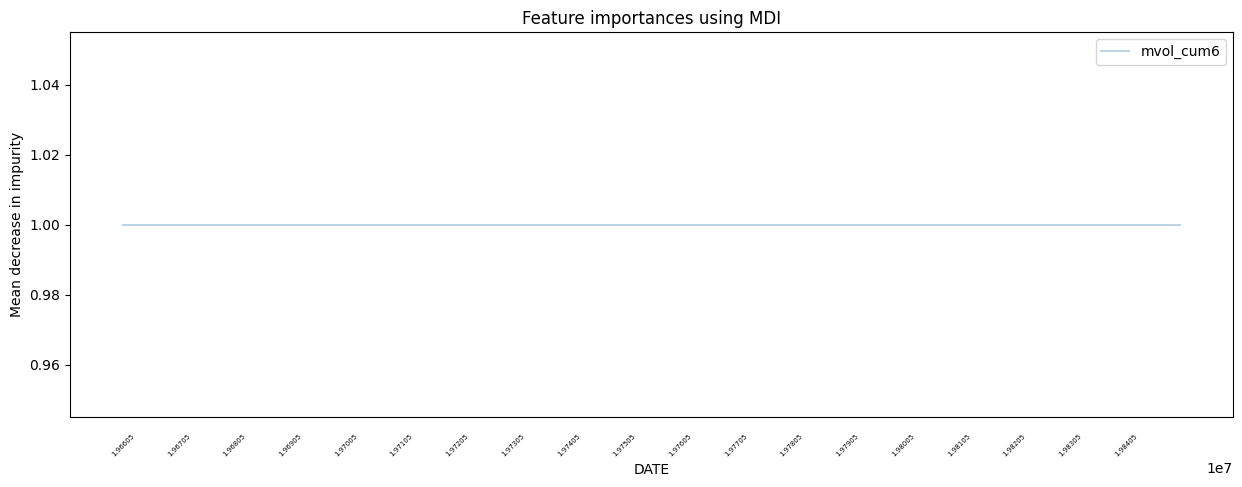

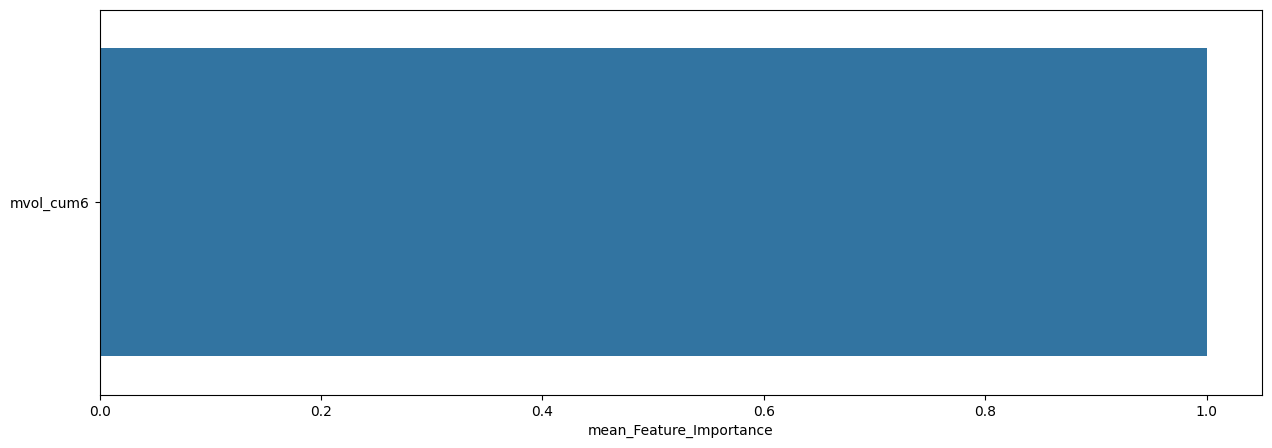

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.34      0.34        70
         1.0       0.70      0.69      0.70       156

    accuracy                           0.58       226
   macro avg       0.52      0.52      0.52       226
weighted avg       0.59      0.58      0.59       226


accuracy : 0.584070796460177

precision : 0.7012987012987013

recall : 0.6923076923076923

F1-Score : 0.6967741935483871



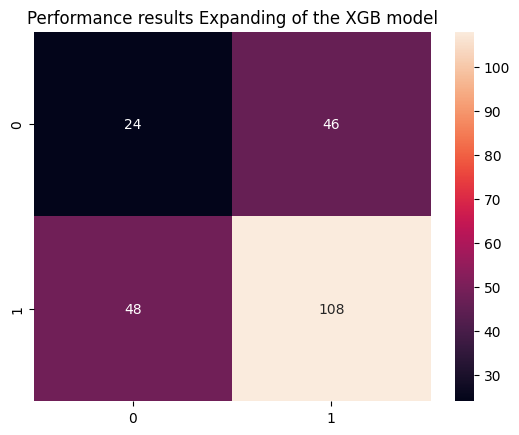


Feature Importance of the model



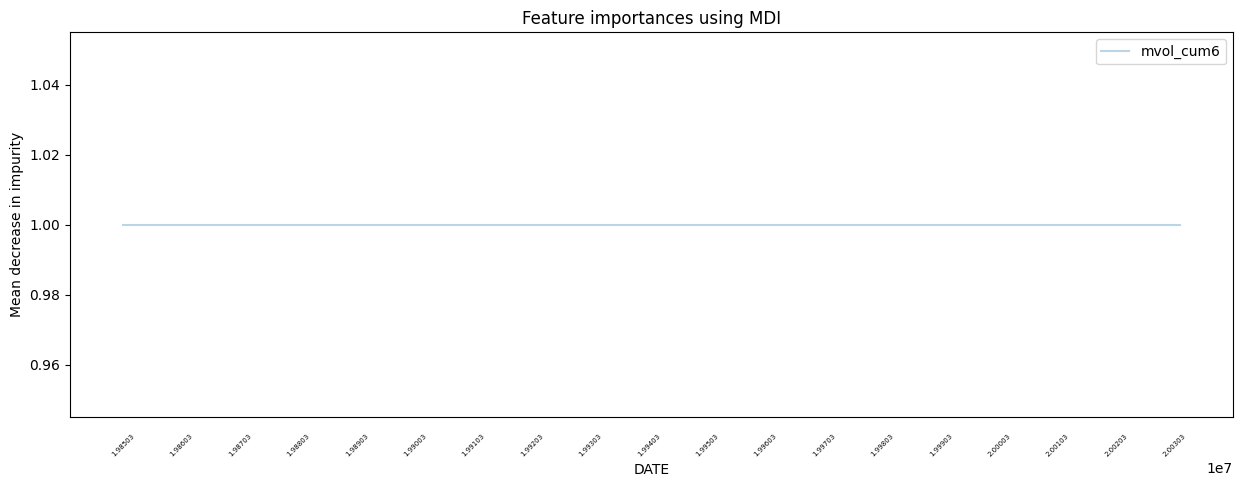

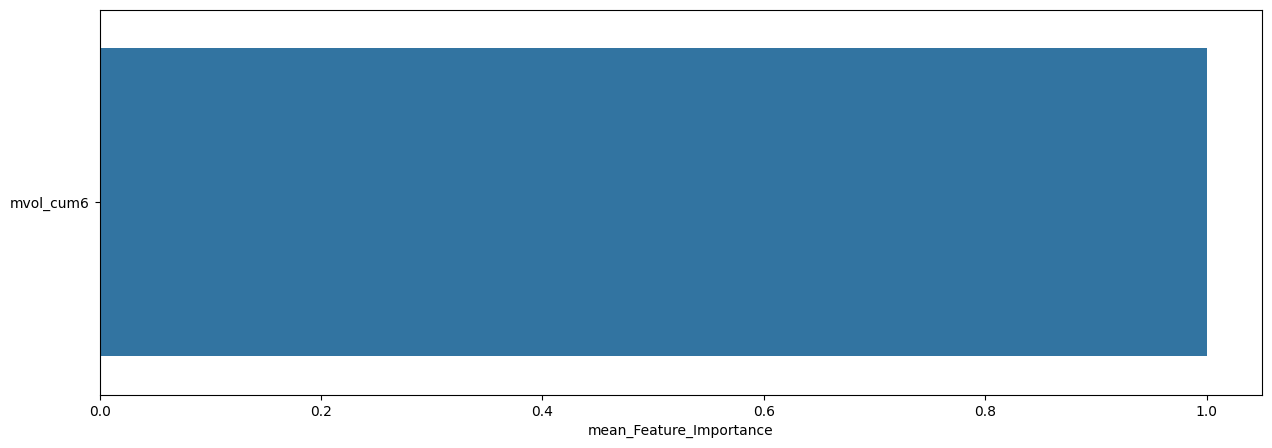

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.45      0.36      0.40        96
         1.0       0.60      0.68      0.64       132

    accuracy                           0.55       228
   macro avg       0.53      0.52      0.52       228
weighted avg       0.54      0.55      0.54       228


accuracy : 0.5482456140350878

precision : 0.5960264900662252

recall : 0.6818181818181818

F1-Score : 0.6360424028268552



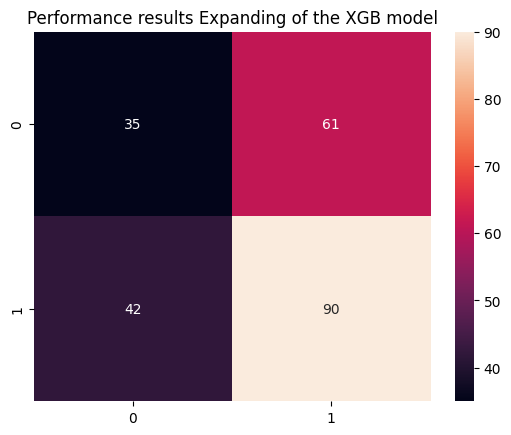


Feature Importance of the model



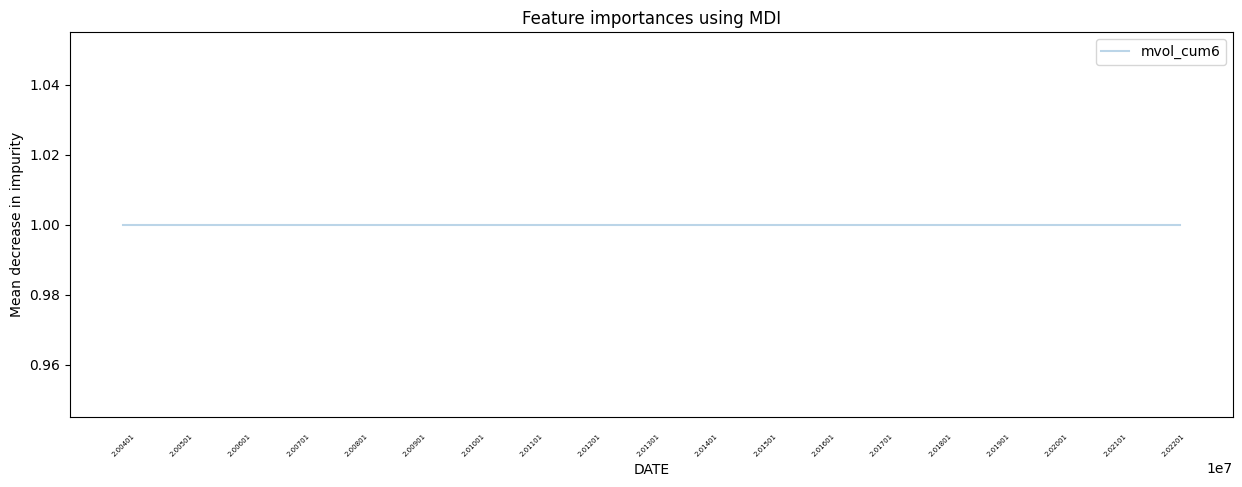

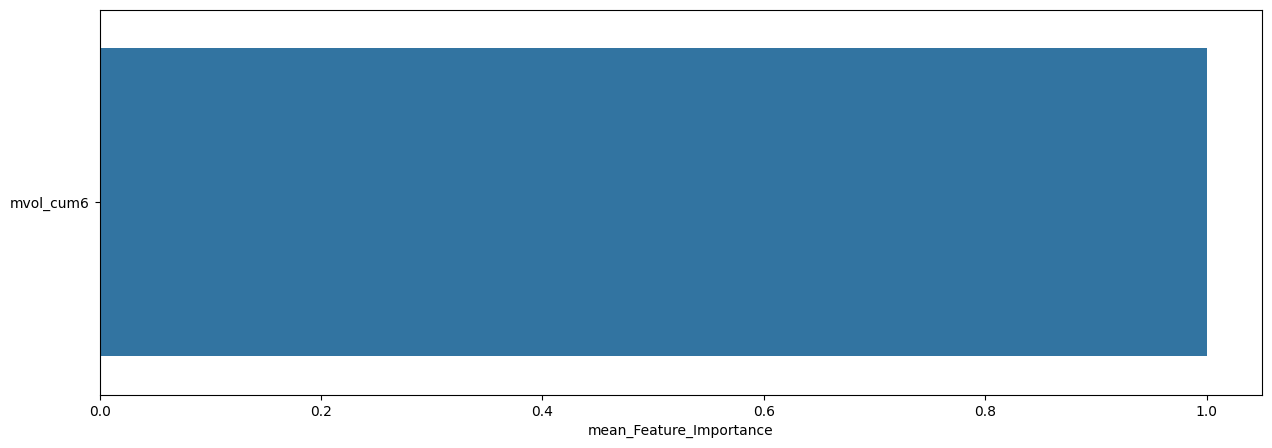

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                      1.0                     1.0   

           min_Feature_Importance  
mvol_cum6                     1.0

In [127]:
slice_feature_importance(Expanding_XGB_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'XGB') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



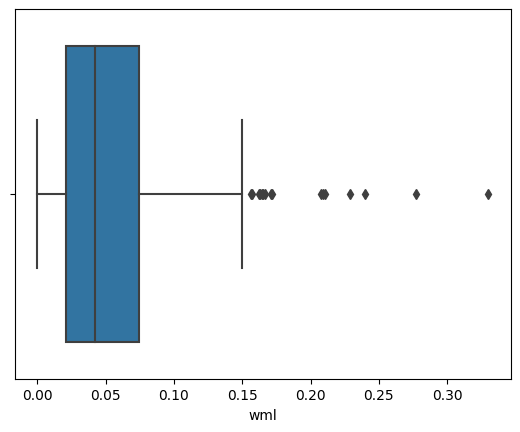

count      mean       std       min       25%       50%       75%  \
wml  408.0  0.054291  0.047092  0.000007  0.020619  0.042271  0.074563   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



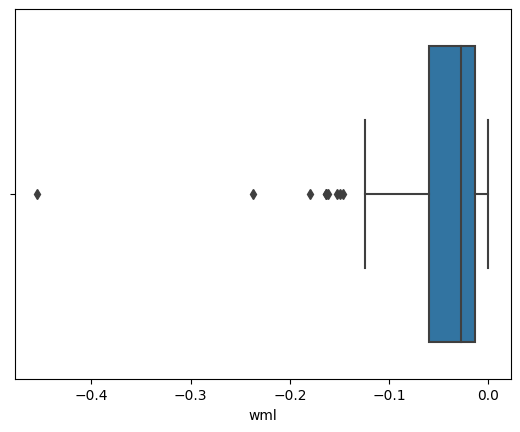

count      mean       std       min       25%       50%       75%  \
wml  103.0 -0.048676  0.061443 -0.454349 -0.060069 -0.028115 -0.013301   

          max  
wml -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



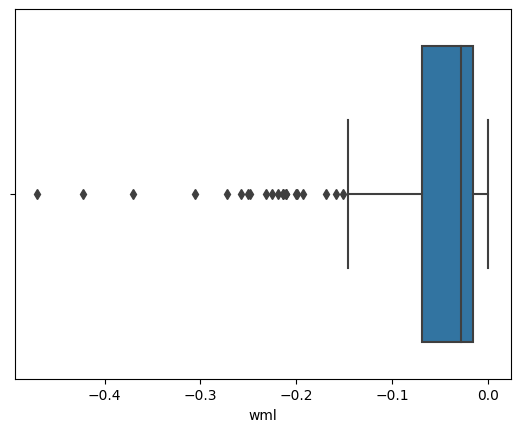

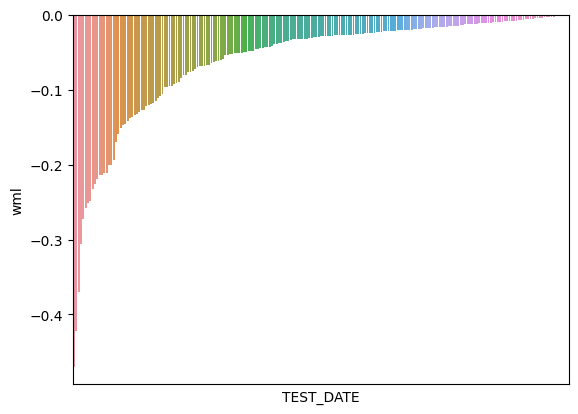

count      mean       std       min       25%       50%       75%  \
wml  213.0 -0.060003  0.075375 -0.469903 -0.069463 -0.028769 -0.015898   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



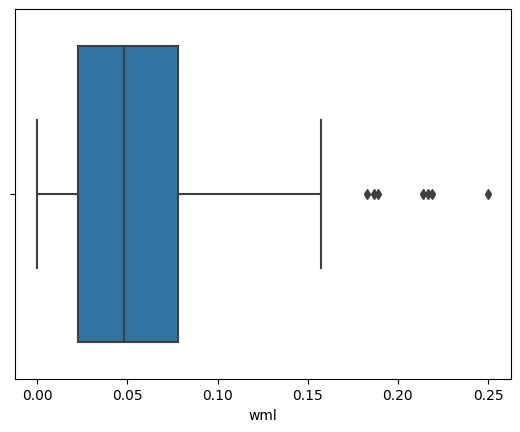

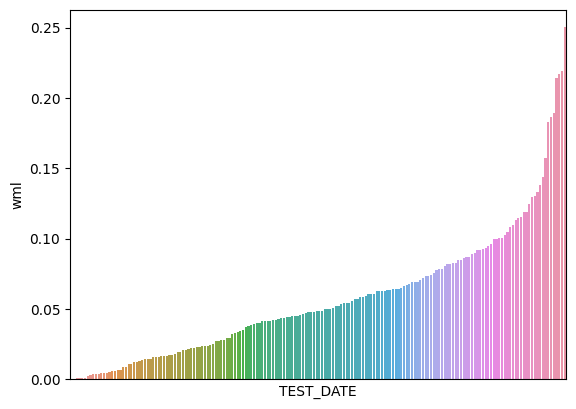

count      mean       std       min      25%       50%       75%  \
wml  182.0  0.057398  0.046232  0.000128  0.02262  0.048341  0.078324   

          max  
wml  0.250175

In [128]:
XGB_A0_P1, XGB_A1_P0 = What_Pred(Expanding_XGB_Result, WML, 'XGB')

Sharpe Ratio : 0.81411

최근 누적 수익률

  2022년-12월 -> 1335.91
  2022년-11월 -> 1203.54
  2022년-10월 -> 1144.77
  2022년-09월 -> 1144.77
  2022년-08월 -> 1144.77

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 2538.01
  2등 : 2009년-01월 -> 2259.82
  3등 : 2008년-11월 -> 2245.07
  4등 : 2008년-12월 -> 2191.91
  5등 : 2001년-09월 -> 2127.31
  6등 : 2008년-10월 -> 2047.23
  7등 : 2000년-03월 -> 2023.25
  8등 : 2000년-04월 -> 2023.25
  9등 : 2000년-02월 -> 2023.25
  10등 : 2008년-09월 -> 1932.66



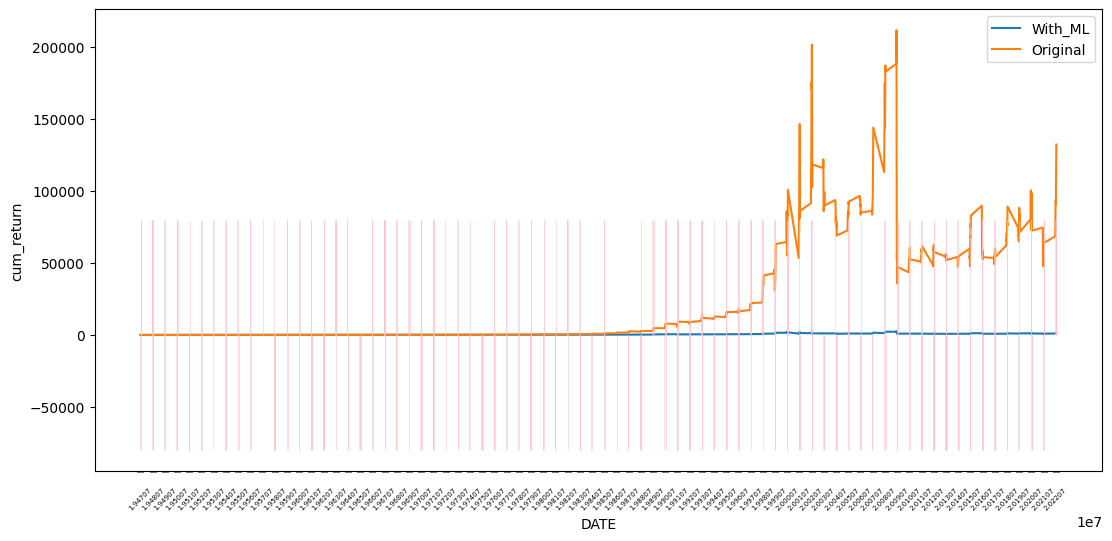

In [129]:
XGB_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_XGB_Result,
                                                 WML,
                                                 'XGB_PRED_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.80663

최근 누적 수익률

  2022년-12월 -> 1933.45
  2022년-11월 -> 1765.00
  2022년-10월 -> 1691.86
  2022년-09월 -> 1589.88
  2022년-08월 -> 1517.81

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 2086.74
  2등 : 2022년-12월 -> 1933.45
  3등 : 2008년-11월 -> 1917.20
  4등 : 2009년-01월 -> 1912.88
  5등 : 2008년-12월 -> 1875.72
  6등 : 2022년-11월 -> 1765.00
  7등 : 2008년-10월 -> 1764.50
  8등 : 2020년-09월 -> 1692.49
  9등 : 2022년-10월 -> 1691.86
  10등 : 2020년-10월 -> 1690.68



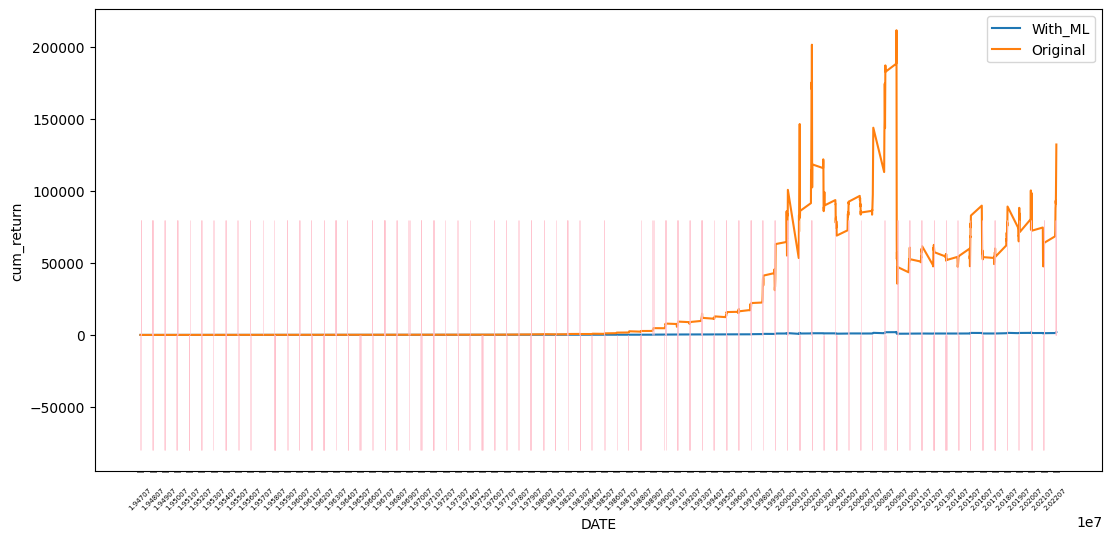

In [130]:
XGB_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_XGB_Result,
                                                 WML,
                                                 'XGB_PROB_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

### LGBM

In [131]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

**************************************************

LGBM Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.28      0.32       316
         1.0       0.66      0.73      0.69       590

    accuracy                           0.58       906
   macro avg       0.51      0.51      0.50       906
weighted avg       0.55      0.58      0.56       906


accuracy : 0.5750551876379691

precision : 0.6555386949924128

recall : 0.7322033898305085

F1-Score : 0.6917534027221777



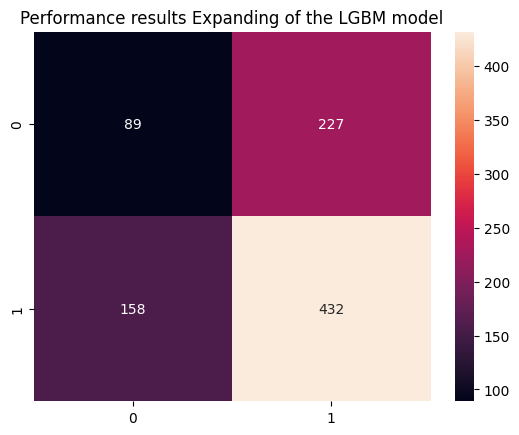


Feature Importance of the model



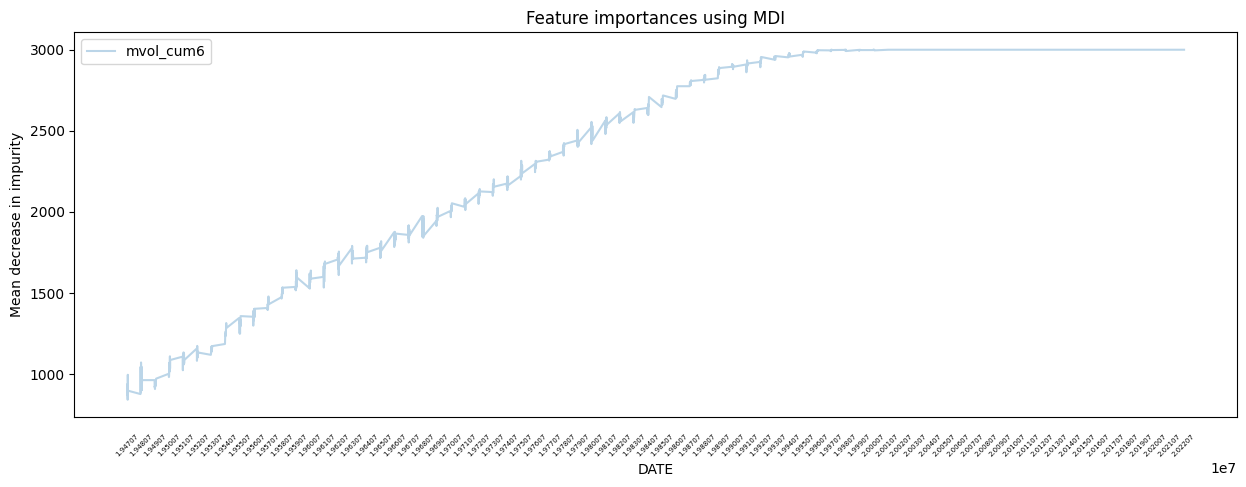

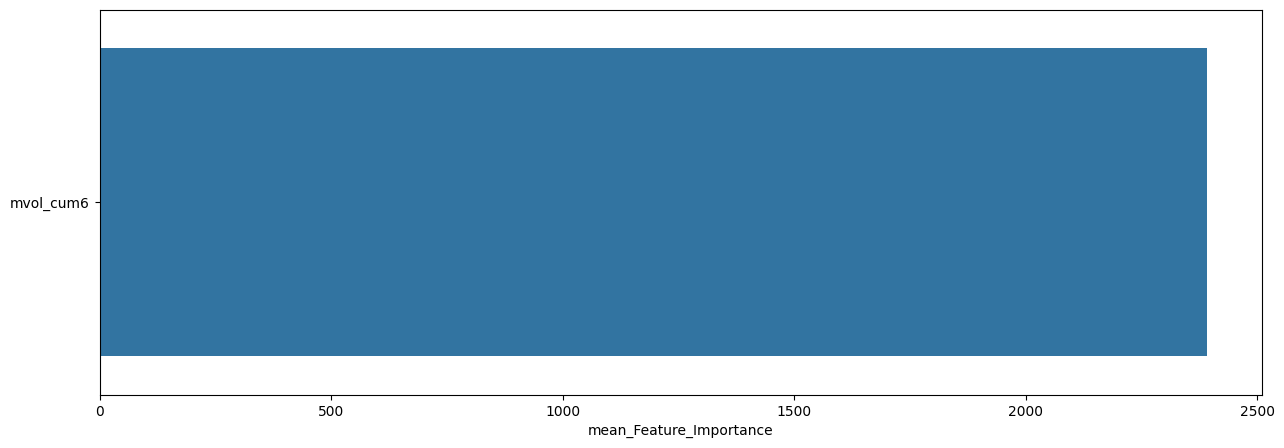

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6              2390.528698                    3000   

           min_Feature_Importance  
mvol_cum6                     841

In [132]:
Expanding_LGBM_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                    window_size=240, # window size (훈련 데이터 셋 크기)
                                    method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                    model=LGBM, # 사용할 모델
                                    model_name='LGBM', # 사용한 모델 명
                                    plot=True, # 모델 성능 지표 시각화 여부
                                    plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.27      0.28        75
         1.0       0.66      0.70      0.68       151

    accuracy                           0.55       226
   macro avg       0.48      0.48      0.48       226
weighted avg       0.54      0.55      0.55       226


accuracy : 0.5530973451327433

precision : 0.65625

recall : 0.695364238410596

F1-Score : 0.6752411575562701



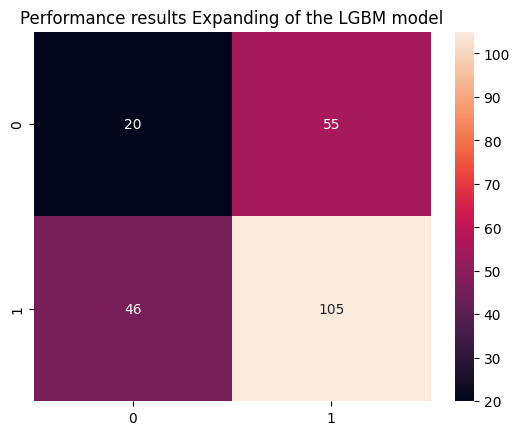


Feature Importance of the model



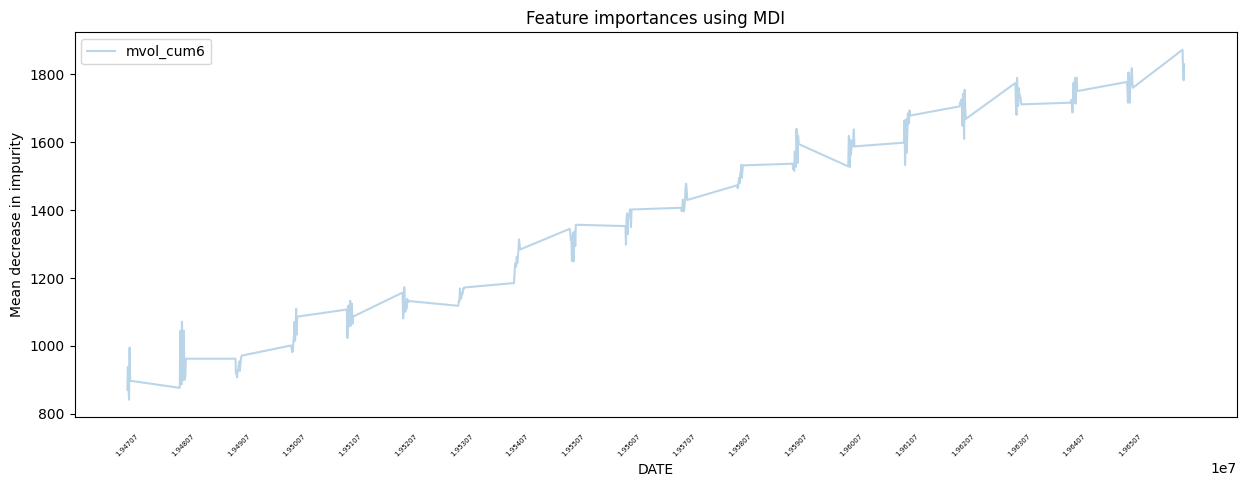

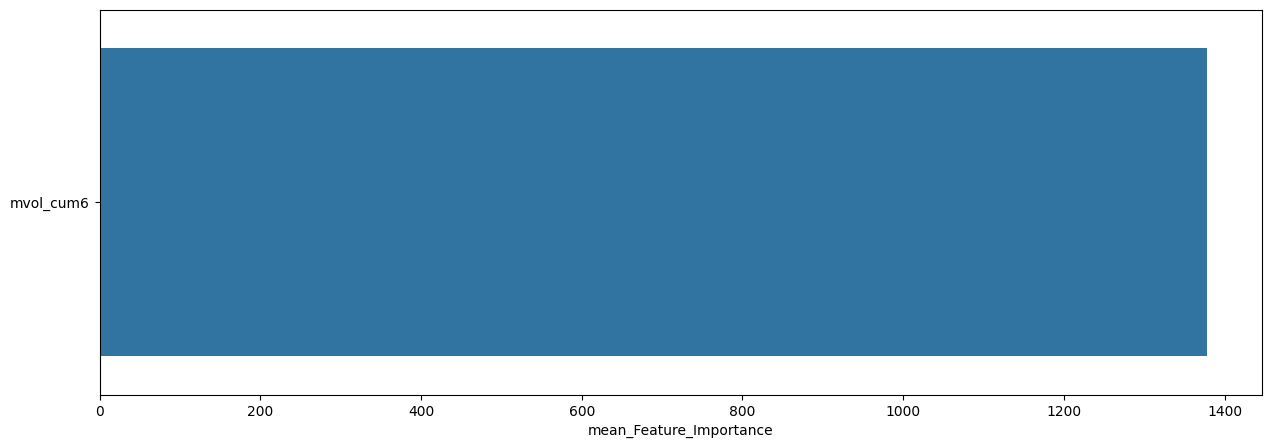

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6              1377.818584                    1873   

           min_Feature_Importance  
mvol_cum6                     841


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.23      0.27        75
         1.0       0.67      0.78      0.72       151

    accuracy                           0.60       226
   macro avg       0.51      0.50      0.50       226
weighted avg       0.56      0.60      0.57       226


accuracy : 0.5973451327433629

precision : 0.6704545454545454

recall : 0.7814569536423841

F1-Score : 0.7217125382262998



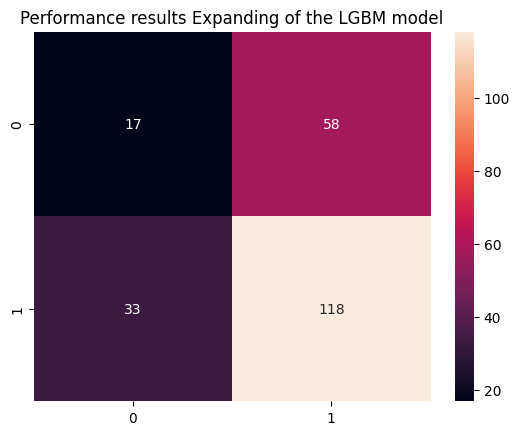


Feature Importance of the model



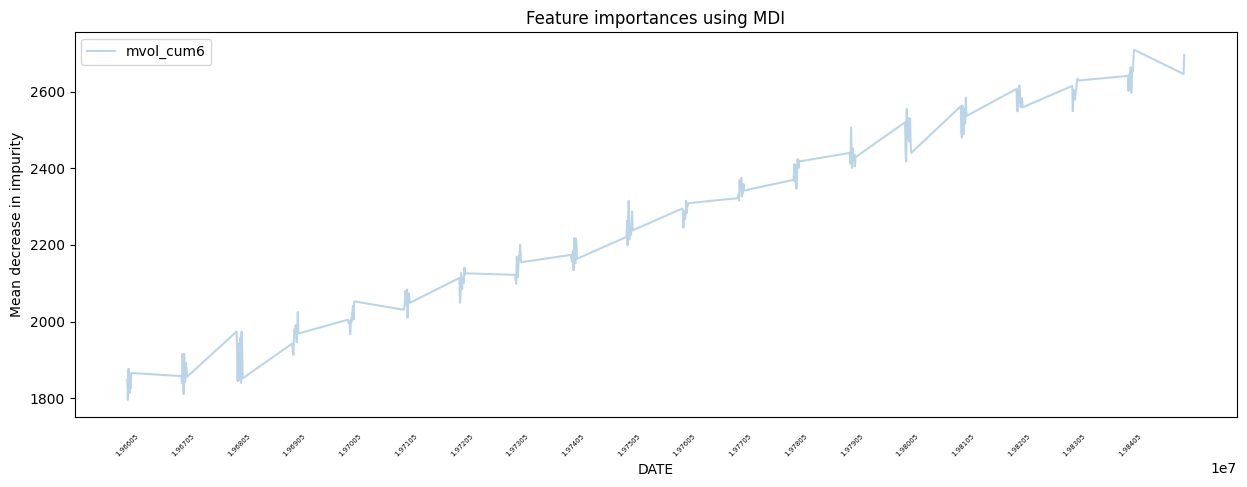

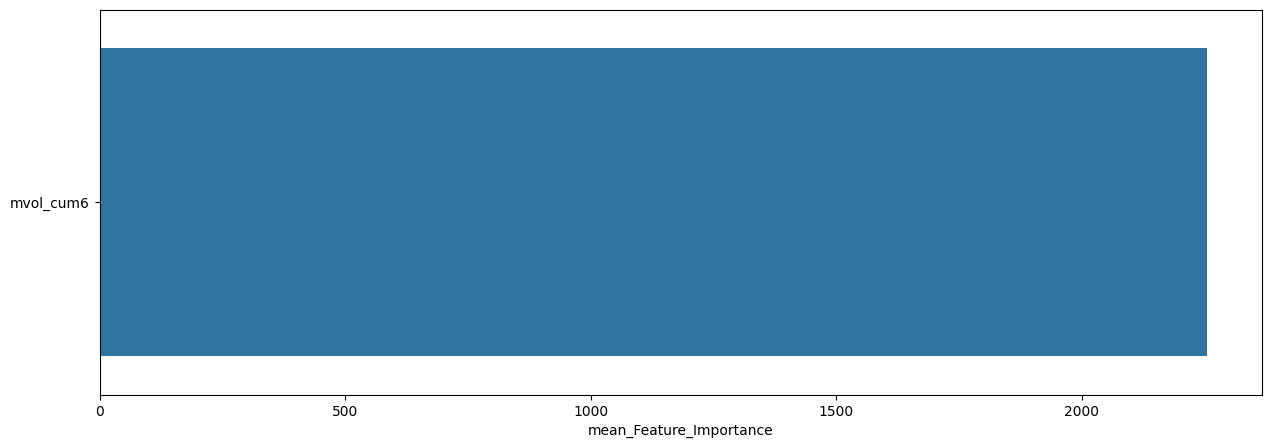

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6              2254.836283                    2709   

           min_Feature_Importance  
mvol_cum6                    1796


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.27      0.26      0.26        70
         1.0       0.67      0.69      0.68       156

    accuracy                           0.55       226
   macro avg       0.47      0.47      0.47       226
weighted avg       0.55      0.55      0.55       226


accuracy : 0.5530973451327433

precision : 0.6729559748427673

recall : 0.6858974358974359

F1-Score : 0.6793650793650794



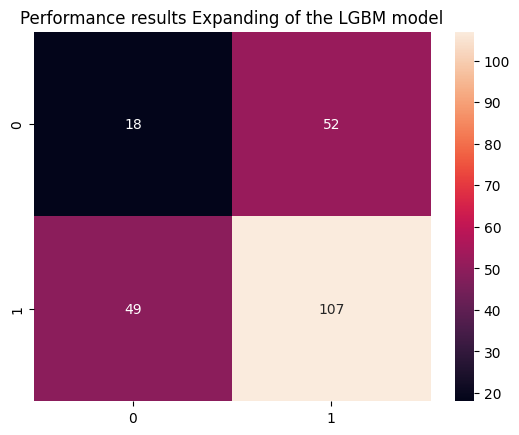


Feature Importance of the model



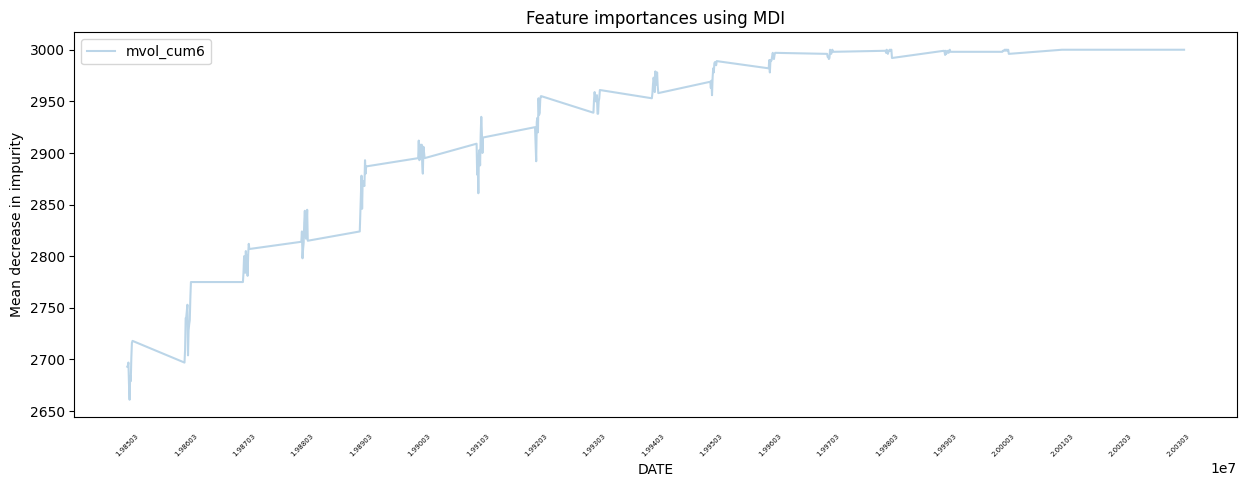

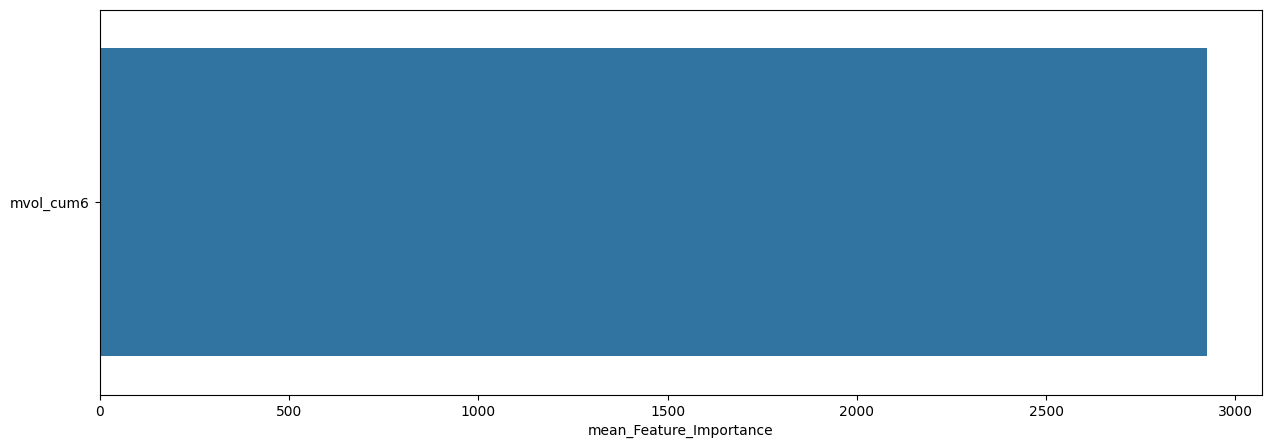

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6              2924.066372                    3000   

           min_Feature_Importance  
mvol_cum6                    2661


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.53      0.35      0.42        96
         1.0       0.62      0.77      0.69       132

    accuracy                           0.60       228
   macro avg       0.58      0.56      0.56       228
weighted avg       0.58      0.60      0.58       228


accuracy : 0.5964912280701754

precision : 0.6219512195121951

recall : 0.7727272727272727

F1-Score : 0.6891891891891893



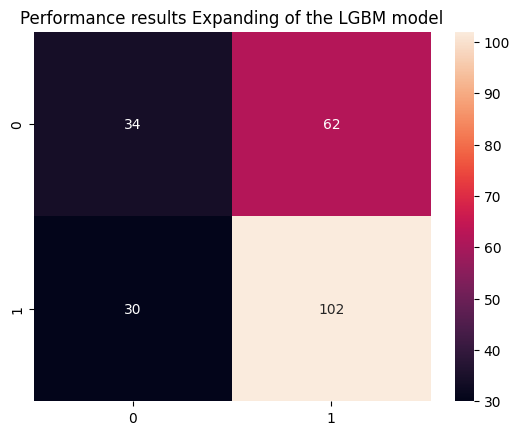


Feature Importance of the model



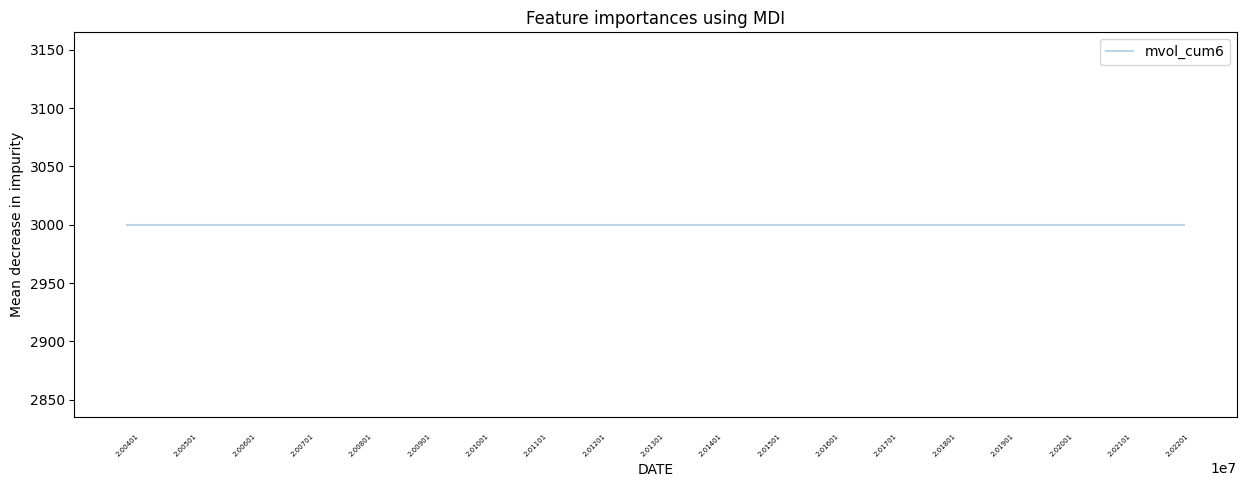

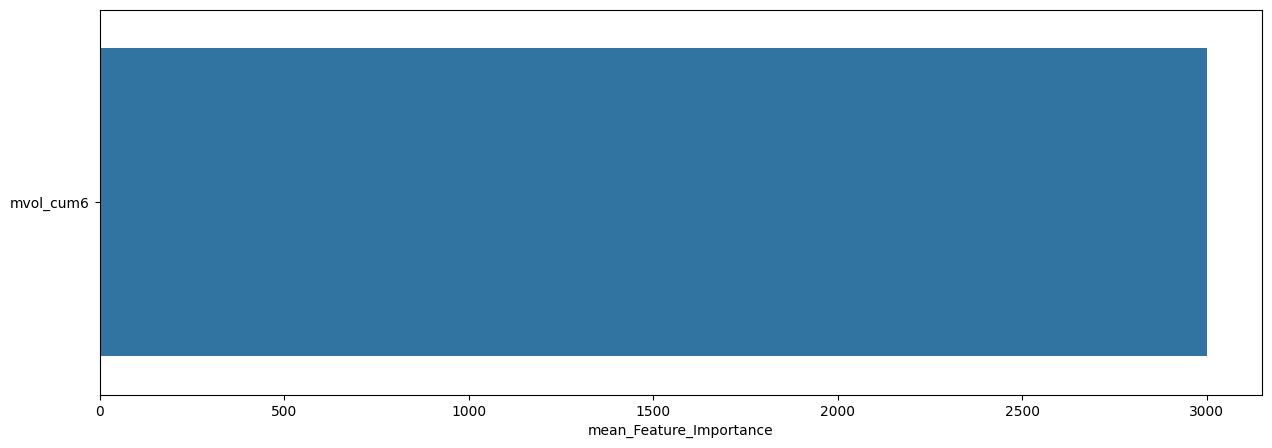

mean_Feature_Importance  max_Feature_Importance  \
mvol_cum6                   3000.0                    3000   

           min_Feature_Importance  
mvol_cum6                    3000

In [133]:
slice_feature_importance(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                        4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                        'Expanding', # Rolling Windows Method
                        'LGBM') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



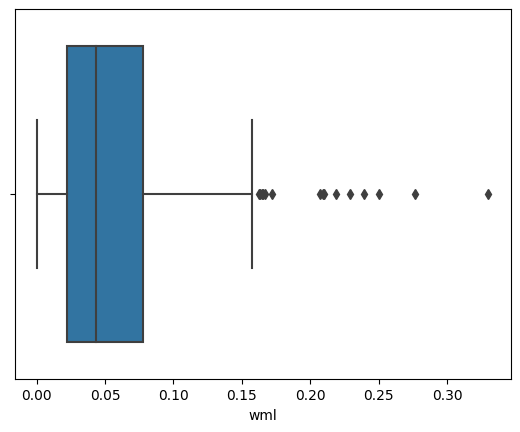

count      mean       std       min       25%       50%       75%  \
wml  432.0  0.055342  0.047553  0.000577  0.021997  0.043314  0.077985   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



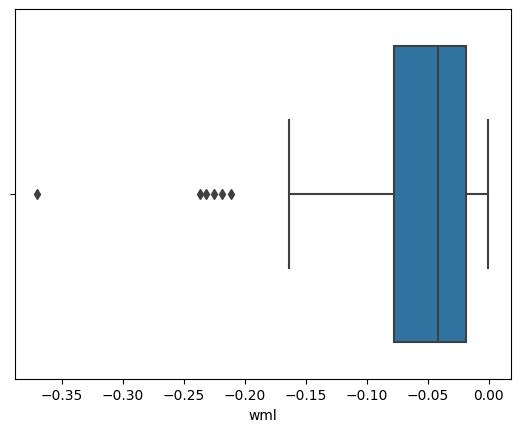

count      mean       std       min       25%       50%       75%  \
wml   89.0 -0.062704  0.066798 -0.370041 -0.078002 -0.041522 -0.018584   

          max  
wml -0.000506


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



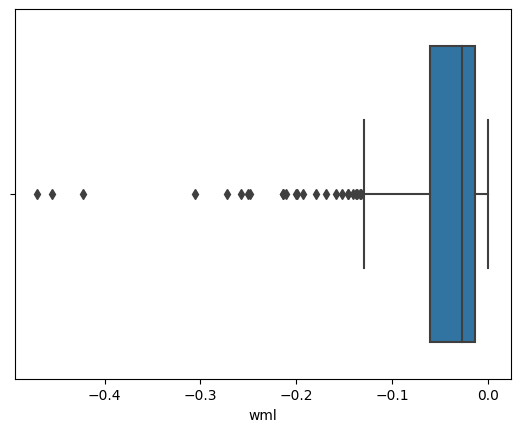

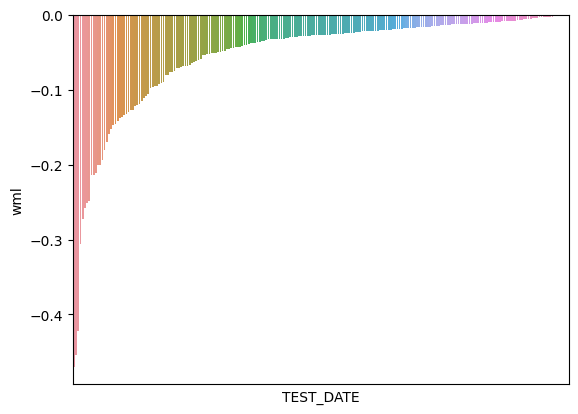

count      mean      std       min      25%       50%       75%       max
wml  227.0 -0.053804  0.07289 -0.469903 -0.06044 -0.027097 -0.013685 -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



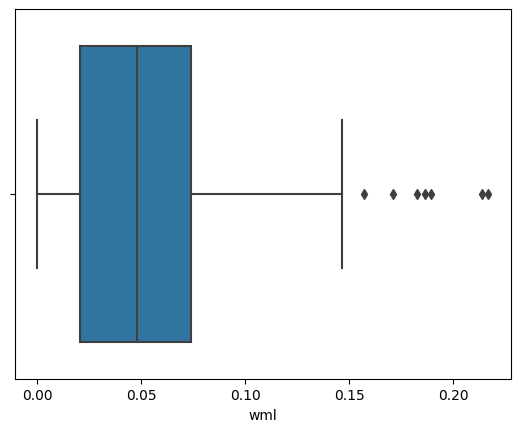

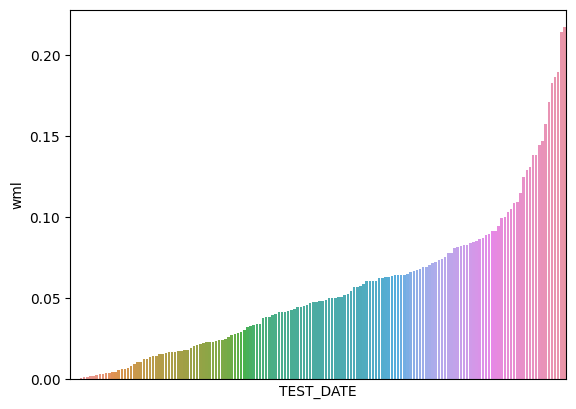

count      mean       std       min       25%       50%       75%  \
wml  158.0  0.054997  0.044865  0.000007  0.020724  0.047988  0.073961   

          max  
wml  0.216883

In [134]:
LGBM_A0_P1, LGBM_A1_P0 = What_Pred(Expanding_LGBM_Result,
                                   WML,
                                   'LGBM')

Sharpe Ratio : 0.65536

최근 누적 수익률

  2022년-12월 -> 13133.58
  2022년-11월 -> 11833.03
  2022년-10월 -> 11255.66
  2022년-09월 -> 11255.66
  2022년-08월 -> 10232.98

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 13133.58
  2등 : 2009년-02월 -> 12914.58
  3등 : 2022년-11월 -> 11833.03
  4등 : 2009년-01월 -> 11499.47
  5등 : 2008년-11월 -> 11424.46
  6등 : 2022년-09월 -> 11255.66
  7등 : 2022년-10월 -> 11255.66
  8등 : 2008년-12월 -> 11154.03
  9등 : 2008년-10월 -> 10418.06
  10등 : 2022년-08월 -> 10232.98



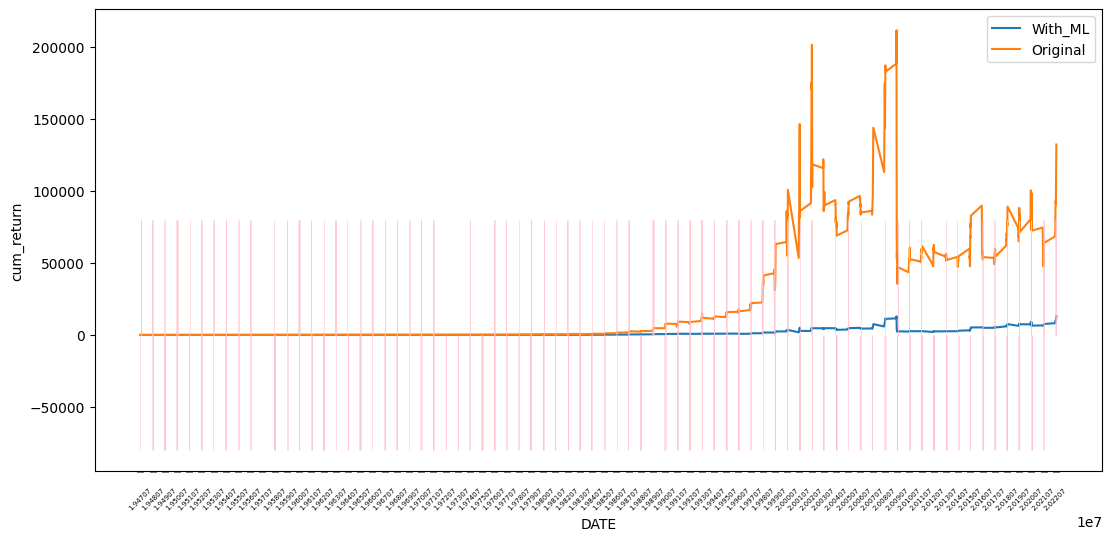

In [135]:
LGBM_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PRED_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

Sharpe Ratio : 0.75418

최근 누적 수익률

  2022년-12월 -> 4000.25
  2022년-11월 -> 3738.73
  2022년-10월 -> 3624.35
  2022년-09월 -> 3494.76
  2022년-08월 -> 3300.75

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 4000.25
  2등 : 2022년-11월 -> 3738.73
  3등 : 2009년-02월 -> 3730.33
  4등 : 2022년-10월 -> 3624.35
  5등 : 2022년-09월 -> 3494.76
  6등 : 2009년-01월 -> 3433.09
  7등 : 2008년-11월 -> 3417.93
  8등 : 2008년-12월 -> 3361.42
  9등 : 2022년-07월 -> 3313.02
  10등 : 2022년-08월 -> 3300.75



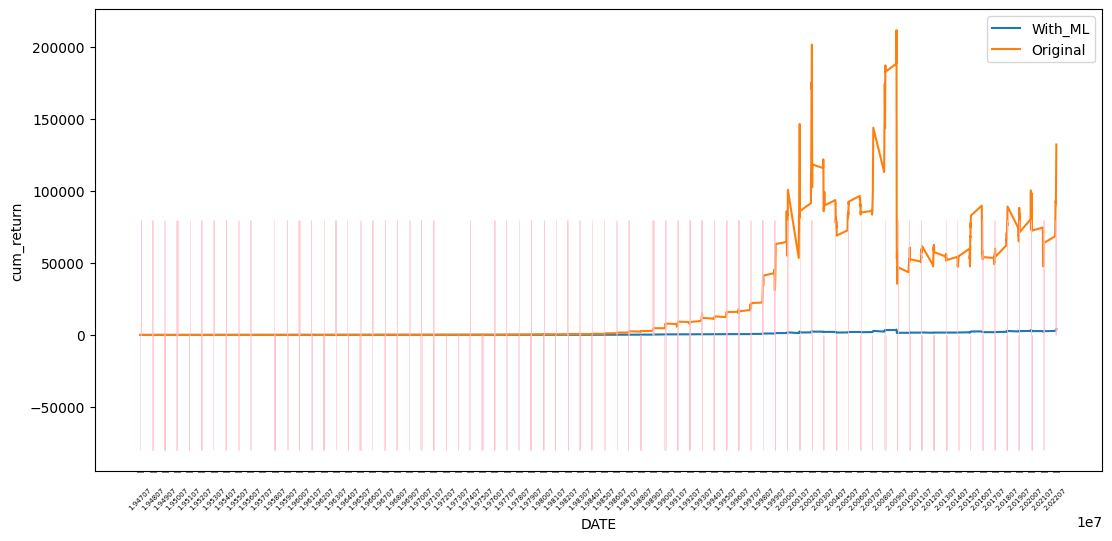

In [136]:
LGBM_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PROB_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

# Performance

## F1 - Score

RDF의 F1-Score : 0.651877133105802
GBC의 F1-Score : 0.6928628708901363
XGB의 F1-Score : 0.67430441898527
LGBM의 F1-Score : 0.7118902439024392



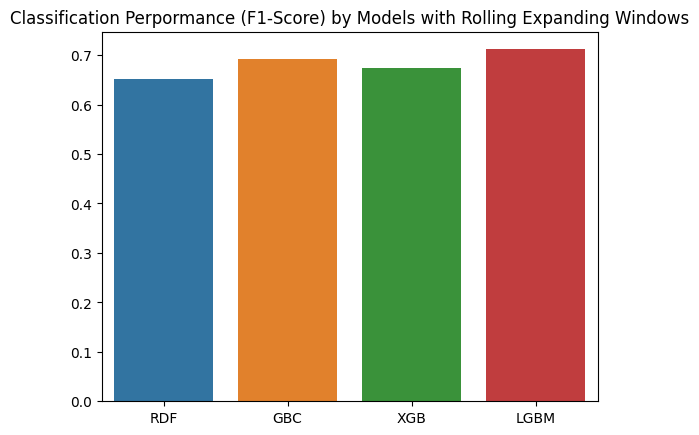

In [137]:
list_model = ['RDF', 'GBC', 'XGB', 'LGBM']
list_result = [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result]

list_f1 = []

for model, data in zip(list_model, list_result):
  F1 = f1_score(data['Actual_POS_WML'], data[f'{model}_PRED_POS_WML'])
  print(f'{model}의 F1-Score : {F1}')
  list_f1.append(F1)
print()

sns.barplot(x=list_model, y=list_f1)
plt.title('Classification Perpormance (F1-Score) by Models with Rolling Expanding Windows')
plt.show()

RDF의 F1-Score : 0.6597760551248923
GBC의 F1-Score : 0.7356495468277945
XGB의 F1-Score : 0.6738232865400495
LGBM의 F1-Score : 0.6917534027221777



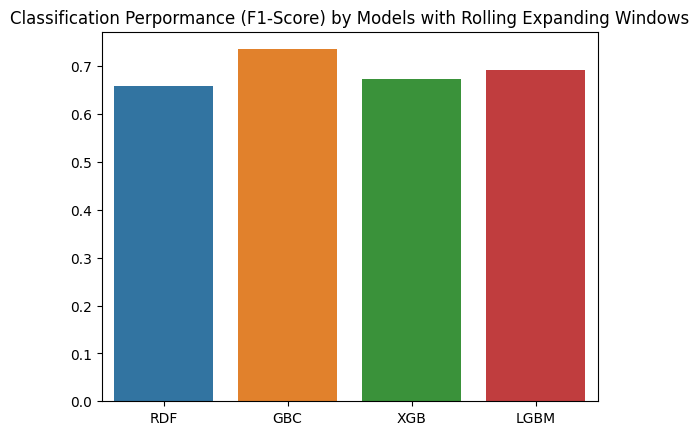

In [138]:
list_model = ['RDF', 'GBC', 'XGB', 'LGBM']
list_result = [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result]

list_f1 = []

for model, data in zip(list_model, list_result):
  F1 = f1_score(data['Actual_POS_WML'], data[f'{model}_PRED_POS_WML'])
  print(f'{model}의 F1-Score : {F1}')
  list_f1.append(F1)
print()

sns.barplot(x=list_model, y=list_f1)
plt.title('Classification Perpormance (F1-Score) by Models with Rolling Expanding Windows')
plt.show()

## Cum Return & Sharpe Ratio

In [139]:
R_WML = WML.loc[19470731:].copy()
CUM_WML = WML.loc[19470731:].copy()

CUM_WML['wml'] = (1 + CUM_WML.wml).cumprod() - 1
CUM_WML.columns = ['cum_return'] 

last_r = CUM_WML['cum_return'].values[-1]
w_S = (R_WML['wml'].mean()/R_WML['wml'].std()) * math.sqrt(12)

In [140]:
def compare_sharpe_ratio(list_model, list_result, list_cum, dynamic=True):

  print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format('ORG', w_S, last_r))

  for model, data, cum in zip(list_model, list_result, list_cum):
    data['wml'] = WML.loc[19470731:]['wml']

    if dynamic == True:

      data[f'{model}_PROB_WML'] = data['wml'] * data[f'{model}_PROB_POS_WML']
      S = (data[f'{model}_PROB_WML'].mean()/data[f'{model}_PROB_WML'].std())*math.sqrt(12)

      C = list(cum['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))

      sns.lineplot(data=cum, x=data.index, y='cum_return', alpha=0.7, label=model)

    else:

      data[f'{model}_PRED_WML'] = data['wml'] * data[f'{model}_PRED_POS_WML']
      S = (data[f'{model}_PRED_WML'].mean()/data[f'{model}_PRED_WML'].std())*math.sqrt(12)

      C = list(cum['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))
      
      sns.lineplot(data=cum, x=data.index, y='cum_return', alpha=0.7, label=model)

  sns.lineplot(data=CUM_WML, x=CUM_WML.index, y='cum_return', alpha=0.7, label='ORG')
  plt.title('Sharpe Ratio & Cum Return by Model')
  plt.xticks([CUM_WML.index[i] for i in range(0,len(CUM_WML.index), 12)])
  plt.tick_params(axis='x',
                    direction='out',
                    labelrotation=45,
                    length=1,
                    pad=10,
                    labelsize=1,
                    width=0.1)
  plt.show()

### Rolling Fixed Windows

#### Static

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.5781  최종 누적 수익률 : 1683.8333881173571
GBC Sharpe Ratio : 0.6371  최종 누적 수익률 : 5278.899546036944
XGB Sharpe Ratio : 0.5716  최종 누적 수익률 : 1990.8702487190076
LGBM Sharpe Ratio : 0.6329  최종 누적 수익률 : 9903.282594066612


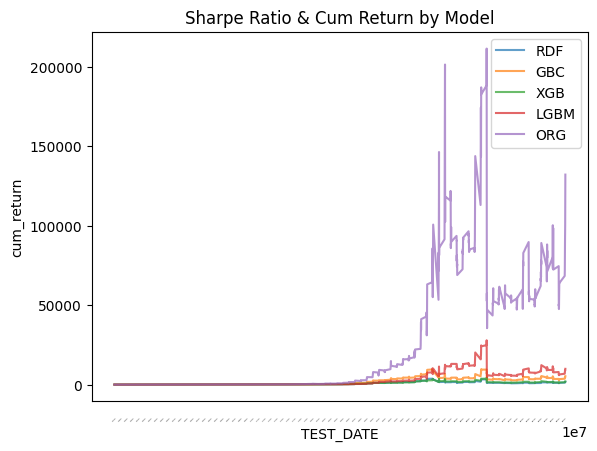

In [141]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result],
                     [RDF_F_CUM_RETURN_static, GBC_F_CUM_RETURN_static, XGB_F_CUM_RETURN_static, LGBM_F_CUM_RETURN_static],
                     dynamic=False)

#### Dynamic

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.6879  최종 누적 수익률 : 3655.278513161391
GBC Sharpe Ratio : 0.6899  최종 누적 수익률 : 2822.598971741963
XGB Sharpe Ratio : 0.6876  최종 누적 수익률 : 2918.8192305580887
LGBM Sharpe Ratio : 0.7270  최종 누적 수익률 : 3676.1601667484047


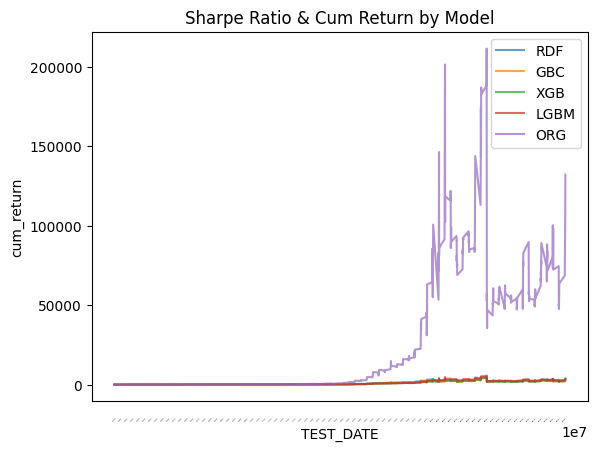

In [142]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result],
                     [RDF_F_CUM_RETURN_dynamic, GBC_F_CUM_RETURN_dynamic, XGB_F_CUM_RETURN_dynamic, LGBM_F_CUM_RETURN_dynamic],
                     dynamic=True)

### Rolling Expanding Windows

#### Static

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.6019  최종 누적 수익률 : 2684.918650327071
GBC Sharpe Ratio : 0.7389  최종 누적 수익률 : 43705.39577807092
XGB Sharpe Ratio : 0.5403  최종 누적 수익률 : 1335.9132421780564
LGBM Sharpe Ratio : 0.6722  최종 누적 수익률 : 13133.584078674427


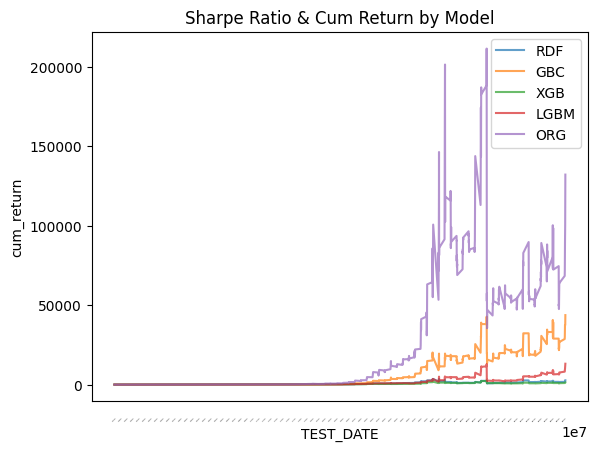

In [143]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result],
                     [RDF_E_CUM_RETURN_static, GBC_E_CUM_RETURN_static, XGB_E_CUM_RETURN_static, LGBM_E_CUM_RETURN_static],
                     dynamic=False)

#### Dynamic

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.6658  최종 누적 수익률 : 2874.2540873553176
GBC Sharpe Ratio : 0.7233  최종 누적 수익률 : 3075.081586489015
XGB Sharpe Ratio : 0.6577  최종 누적 수익률 : 1933.4464659475407
LGBM Sharpe Ratio : 0.7491  최종 누적 수익률 : 4000.25145200905


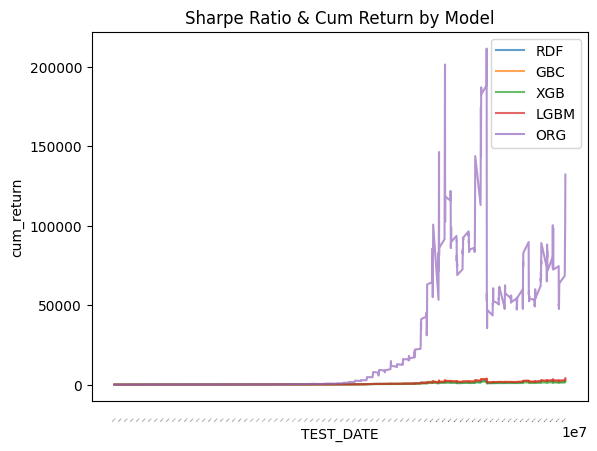

In [144]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result],
                     [RDF_E_CUM_RETURN_dynamic, GBC_E_CUM_RETURN_dynamic, XGB_E_CUM_RETURN_dynamic, LGBM_E_CUM_RETURN_dynamic],
                     dynamic=True)